In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms

from tinygp import kernels
from scipy.stats import loguniform, uniform

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from prettytable import PrettyTable

#from stingray.simulator import simulator
#import random
import jaxns
from scipy.signal import savgol_filter

#from jaxns import ExactNestedSampler
#from jaxns import TerminationCondition
import re

from matplotlib.patches import Rectangle

import tensorflow_probability.substrates.jax.distributions as tfpd

from tinygp import GaussianProcess
from functools import partial
import pickle
import warnings
warnings.filterwarnings('ignore')
from pioran import PSDToACV
from pioran.psd import OneBendPowerLaw

from scipy.fft import fft, fftfreq
from scipy.integrate import quad


from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison
from scipy.signal import savgol_filter

from IPython.display import display, clear_output

import json
def load_json(file_path):
        with open(file_path) as json_file:
            return json.load(json_file)
        
import seaborn as sns
        
import corner
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, quantiles= [.16, .50, .84], title_kwargs={"fontsize": 12})
    
    plt.show()
    
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod
    


# before results

In [3]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

52587
97889


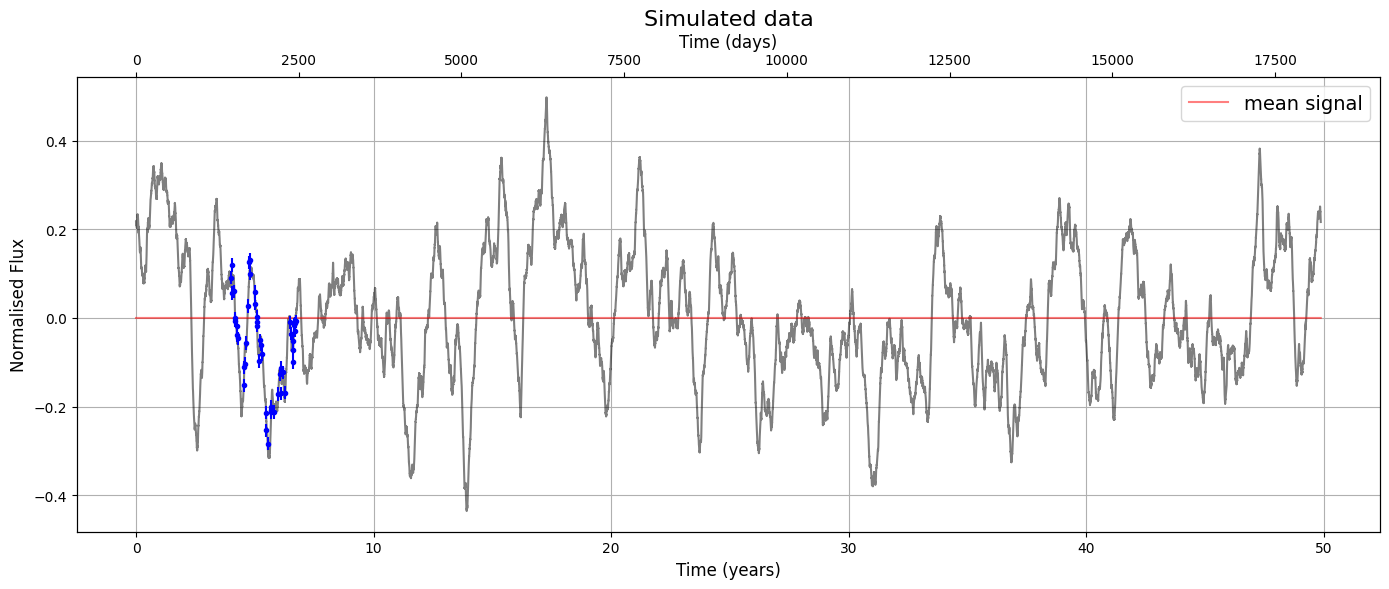

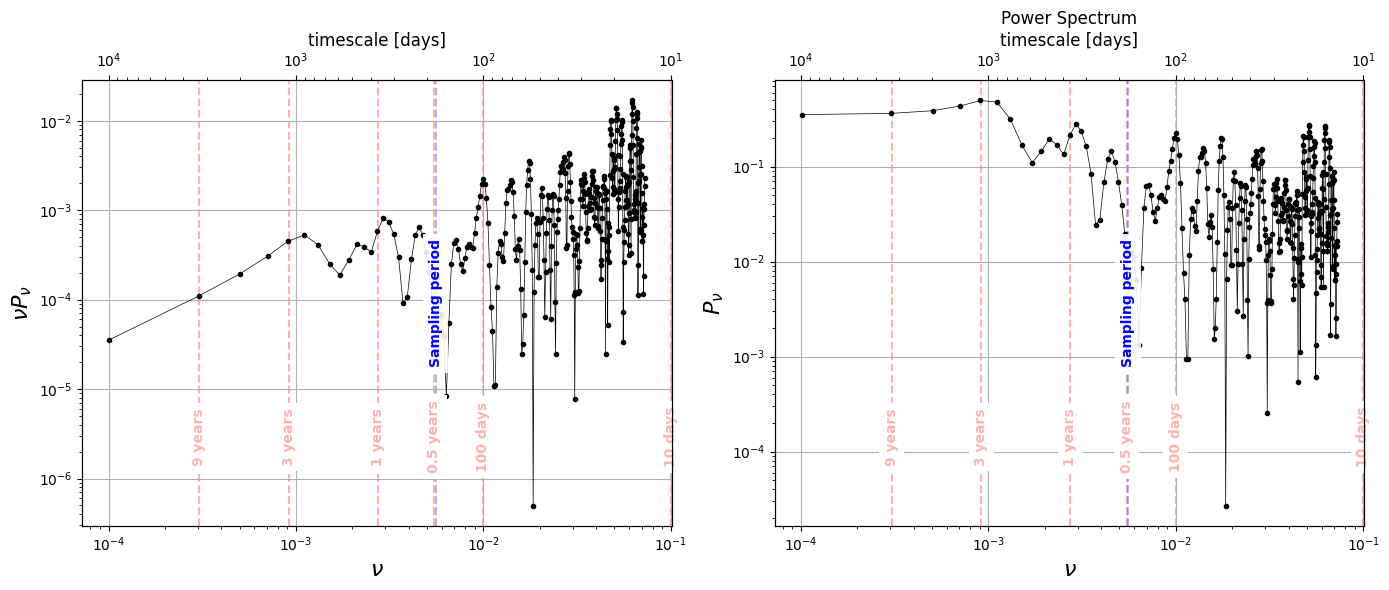

In [4]:
np.random.seed()
rand =  np.random.randint(0, 100000)
print(rand)
l = LightCurveSampler(N=2**18, rms=0.15, dt = 100, simulatorSEED= rand ,mean = 0.0,  verbose=False)
l.load_powerspec(bend_pl, [200,  1/365,  -1,-3,10], plot=False)
l.LCsimulator()
np.random.seed() 
rand =  97889 #np.random.randint(0, 100000)

print(rand)
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 10, NumofWINDOW = 6 , OBSperiod = 6, WINDOWwidth =120, samplerSEED=rand,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=True)


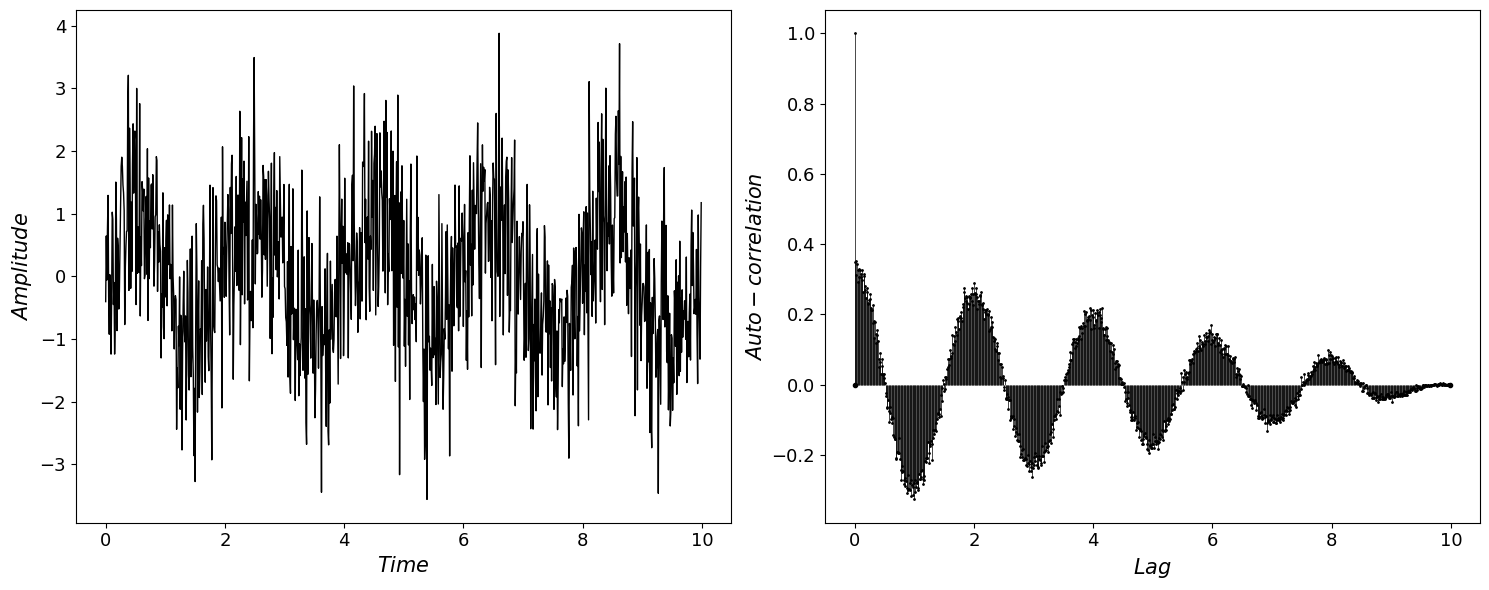

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the AutoCovariance Function (ACVF)
def compute_acvf(time_series):
    n = len(time_series)
    mean = np.mean(time_series)
    acvf = np.correlate(time_series - mean, time_series - mean, mode='full') / n
    return acvf[n - 1:]

# Function to compute the AutoCorrelation Function (ACF)
def compute_acf(acvf):
    return acvf / acvf[0]

# Parameters for the periodic signal
n = 1000  # Number of samples
freq = 0.5 # Frequency of the sine wave in Hz
sampling_rate = 100  # Sampling rate in Hz

# Generate time array
t = np.arange(n) / sampling_rate

# Generate a periodic signal (sine wave)
time_series = np.sin(2 * np.pi * freq * t) + np.random.normal(loc=0, scale=1, size=n)

# Calculate AutoCovariance Function (ACVF)
acvf_values = compute_acvf(time_series)

# Calculate AutoCorrelation Function (ACF)
acf_values = compute_acf(acvf_values)

# Generate lag array in time units
lags = np.arange(len(acf_values)) / sampling_rate

# Plot the periodic signal and ACF side by side
plt.figure(figsize=(15, 6))

# Plot the periodic signal
plt.subplot(1, 2, 1)
plt.plot(t, time_series, 'k-', lw=1)
plt.xlabel('$Time$', fontsize = 15)
plt.ylabel('$Amplitude$', fontsize = 15)
plt.tick_params(labelsize = 13)


# Plot the AutoCorrelation Function (ACF)
plt.subplot(1, 2, 2)
markerline, stemline, baseline, = plt.stem(lags, acf_values,linefmt='k-',markerfmt='ko',basefmt='k.')
plt.setp(stemline, linewidth = 0.5)
plt.setp(markerline, markersize = 1)
plt.xlabel('$Lag$', fontsize = 15)
plt.ylabel('$Auto-correlation$', fontsize = 15)
plt.tick_params(labelsize = 13)

plt.tight_layout()
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'plots/THESIS/power_spec.png'

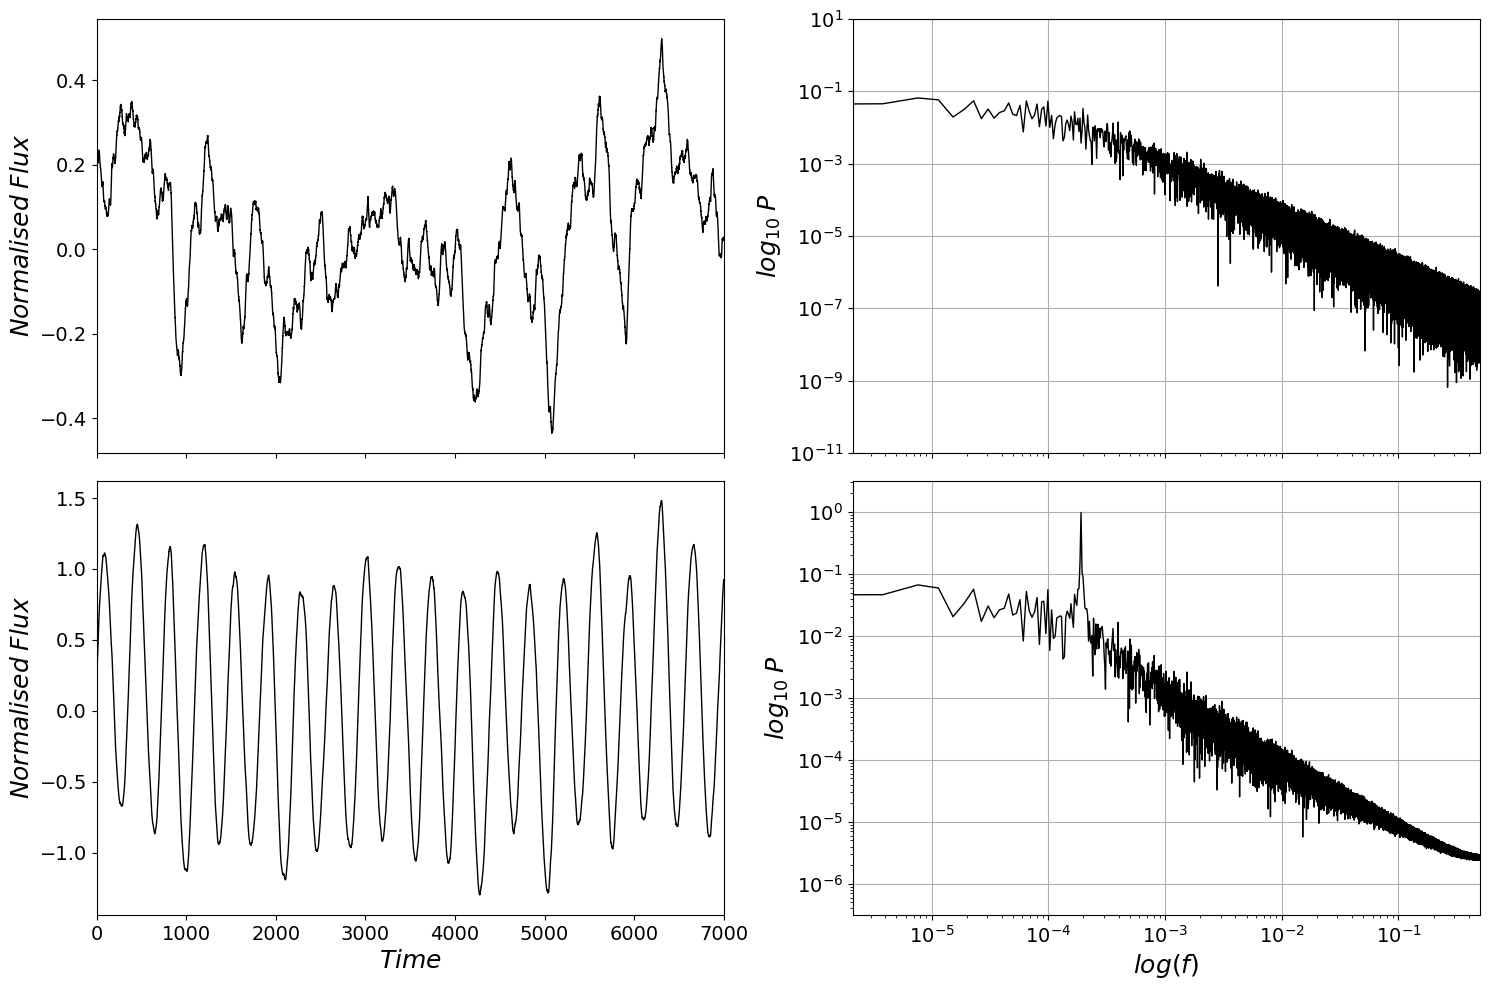

In [6]:

def generate_red_noise(size, seed=0):
    np.random.seed(seed)
    white_noise = np.random.normal(size=size)
    red_noise = np.cumsum(white_noise)
    return red_noise

# Generate non-periodic (red noise) and periodic signals
non_periodic_signal = lc.counts
time = lc.time
np.random.seed(0)
periodic_signal = np.sin(2 * np.pi * time / (1*365)) + 1*non_periodic_signal

# Function to compute autocovariance
def autocovariance(x, lag):
    n = len(x)
    mean = np.mean(x)
    return np.mean((x[:n-lag] - mean) * (x[lag:] - mean))

# Compute ACVF and ACF
def compute_acvf_acf(signal):
    lags = np.arange(100)
    acvf = [autocovariance(signal, lag) for lag in lags]
    acf = acvf / acvf[0]
    return lags, acvf, acf

# Compute power spectrum
def compute_power_spectrum(signal):
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1)[:n//2]
    power_spectrum = 2.0/n * np.abs(yf[:n//2])
    return xf, power_spectrum

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex = 'col')

# Plot non-periodic signal metrics
lags, non_periodic_acvf, non_periodic_acf = compute_acvf_acf(non_periodic_signal)
xf_non_periodic, power_spectrum_non_periodic = compute_power_spectrum(non_periodic_signal)

# Non-periodic signal
axes[0, 0].plot(time, non_periodic_signal,'k-', lw = 1)
axes[0, 0].set_ylabel(r'$Normalised\;Flux$', fontsize =18)
axes[0, 0].set_xlim(min(time), max(time))
axes[0, 0].tick_params(labelsize= 14)

# Non-periodic signal Power Spectrum
axes[0, 1].plot(xf_non_periodic, power_spectrum_non_periodic, 'k-', lw = 1)
axes[0, 1].set_ylim(10**-11, 10**1)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].grid()
axes[0, 1].set_xlim(min(xf_non_periodic), max(xf_non_periodic))
axes[0, 1].tick_params(labelsize= 14)
axes[0, 1].set_ylabel(r'$log_{10}\;P$', fontsize = 18)

# Plot periodic signal metrics
lags, periodic_acvf, periodic_acf = compute_acvf_acf(periodic_signal)
xf_periodic, power_spectrum_periodic = compute_power_spectrum(periodic_signal)

# Periodic signal
axes[1, 0].plot(time, periodic_signal, 'k-', lw =1)
axes[1, 0].tick_params(labelsize= 14)
axes[1, 0].set_xlim(min(time), 7000)
axes[1, 0].set_xlabel(r'$Time$', fontsize =18)
axes[1, 0].set_ylabel(r'$Normalised\;Flux$', fontsize =18)

# Periodic signal Power Spectrum
axes[1, 1].plot(xf_periodic, power_spectrum_periodic,  'k-', lw = 1)
axes[1, 1].set_xlabel(r'$log(f)$', fontsize = 18)
axes[1, 1].set_ylim(10**-6.5, 10**0.5)
axes[1, 1].grid()
axes[1, 1].set_xscale('log')
axes[1, 1].tick_params(labelsize= 14)
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylabel(r'$log_{10}\;P$', fontsize = 18)

plt.tight_layout()
plt.savefig('plots/THESIS/power_spec.png')
plt.show()


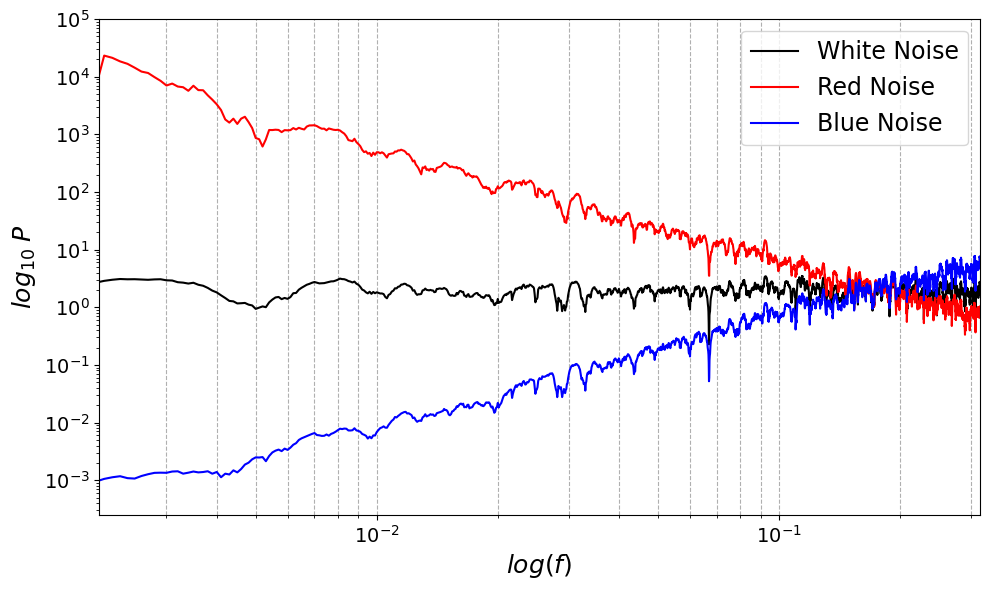

In [ ]:
def generate_white_noise(size, seed=0):
    np.random.seed(seed)
    return np.random.normal(size=size)

# Generate red noise (Brownian noise)
def generate_red_noise(size, seed=0):
    np.random.seed(seed)
    white_noise = np.random.normal(size=size)
    red_noise = np.cumsum(white_noise)
    return red_noise

# Generate blue noise
def generate_blue_noise(size, seed=0):
    np.random.seed(seed)
    white_noise = np.random.normal(size=size)
    blue_noise = np.diff(white_noise, n=1)
    return blue_noise

# Compute power spectrum
def compute_power_spectrum(signal):
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1)[:n//2]
    power_spectrum = 2.0/n * np.abs(yf[:n//2])**2
    return xf[1:], power_spectrum[1:]  # Exclude the zero frequency

# Generate noise signals
size = 10000
s = 1089
white_noise = generate_white_noise(size, seed=s)
red_noise = generate_red_noise(size, seed=s)
blue_noise = generate_blue_noise(size, seed=s)

# Compute power spectra
xf_white, ps_white = compute_power_spectrum(white_noise)
xf_red, ps_red = compute_power_spectrum(red_noise)
xf_blue, ps_blue = compute_power_spectrum(blue_noise)

# Plotting power spectra in log-log space
plt.figure(figsize=(10, 6))

plt.loglog(xf_white, savgol_filter(ps_white, 35, 2), color = 'k', label='White Noise')
plt.loglog(xf_red, savgol_filter(ps_red, 35, 2), color = 'red',label='Red Noise')
plt.loglog(xf_blue, savgol_filter(ps_blue, 35, 2), color = 'blue', label='Blue Noise')

plt.xlabel(r'$log(f)$', fontsize = 18)
plt.xlim(10**-2.69, 10**-0.5)
plt.ylim(10**-3.6, 10**5)
plt.ylabel(r'$log_{10}\;P$', fontsize = 18)
plt.legend(fontsize = 17)
plt.grid(ls = "--", axis = 'x', which='both')
plt.tick_params(labelsize= 14)
#plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

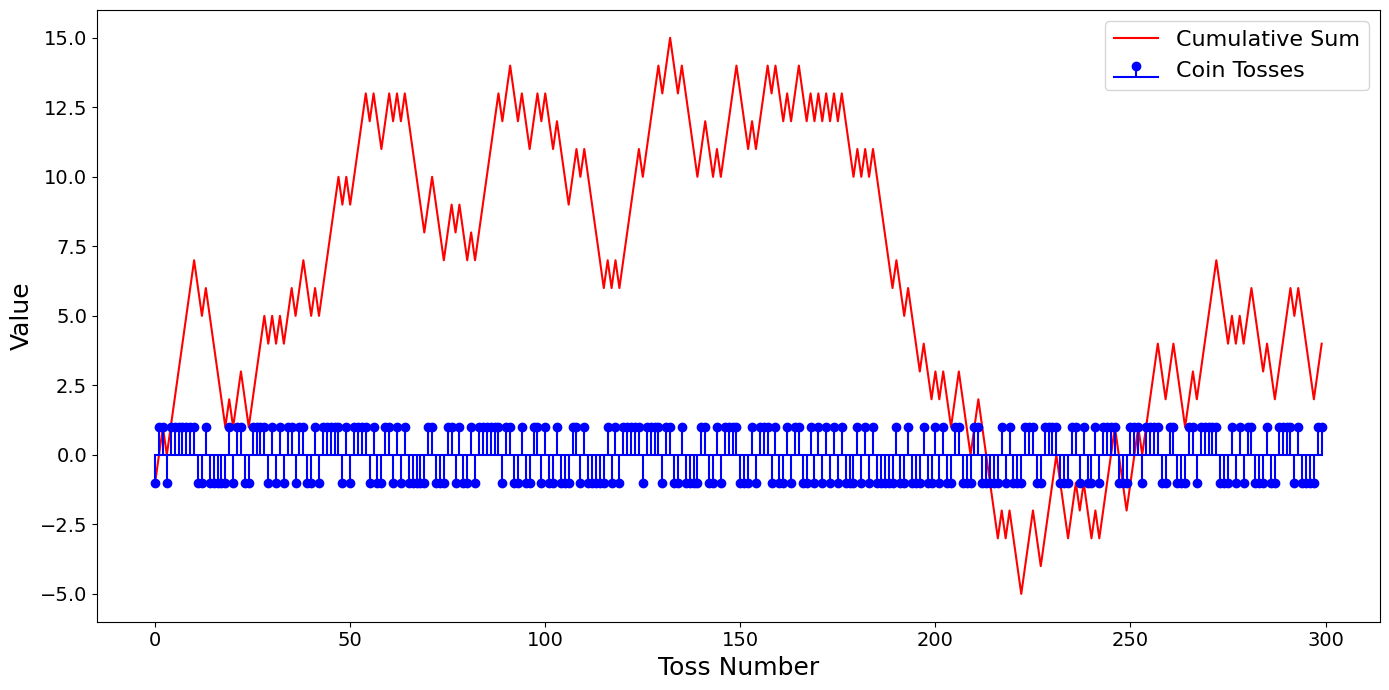

In [7]:

# Parameters
n_tosses = 300  # Number of coin tosses

# Generate random coin tosses: +1 for heads and -1 for tails
coin_tosses = np.random.choice([-1, 1], size=n_tosses)

# Compute the cumulative sum
cumulative_sum = np.cumsum(coin_tosses)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the cumulative sum
plt.plot(cumulative_sum, color='red', label='Cumulative Sum')

# Add spikes for coin tosses
plt.stem(range(n_tosses), coin_tosses, linefmt='b-', markerfmt='bo', basefmt='b-', label='Coin Tosses')

# Add titles and labels
#plt.title('Cumulative Sum of Coin Tosses with Spikes for Individual Tosses')
plt.xlabel('Toss Number', fontsize = 18)
plt.ylabel('Value', fontsize = 18)
plt.legend(fontsize = 16)
plt.tick_params(labelsize = 14)

# Show plot
plt.tight_layout()
plt.show()


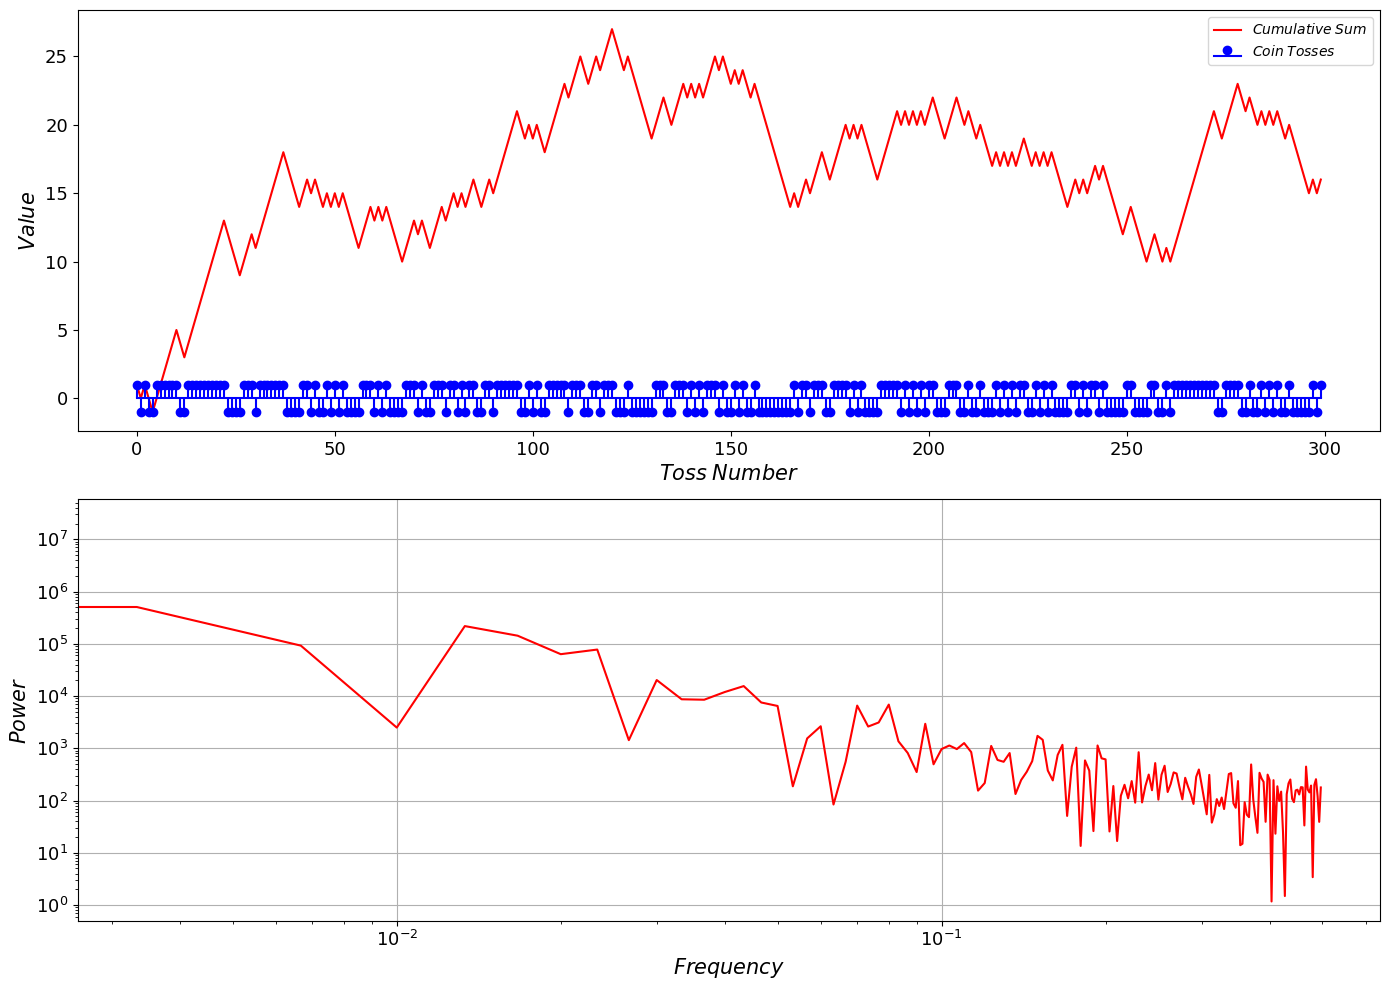

In [8]:

from scipy.fft import fft, fftfreq

# Parameters
n_tosses = 300  # Number of coin tosses

# Generate random coin tosses: +1 for heads and -1 for tails
coin_tosses = np.random.choice([-1, 1], size=n_tosses)

# Compute the cumulative sum
cumulative_sum = np.cumsum(coin_tosses)

# Compute the power spectrum of the cumulative sum
fft_values = fft(cumulative_sum)
frequencies = fftfreq(n_tosses, d=1.0)  # Frequency axis
power_spectrum = np.abs(fft_values)**2  # Power spectrum

# Create the plots
plt.figure(figsize=(14, 10))

# Plot the cumulative sum and coin tosses as spikes
plt.subplot(2, 1, 1)
plt.plot(cumulative_sum, color='red', label='$Cumulative\;Sum$')
plt.stem(range(n_tosses), coin_tosses, linefmt='b-', markerfmt='bo', basefmt='b-', label='$Coin\;Tosses$')
plt.xlabel('$Toss\;Number$', fontsize = 15)
plt.ylabel('$Value$', fontsize = 15)
plt.tick_params(labelsize = 13)
plt.legend()

# Plot the power spectrum
plt.subplot(2, 1, 2)
plt.plot(frequencies[:n_tosses // 2], power_spectrum[:n_tosses // 2], color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Frequency$', fontsize = 15)
plt.ylabel('$Power$', fontsize = 15)
plt.tick_params(labelsize = 13)
plt.grid()

plt.tight_layout()
plt.show()


In [9]:
def simlc(dt, ntimes, expquery, rms, psmodel, pspar):
    '''
    dt       :  bin size
    ntimes   :  number of time bins( power of 2)
    expquery :  selection between non linear variability and non skewed flux distribution
    rms      :  rms value of the power spectrum in the given frequency range
    psmodel  :  power spectrum model
    pspar    :  power spectrum model paramters
    
    '''
    # Generates simulated light curve with ntimes consecutive time bins of bin size dt, required output rms
    # (set to zero to use the power spectrum normalisations as given) and a given power-spectral model and input
    # parameters
    f_min = 1./(dt*ntimes) # Define minimum and maximum sampled frequency
    f_max = 1/(2.*dt)
    params = tuple(pspar) # Need to do this since the quad function requires function arguments as a tuple
    int_rmssq, err = quad(psmodel, f_min, f_max, args=params)
    #print("Integrated rms = ",np.sqrt(int_rmssq))
    if (rms > 0.): # If rms > 0 then correct the power spectrum normalisation to obtain output light curve with the 
        # input rms value (otherwise the output is based on the normalisation given in pspar)
        pspar[0] = pspar[0]*(rms**2)/int_rmssq
        int_rmssq = rms**2
        params = tuple(pspar)
        #print("Correcting rms to: ",np.sqrt(quad(psmodel, f_min, f_max, args=params)[0]))    
                                            
    if (expquery == 'y'): # If we want to exponentiate the light curve to ensure fluxes are positive and 
        # flux distribution is lognormal, similar to real data.  The input normalisation is corrected so the output
        # has the same fractional rms as the input rms (assumed to be fractional)
        exp_pspar = np.copy(pspar)
        rmssq = int_rmssq
        linrmssq = np.log(rmssq+1.0)
        exp_pspar[0] = exp_pspar[0]*(linrmssq/rmssq)
        lc = tksim(dt, ntimes, psmodel, exp_pspar)
        lc = np.exp(lc)
    else:
        lc = 1. + tksim(dt, ntimes, psmodel, pspar) # This is just a linear model with normally distributed fluxes,
        # if the rms is large there is a risk that some fluxes go negative.

    lc = lc/np.mean(lc)  # Output is normalised to mean of 1
        
    #print("Output light curve standard deviation = ",np.std(lc))
    return lc

def tksim(dt, ntimes, psmodel, pspar):
    '''
    dt       :  bin size
    ntimes   :  number of time bins( power of 2)
    psmodel  :  power spectrum model
    pspar    :  power spectrum model paramters
    
    '''
# Implementation of Timmer & Koenig method to simulate a noise process for an arbitrary power-spectral shape 
# (Timmer & Koenig, 1995, A&A, 300, 707), based on an original Python implementation by Dimitrios Emmanoulopoulos
    nfreq = ntimes//2
    f = np.arange(1.0, nfreq+1, 1.0)/(ntimes*dt)
    modpow = psmodel(f, *pspar) * nfreq/dt

    ft_re=np.random.normal(scale = np.sqrt(modpow*0.5))
    ft_im=np.random.normal(scale = np.sqrt(modpow*0.5))
    
    ft_pos = ft_re + ft_im*1j
    ft_neg = np.conj(ft_pos) # sets negative frequencies as complex conjugate of positive (for real-valued LC)
    ft_full=np.append(ft_pos,ft_neg[nfreq-2::-1]) # append -ve frequencies to +ve.  Note that scipy.fftpack orders
    # the FT array as follows: y[0] = zero freq, y[1:nfreq-1] ascending +ve freq values, y[nfreq:2*nfreq-1] ascending
    # (i.e. less -ve) -ve freq values.  This means that the Nyquist freq value used at y[nfreq] is actually the -ve
    # frequency value.
    # For our even-valued nfreq this doesn't matter since we must set the Nyquist freq value to be real anyway 
    # (see below).  
    ft_full=np.insert(ft_full,0,complex(0.0,0.0))  # Set zero-freq (i.e. 'DC component' or mean) to zero
    ft_full[nfreq]=complex(ft_full.real[nfreq],0.0) # For symmetry need to make Nyquist freq value real - note that
    # neglecting to do this causes a small imaginary component to appear in the inverse FFT
    ift_full=np.fft.ifft(ft_full)                            
    lc=ift_full.real
    return lc                                            


def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod
    
    
def bend_pl_lorentz(f, norm, f_bend, alph_lo, alph_hi, sharpness, lor_rmssq, f_pk, q):
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod_lorentz = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    
    powmod_bend_pl = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    
    return powmod_bend_pl+powmod_lorentz

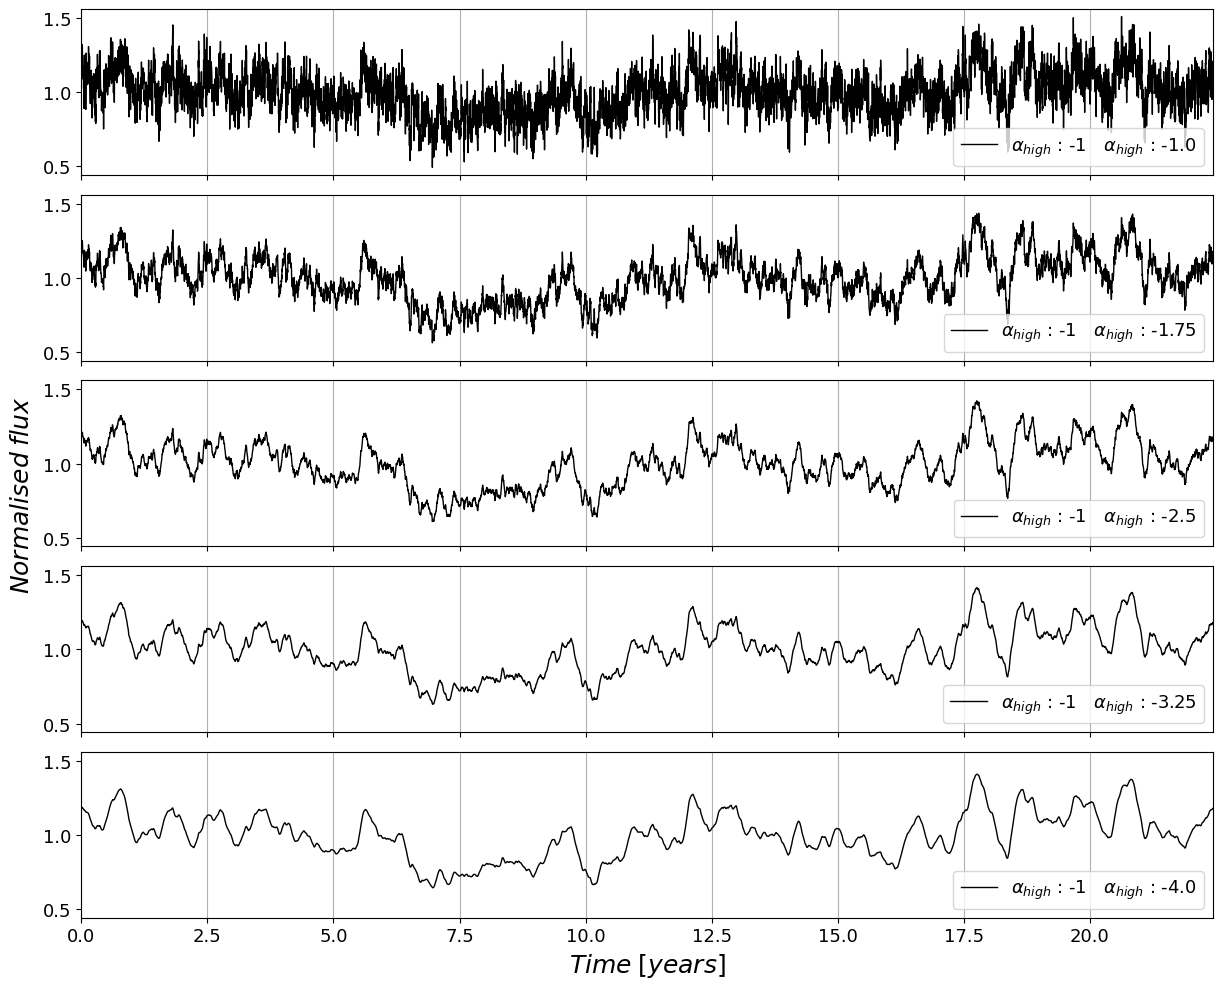

In [10]:

psmodel = bend_pl
pspar = [100.,1.5/365,-1,-1,5.0] 

#psmodel = lorentz_q
#pspar = [10, 1e-2, 0.5]

#psmodel = bend_pl_lorentz
#pspar = [0,1e-3,-0,-0,10.0, 100, 1e-2, 10 ]

bend_freq_array = np.linspace(1/(10*365), 1/(0.1*365), 100)
lower_slope_array = np.linspace(-2, 0, 50)
high_slope_array = np.linspace(-1, -4, 5)
sharpness_array = np.linspace(1, 15, 50)
dt=1
ntimes=2**13
expquery = 'n'
rms=0.15

#for i,val in enumerate(bend_freq_array):
#for i,val in enumerate(sharpness_array):
fig,ax = plt.subplots(5,1, figsize=[12,10], sharex = 'col', sharey = True)
for i,val in enumerate(high_slope_array):    
    pspar[3] = val
    params = tuple(pspar)
    np.random.seed(10)
    lc = simlc(dt, ntimes, expquery, rms, psmodel, pspar)

    time = np.linspace(start=dt,stop=(dt*ntimes),num=ntimes)

    #if i==0:
    #    ax[i].plot(time/365,lc, 'k-', lw=1,  label = r'$\alpha_{low}$ = $\alpha_{high}$ : '+str(val))
    #else:
    ax[i].plot(time/365,lc, 'k-', lw=1,  label = r'$\alpha_{high}$ : -1   $\alpha_{high}$ : '+str(val))
    if i == 4:
        ax[i].set_xlabel('$Time\;[years]$', fontsize=18)
    
    ax[i].tick_params(labelsize = 13)
    ax[i].grid(axis = 'x')
    ax[i].set_xlim(0, max(time/365))
    #ax[0].set_ylim(0.2, 2)
    ax[i].legend(loc = 'lower right', fontsize = 13)
    # plot the model

    # minfreq = 1./(ntimes*dt)
    # freq = np.linspace(start=minfreq,stop=(minfreq*ntimes/2),num=ntimes//2)
    # ax[i][1].plot(freq, psmodel(freq,*pspar), 'r-', lw=3)
    # ax[i][1].set_xlabel(r'$\nu$',fontsize=16)
    # ax[i][1].set_ylabel(r'$\nu P_{\nu}$',fontsize=16)
    # ax[i][1].set_yscale('log')
    # ax[i][1].set_xscale('log')
    # #ax[i][1].set_ylim(10**-4, 10**8)
    # ax[i][1].set_title('Power spectrum', fontsize=19)
    #plt.tight_layout()
    #plt.suptitle(str(i)+'  '+ str(np.round(val, decimals=5)) + '  '+str(np.round(1/val/365, decimals=3)))
    #display(fig)
    #plt.pause(0.5)
    #clear_output(wait=True)
    #plt.clf()
    #plt.close()
    
fig.text(-0.015, 0.5, '$Normalised\;flux$', va='center', fontsize = 18, rotation='vertical')
#plt.ylabel('Normalised flux', fontsize=16)
plt.tight_layout()

plt.show()
#time,lc = plot_simulate(psmodel, pspar)

In [11]:
def ar1_process(impulse, num_steps, phi, sigma, noise = [-99]):
    """
    Simulate an AR(1) process.

    Parameters:
        num_steps (int): Number of time steps.
        phi (float): AR(1) parameter.
        sigma (float): Standard deviation of the white noise.

    Returns:
        numpy.ndarray: Simulated AR(1) process.
    """
    x = impulse #np.zeros()
    if noise[0] ==-99:
        noise = np.random.normal(scale=sigma, size=num_steps-1)
    for t in range(1, num_steps):
        x[t] = phi * x[t-1] + noise[t-1]
    return x, noise

def state_response_impulse(phi, sigma, impulse_time, num_steps=100):
    """
    Calculate the state response to an impulse disturbance for an AR(1) process.

    Parameters:
        phi (float): AR(1) parameter.
        sigma (float): Standard deviation of the white noise.
        impulse_time (int): Time step at which the impulse disturbance occurs.
        num_steps (int): Number of time steps.

    Returns:
        numpy.ndarray: State response.
    """
    impulse = np.zeros(num_steps)
    impulse[impulse_time] = 1.0  # Impulse disturbance at specified time step
    ar_process = ar1_process(impulse, num_steps, phi, sigma)
    #state_response = np.convolve(ar_process, impulse, mode='full')[:num_steps]
    return ar_process

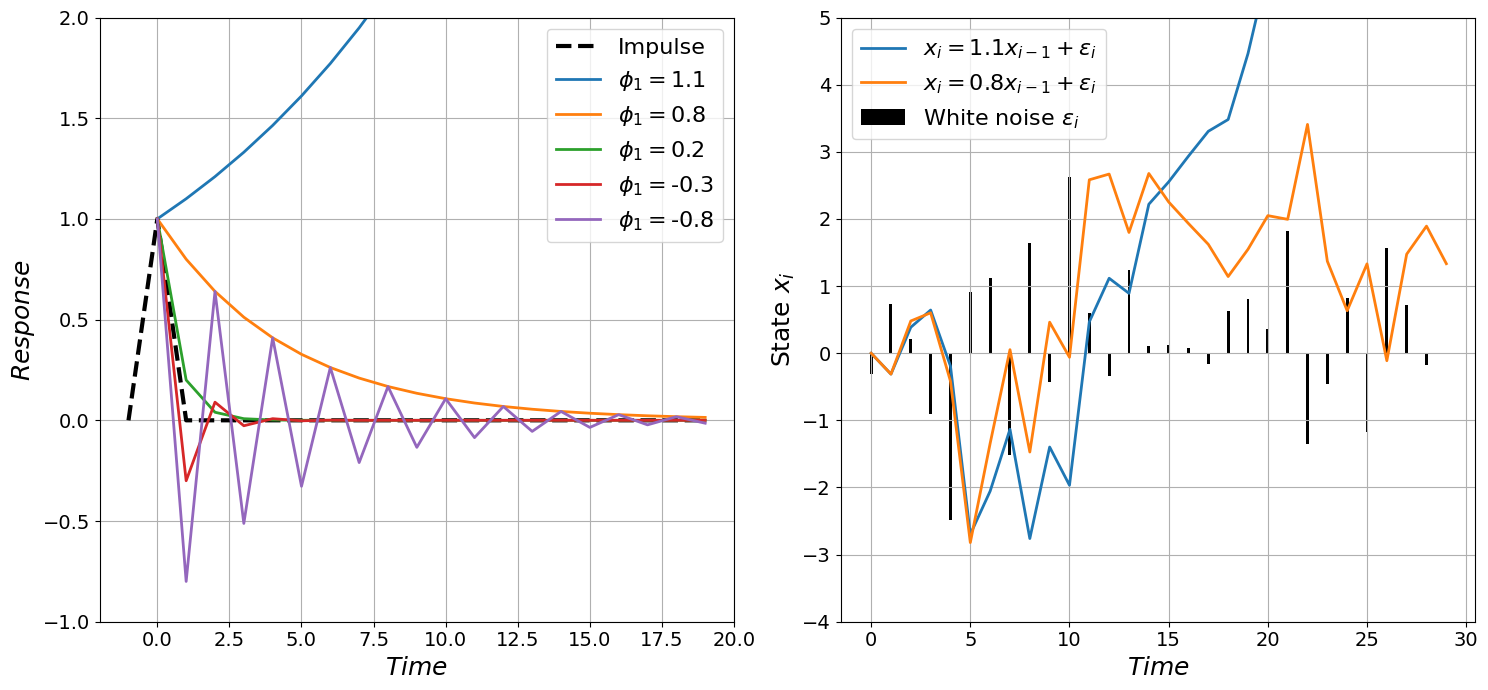

In [12]:
phi = 1.1  # AR(1) parameter
sigma = 1.0  # Standard deviation of white noise
impulse_time = 0  # Time step at which the impulse occurs
num_steps = 20

# Calculate state response to impulse disturbance

# Plot
fig, ax = plt.subplots(1,2, figsize=(15, 7))
imp = np.zeros(21)
imp[1]=1
ax[0].plot(np.arange(-1,20, 1), imp, 'k--',lw = 3, label = 'Impulse')
ax[0].plot(state_response_impulse(1.1, 0, 0, 20)[0], label=r'$\phi_1  = $1.1', lw = 2)
ax[0].plot(state_response_impulse(0.8, 0, 0, 20)[0], label=r'$\phi_1  = $0.8', lw = 2)
ax[0].plot(state_response_impulse(0.2, 0, 0, 20)[0], label=r'$\phi_1  = $0.2', lw = 2)
ax[0].plot(state_response_impulse(-0.3, 0, 0, 20)[0], label=r'$\phi_1  = $-0.3', lw = 2)
ax[0].plot(state_response_impulse(-0.8, 0, 0, 20)[0], label=r'$\phi_1  = $-0.8', lw = 2)
ax[0].set_xlabel('$Time$', fontsize = 18)
ax[0].set_ylabel('$Response$', fontsize=18)
ax[0].set_ylim(-1, 2)
#plt.title('State Response to Impulse Disturbance for AR(1) Process')
ax[0].legend(fontsize = 16)
ax[0].tick_params(labelsize= 14)
ax[0].grid(True)
np.random.seed(6)
noise = np.random.normal(0, 1, size=29)
ar1_11, _ = ar1_process(np.zeros(30), 30, 1.1, 1.2, noise= noise)
ar1_08, _ = ar1_process(np.zeros(30), 30, 0.8, 1.2, noise= noise)
ar1_02, _ = ar1_process(np.zeros(30), 30, 0.2, 1.2, noise= noise)
ar1__03, _ = ar1_process(np.zeros(30), 30, -0.3, 1.2, noise= noise)
ar1__08, _ = ar1_process(np.zeros(30), 30, -0.8, 1.2, noise= noise)

ax[1].plot(ar1_11, color= 'tab:blue', lw = 2, label = r'$x_i = 1.1x_{i-1} + \epsilon_i$')
ax[1].bar(np.arange(29),noise, width = 0.15, color = 'k', label = r'White noise $\epsilon_i$')
ax[1].plot(ar1_08, color= 'tab:orange', lw = 2, label = r'$x_i = 0.8x_{i-1} + \epsilon_i$')
#ax[1].plot(ar1_02, color= 'tab:green', lw = 2)
#ax[1].plot(ar1__03, color= 'tab:red', lw = 2)
#ax[1].plot(ar1__03, color= 'tab:purple', lw = 2, label = r'$x_i = -0.8x_{i-1} + \epsilon_i$')

ax[1].set_ylim(-4, 5)
ax[1].set_xlabel('$Time$', fontsize = 18)
ax[1].set_ylabel(r'State $x_i$', fontsize=18)
#plt.title('State Response to Impulse Disturbance for AR(1) Process')
ax[1].legend(fontsize = 16)
ax[1].tick_params(labelsize= 14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

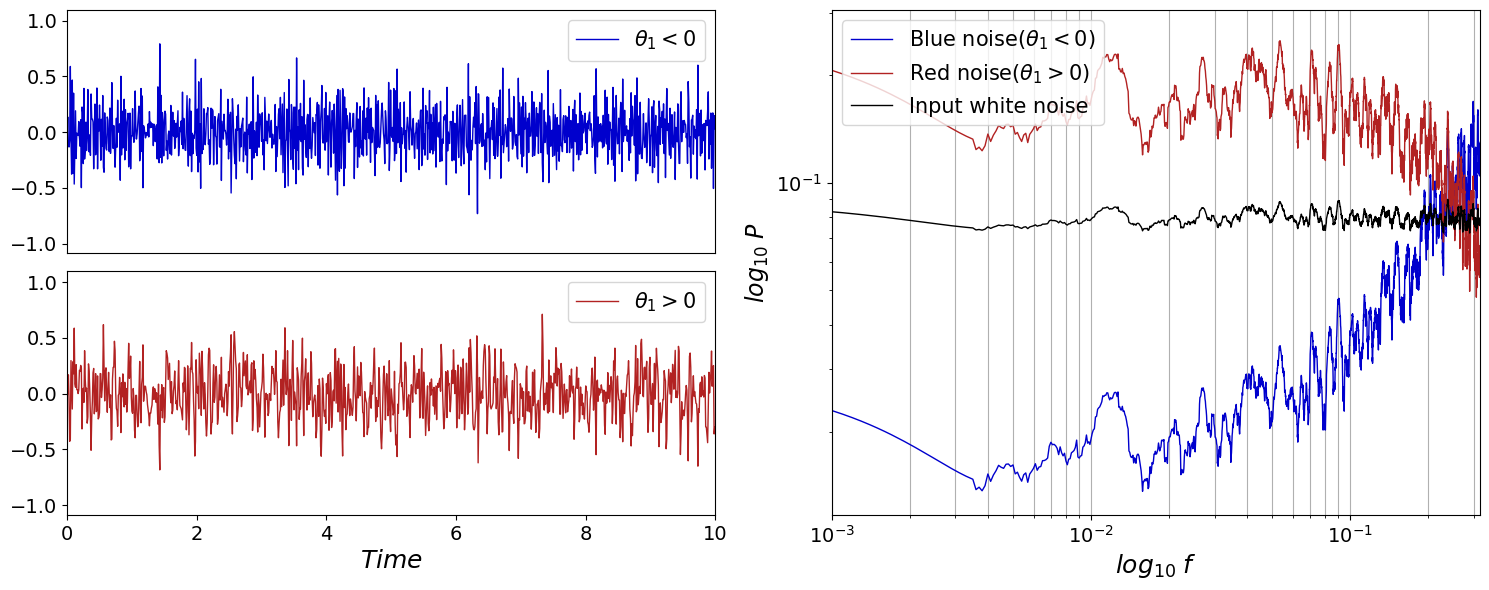

In [13]:

def ma1_process(num_steps, theta, sigma, noise=None):
    """
    Simulate an MA(1) process.

    Parameters:
        num_steps (int): Number of time steps.
        theta (float): MA(1) parameter.
        sigma (float): Standard deviation of the white noise.
        noise (numpy.ndarray or None): Optional noise array. Default is None.

    Returns:
        tuple: (numpy.ndarray, numpy.ndarray) Simulated MA(1) process and noise.
    """
    if noise is None:
        noise = np.random.normal(scale=sigma, size=num_steps)
    
    x = np.zeros(num_steps)
    x[0] = noise[0]  # The first value is just the noise itself
    
    for t in range(1, num_steps):
        x[t] = noise[t] + theta * noise[t-1]
    
    return x, noise



fig= plt.figure(figsize = [15, 6])

num_steps = 10000
sigma = 1
time = np.linspace(0, 10, num_steps)
np.random.seed(6)
noise = np.random.normal(0, 0.1, size=num_steps)
ma_neg, _ = ma1_process(num_steps, -2, 1.2, noise= noise)
ma_pos, _ = ma1_process(num_steps, 2, 1.2, noise= noise)

ax1 = fig.add_subplot(221,)
plt.plot(time*10, ma_neg, 'k-', lw=1, color = 'mediumblue', label = r'$\theta_1 < 0$')
plt.xlim(0, 10)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 14)
plt.gca().axes.get_xaxis().set_visible(False)


ax2 = fig.add_subplot(223, sharey = ax1)
plt.plot(time*10, ma_pos, 'k-', lw=1, color = 'firebrick',  label = r'$\theta_1 > 0$')
plt.xlim(0, 10)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 14)
plt.xlabel('$Time$', fontsize = 18)



ax3 = fig.add_subplot(122)
n = len(ma_neg)
yf = fft(ma_neg)
xf = fftfreq(n, 1)[:n//2]
power_spectrum = 2.0/n * np.abs(yf[:n//2])**2
plt.plot(xf[1:], savgol_filter(power_spectrum[1:], 70, 2), '-', lw = 1, color = 'mediumblue',label = r'Blue noise($\theta_1 < 0$)')


n = len(ma_pos)
yf = fft(ma_pos)
xf = fftfreq(n, 1)[:n//2]
power_spectrum = 2.0/n * np.abs(yf[:n//2])**2
plt.plot(xf[1:], savgol_filter(power_spectrum[1:], 70, 2), '-',  lw = 1, color = 'firebrick', label = r'Red noise($\theta_1 > 0$)')


n = len(noise)
yf = fft(noise)
xf = fftfreq(n, 1)[:n//2]
power_spectrum = 2.0/n * np.abs(yf[:n//2])**2
plt.plot(xf[1:], savgol_filter(power_spectrum[1:], 70, 2) + 0.6*10**-1, 'k-',  lw = 1, label = 'Input white noise')
plt.xscale('log')
plt.xlim(10**-3, 10**-0.5)
plt.yscale('log')
plt.xlabel(r'$log_{10}\; f $', fontsize = 18)
plt.ylabel(r'$log_{10}\;P $', fontsize = 17)
plt.legend(fontsize = 15)
plt.grid(axis='x', which='both')

plt.tick_params(labelsize = 14)
plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

def generate_ma_process(num_steps, theta, sigma):
    """
    Simulate an MA(1) process.

    Parameters:
        num_steps (int): Number of time steps.
        theta (float): MA(1) parameter.
        sigma (float): Standard deviation of the white noise.

    Returns:
        numpy.ndarray: Simulated MA process.
    """
    noise = np.random.normal(scale=sigma, size=num_steps)
    ma_process = lfilter([1, theta], [1], noise)
    return ma_process, noise

def generate_ar_process(num_steps, phi, sigma, impulse_response=False):
    """
    Simulate an AR process.

    Parameters:
        num_steps (int): Number of time steps.
        phi (array): AR parameters.
        sigma (float): Standard deviation of the white noise.
        impulse_response (bool): Whether to return the impulse response function.

    Returns:
        numpy.ndarray: Simulated AR process.
    """
    noise = np.random.normal(scale=sigma, size=num_steps)
    ar_process = lfilter([1], np.r_[1, -np.array(phi)], noise)
    
    if impulse_response:
        impulse = np.zeros(num_steps)
        impulse[0] = 1
        impulse_response = lfilter([1], np.r_[1, -np.array(phi)], impulse)
        return ar_process, impulse_response
    else:
        return ar_process

def generate_arma_process(num_steps, ar_params, ma_params, sigma):
    """
    Simulate an ARMA process.

    Parameters:
        num_steps (int): Number of time steps.
        ar_params (array): AR parameters.
        ma_params (array): MA parameters.
        sigma (float): Standard deviation of the white noise.

    Returns:
        numpy.ndarray: Simulated ARMA process.
    """
    noise = np.random.normal(scale=sigma, size=num_steps)
    arma_process = lfilter([1] + ma_params, [1] + [-ar for ar in ar_params], noise)
    return arma_process


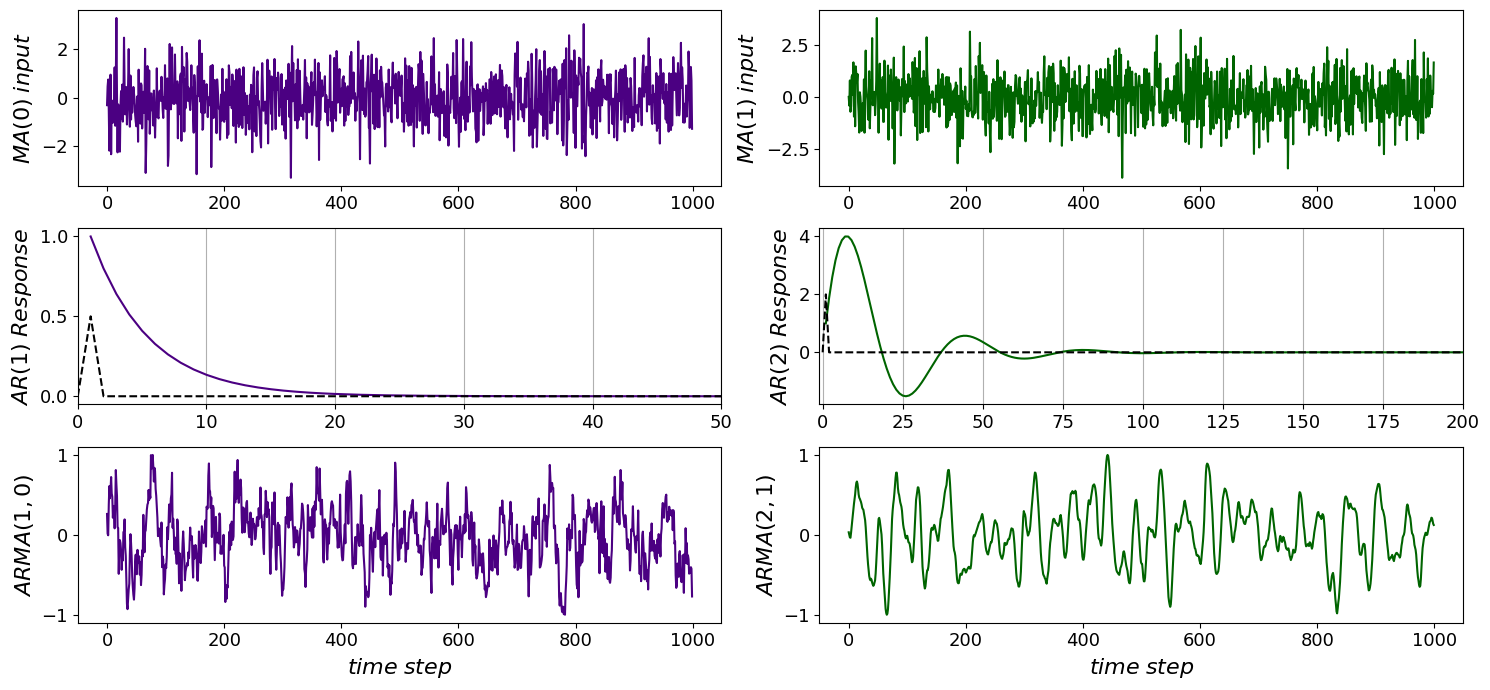

In [15]:
def plot_arma_processes(num_steps=1000, sigma=1.0):
    ar_params_1_0 = [0.8]  # AR(1) parameter for ARMA(1,0)
    ma_params_1_0 = []    # MA(0) parameter for ARMA(1,0) - no MA component
    ar_params_2_1 = [1.87, -0.9]  # AR(2) parameters for ARMA(2,1)
    ma_params_2_1 = [2]  # MA(1) parameter for ARMA(2,1)

    fig, axes = plt.subplots(3, 2, figsize=(15, 7))
    
    # ARMA(1,0) Process
    ma_process_1_0, noise_1_0 = generate_ma_process(num_steps, 0, sigma)
    ar_process_1_0, impulse_response_1_0 = generate_ar_process(num_steps, ar_params_1_0, sigma, impulse_response=True)
    arma_process_1_0 = generate_arma_process(num_steps, ar_params_1_0, ma_params_1_0, sigma)
    
    axes[0, 0].plot(noise_1_0, color = 'indigo')
    axes[0, 0].set_ylabel(r'$MA(0)\;input$', fontsize = 16)
    axes[0, 0].tick_params(labelsize = 13)
    
    axes[1, 0].plot(np.arange(1, len(impulse_response_1_0)+1, 1),impulse_response_1_0, color = 'indigo')
    axes[1, 0].set_xlim(0, 50)
    imp = np.ones_like(impulse_response_1_0)
    imp[1] = 1.5
    axes[1, 0].plot(imp - 1, 'k--')
    axes[1, 0].grid(axis = 'x')
    axes[1, 0].set_ylabel(r'$AR(1)\;Response$', fontsize = 16)
    axes[1, 0].tick_params(labelsize = 13)
    
    axes[2, 0].plot(-2*(arma_process_1_0- min(arma_process_1_0))/(max(arma_process_1_0)- min(arma_process_1_0)) + 1, color = 'indigo')
    axes[2, 0].set_xlabel(r'$time\;step$', fontsize = 16)
    axes[2, 0].set_ylabel(r'$ARMA(1,0)$', fontsize = 16)
    axes[2, 0].tick_params(labelsize = 13)
    # ARMA(2,1) Process
    ma_process_2_1, noise_2_1 = generate_ma_process(num_steps, ma_params_2_1[0], sigma)
    ar_process_2_1, impulse_response_2_1 = generate_ar_process(num_steps, ar_params_2_1, sigma, impulse_response=True)
    arma_process_2_1 = generate_arma_process(num_steps, ar_params_2_1, ma_params_2_1, sigma)
    
    axes[0, 1].plot(noise_2_1, color = 'darkgreen')
    axes[0, 1].set_ylabel(r'$MA(1)\;input$', fontsize = 16)
    axes[0, 1].tick_params(labelsize = 13)
    
    axes[1, 1].plot(np.arange(1, len(impulse_response_2_1)+1, 1),impulse_response_2_1, color = 'darkgreen')
    imp = np.ones_like(impulse_response_2_1)
    imp[1] = 3
    axes[1, 1].plot(imp - 1, 'k--',)
    axes[1, 1].set_xlim(-1, 200)
    axes[1, 1].grid(axis = 'x')
    axes[1, 1].set_ylabel(r'$AR(2)\;Response$', fontsize = 16)
    axes[1, 1].tick_params(labelsize = 13)
    
    axes[2, 1].plot(-2*(arma_process_2_1- min(arma_process_2_1))/(max(arma_process_2_1)- min(arma_process_2_1)) + 1, color = 'darkgreen')
    axes[2, 1].set_xlabel(r'$time\;step$', fontsize = 16)
    axes[2, 1].set_ylabel(r'$ARMA(2,1)$', fontsize = 16)
    axes[2, 1].tick_params(labelsize = 13)
    plt.tight_layout()
    plt.show()

# Run the function to plot the ARMA processes
plot_arma_processes()


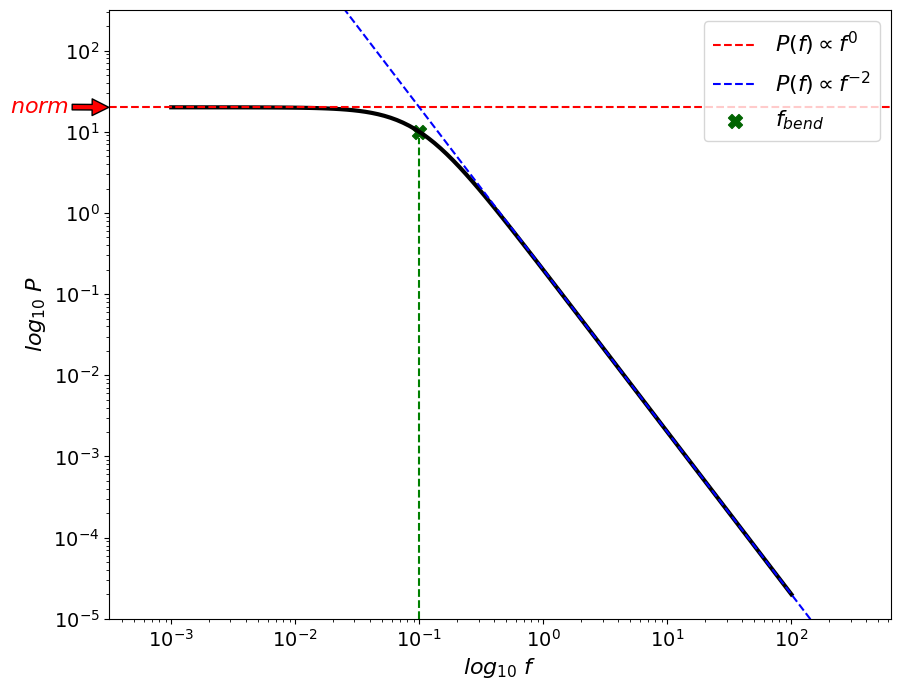

In [16]:
freq = np.logspace(-3, 2, 100)
ps = bend_pl(freq, 20, 0.1, 0, -2, 1)
plt.figure(figsize = [9, 7])
plt.plot(freq, ps, 'k-', lw=3)
plt.axhline(20, ls = '--', color='r', label = r'$P(f)\propto f^0$')

freq_line = np.logspace(-6, 3, 100)
plt.plot(freq_line, freq_line**-2/5, 'b--', label = r'$P(f)\propto f^{-2}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-5, 10**2.5)
plt.xlim(10**-3.5, 10**2.8)
plt.scatter(0.1, bend_pl(0.1,  20, 0.1, 0, -2, 1), color='darkgreen', marker = 'X', s=100, label = r'$f_{bend}$')
plt.tick_params(labelsize = 14)
plt.axvline(0.1, ymin = 10**-5, ymax=0.79, color = 'green', ls= '--')
plt.xlabel('$log_{10}\; f$', fontsize = 16)
plt.ylabel('$log_{10}\; P$', fontsize = 16)
plt.annotate('$norm$', 
            xy=(10**-3.5, 20), 
            xytext=(10**-4.3, 17), 
            arrowprops = dict(facecolor='r', shrink=0.01), fontsize = 16, color = 'red')

plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
plt.show()

In [17]:
def param_gen_alpha_beta(p, q, alpha_range = [-4, 1], beta_range = [-3, -2], sigma_range = [-0, 0.01]):
    '''
    Function to generate log_alpha, log_beta and log_sigma parameters given p and q values
    This function is same as used before, but also contains the log of \alpha_p and \beta_0 (=1)
    
    '''
    param_dict = {}
    for i in range(p):
        param_dict['log_alpha'+str(i)] = uniform.rvs(alpha_range[0], alpha_range[1] - alpha_range[0])
    
    param_dict['log_alpha'+str(p)] = 0
    param_dict['log_beta0'] = 0
    for i in range(q):
        param_dict['log_beta'+str(i+1)] = uniform.rvs(beta_range[0], beta_range[1] - beta_range[0])    
        
    param_dict['log_sigma'] = uniform.rvs(sigma_range[0], sigma_range[1] -sigma_range[0])
    
    return param_dict

def search_elements_with_pattern(arr, pattern):
    '''
    Just a function facilitate a filtering process below
    '''
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements


def return_alpha_vals(par_dict):
    '''
    function to return alpha values from a dict of log_alpha, log_beta, and log_sigma
    
    returned alpha is order as \alpha_p, \alpha_{p-1}.... \alpha_0, where \alpha_p = 1
    '''
    alpha_keys = search_elements_with_pattern(par_dict.keys(), 'alpha')

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(par_dict[key])
    alpha_vals =list(np.exp(np.array(alpha_vals)))
    alpha_vals.reverse()
    return alpha_vals

def return_beta_vals(par_dict):
    '''
    function to return alpha values from a dict of log_alpha, log_beta, and log_sigma
    
    returned beta is order as \beta_0, \beta_{1}.... \beta_q, where \beta_0 = 1
    '''
    beta_keys = search_elements_with_pattern(par_dict.keys(), 'beta')

    beta_vals = []
    for key in beta_keys:
        beta_vals.append(par_dict[key])
    beta_vals =list(np.exp(np.array(beta_vals)))
    return beta_vals


def create_complex_conjugates(real_parts, imag_parts):
    '''
    Function to create complex conjugates given real and imaginary part array
    '''
    complex_pairs = []
    for real, imag in zip(real_parts, imag_parts):
        z = complex(real, imag)
        z_conjugate = z.conjugate()
        complex_pairs.append((z, z_conjugate))
    return complex_pairs

def extract_real_imaginary(complex_numbers):
    '''
    Function to return real and imaginary parts of an array of complex numbers
    '''
    real_parts = []
    imaginary_parts = []
    for z in complex_numbers:
        real_parts.append(z.real)
        imaginary_parts.append(z.imag)
    return real_parts, imaginary_parts

def CARMA_PSD_pq(params, freq):
    '''
    Function to calculate the PSD of a CARMA processing the equation in Kelly et. al 2014
    Parameters:
    --------------------------------------------------------------------------------------
    params  :  dict of log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    freq    :  freq in which PSD is calculated.
    
    '''
    
    alpha_vals = return_alpha_vals(params)[::-1]
    beta_vals = return_beta_vals(params)
    p = len(alpha_vals)-1
    q = len(beta_vals)-1

    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(1j* freq)**u )

    PSD = 1**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

def celerite_term_PSD(a,  b, c, d, freq):
    num = np.sqrt(2/np.pi)*((a*c + b*d) * (c**2 + d**2) + (a*c - b*d) * np.power(freq,2))
    denom = np.power(freq, 4) + 2*(c**2 - d**2) * np.power(freq, 2) + np.power((c**2 + d**2),2)
    
    return  num/denom

def CARMA_celerite_PSD(a_array, b_array, c_array, d_array, p, freq):
    if p%2==0:
        celerite_sum = 0
        for (a, b, c, d) in zip(a_array, b_array, c_array, d_array):
            celerite_sum = celerite_sum + celerite_term_PSD(a, b, c, d, freq)
    else:
        celerite_sum = 0
        for (a, b, c, d) in zip(a_array[:-1], b_array[:-1], c_array[:-1], d_array[:-1]):
            celerite_sum = celerite_sum + celerite_term_PSD(a, b, c, d, freq)
        
        celerite_sum = celerite_sum + celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq)
    
    return celerite_sum


def lorentzian(center, width, freq):
    return 1/(1 + np.power( (freq+center)/width ,2))

def celerite_as_lorentzians(a, b, c, d, freq, implement = 1):
        
    if implement == 2:
        lorentzian_params = []

        term1 = (lorentzian(-1*d, c, freq) + lorentzian(d, c, freq)) * (a*c + b*d)/c**2    
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * (a*c + b*d)/c**2,   -1*d,   c])
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * (a*c + b*d)/c**2,    1*d,   c])

        term2 = (lorentzian(-1*d, c, freq) - lorentzian(d, c, freq)) * (freq * b)/c**2
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) * -1*(b)/c**2,   -1*d,   c])
        lorentzian_params.append([np.sqrt(1/(2*np.pi)) *  1*(b)/c**2,    1*d,   c])
        
        return (term1 - term2), lorentzian_params

        
    if implement == 1:
        lorentzian_comps = []

        term1 = lorentzian(-1*d, c, freq) * (a*c + b*d - freq*b)/c**2    
        lorentzian_comps.append(term1)
        

        term2 = lorentzian(   d, c, freq) * (a*c + b*d + freq*b)/c**2   
        lorentzian_comps.append(term2)        

        return (term1 + term2), lorentzian_comps
    

# def celerite_lorentzian_comp()

def CARMA_as_cel_lorentz(a_array, b_array, c_array, d_array, p, freq):
    if p%2==0:
        celerite_sum = 0
        true_lorentzians = []
        pseudo_lorentzians = []
        for (a, b, c, d) in zip(a_array, b_array, c_array, d_array):
            celerite_sum  = celerite_sum + celerite_as_lorentzians(a, b, c, d, freq,)[0]
            #lorentzian_parms = celerite_as_lorentzians(a, b, c, d, freq)[1]
            lorentzian_comps = celerite_as_lorentzians(a, b, c, d, freq)[1]
            for val in lorentzian_comps:
                pseudo_lorentzians.append(val)
            # true_lorentzians.append(lorentzian_parms[0][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[0][2], freq))
            # true_lorentzians.append(lorentzian_parms[1][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[1][2], freq))
            
            # pseudo_lorentzians.append(freq*lorentzian_parms[2][0]*lorentzian(lorentzian_parms[2][1], lorentzian_parms[2][2], freq))
            # pseudo_lorentzians.append(freq*lorentzian_parms[3][0]*lorentzian(lorentzian_parms[3][1], lorentzian_parms[3][2], freq))
    else:
        celerite_sum = 0
        true_lorentzians = []
        pseudo_lorentzians = []
        for (a, b, c, d) in zip(a_array[:-1], b_array[:-1], c_array[:-1], d_array[:-1]):
            celerite_sum  = celerite_sum + celerite_as_lorentzians(a, b, c, d, freq)[0]
            #lorentzian_parms = celerite_as_lorentzians(a, b, c, d, freq)[1]
            lorentzian_comps = celerite_as_lorentzians(a, b, c, d, freq)[1]
            for val in lorentzian_comps:
                pseudo_lorentzians.append(val)
            # true_lorentzians.append(lorentzian_parms[0][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[0][2], freq))
            # true_lorentzians.append(lorentzian_parms[1][0]*lorentzian(lorentzian_parms[0][1], lorentzian_parms[1][2], freq))
            
            # pseudo_lorentzians.append(freq*lorentzian_parms[2][0]*lorentzian(lorentzian_parms[2][1], lorentzian_parms[2][2], freq))
            # pseudo_lorentzians.append(freq*lorentzian_parms[3][0]*lorentzian(lorentzian_parms[3][1], lorentzian_parms[3][2], freq))
        
        celerite_sum = celerite_sum + celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq)
        pseudo_lorentzians.append(celerite_term_PSD(a_array[-1], b_array[-1], c_array[-1], d_array[-1],freq))
    
    return celerite_sum, true_lorentzians, pseudo_lorentzians

def CARMA_celerite_coeffs(alpha_beta_vals):
    alpha_vals = return_alpha_vals(alpha_beta_vals) # alpha_p,......., alpha_0
    beta_vals = return_beta_vals(alpha_beta_vals)   # beta_0, ...... beta_q
    
    p = len(alpha_vals)-1
    q = len(beta_vals)-1
    
    ARroots = np.roots(alpha_vals)
    ARroots = sorted(ARroots, key=lambda x: np.abs(x.imag), reverse=True)
    
    print(ARroots)
    coeffs = []
    for j in range(1, p+1):
        #print(ARroots[j-1])    
        
        num_beta_sum1 = 0
        for l in range(0, q+1):
            num_beta_sum1 = num_beta_sum1 + beta_vals[l]*np.power(ARroots[j-1], l)
            
        num_beta_sum2 = 0
        for l in range(0, q+1):
            num_beta_sum2 = num_beta_sum2 + beta_vals[l]*np.power(-1*ARroots[j-1], l)
            
        denom = -2*np.real(ARroots[j-1])
        for l in range(1, p+1):
            if l!=j:
                denom = denom * (ARroots[l-1] - ARroots[j-1]) * (ARroots[l-1].conjugate() + ARroots[j-1])   
        
        num = num_beta_sum1*num_beta_sum2
        
        coeff = num/denom
        coeffs.append(coeff)
        
    coeffs[-1] = np.real_if_close(coeffs[-1])
    a_array = []
    b_array = []
    c_array = []
    d_array = []
    #print(ARroots[0::2])
    for val, r in zip(coeffs[0::2], ARroots[0::2]):
        a_array.append(2*np.real(val))
        b_array.append(2*np.imag(val))
        c_array.append(-1*np.real(r))
        d_array.append(-1*np.imag(r))
    if p%2!=0:
        a_array[-1] = a_array[-1]/2
        b_array[-1] = b_array[-1]/2
    return a_array, b_array, c_array, d_array

def separate_positive_negative_data(x_data, data):


    # Separate positive and negative values
    positive_data = data[data > 0]
    negative_data = data[data < 0]

    # Generate x-axis values for positive and negative data
    x_positive = x_data[data > 0]
    x_negative = x_data[data < 0]

    # Create y-axis values for positive and negative data
    y_positive = positive_data
    y_negative = negative_data

    return x_positive, y_positive, x_negative, y_negative

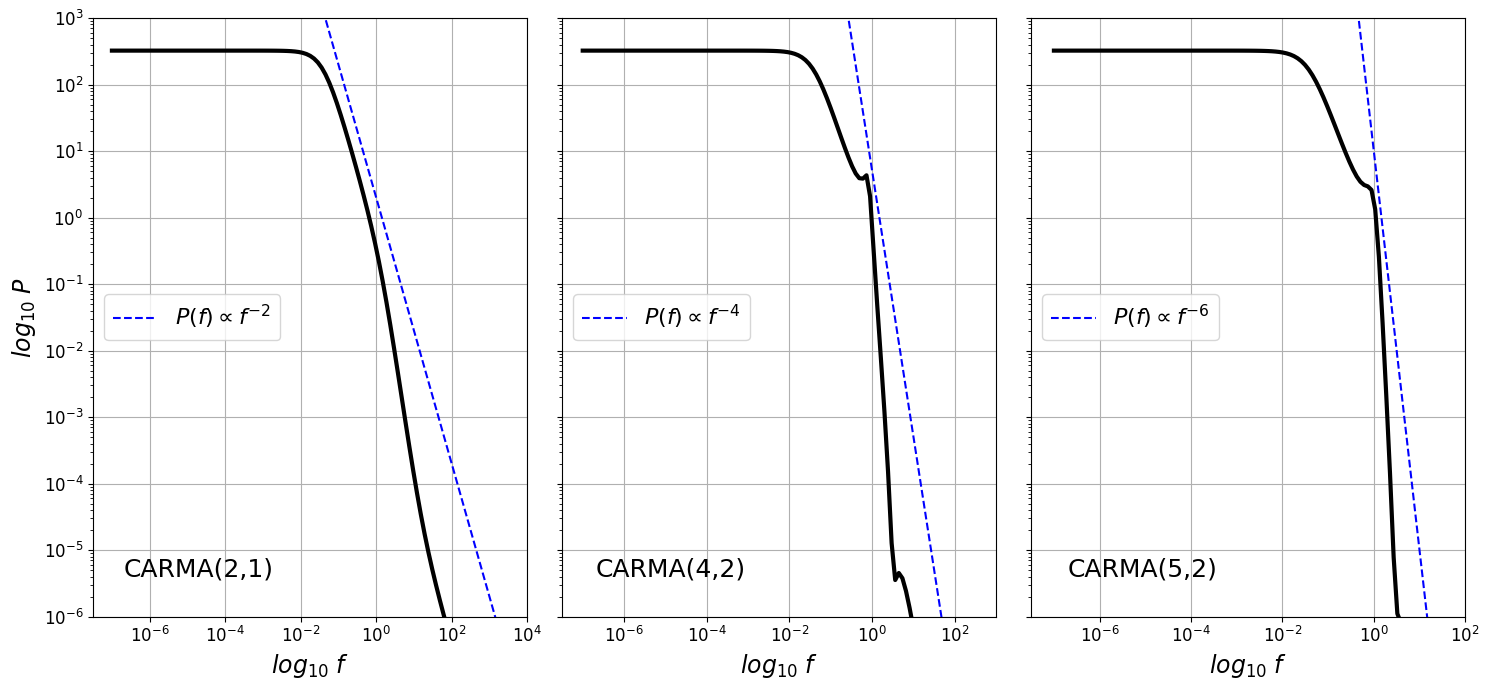

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [15, 7],sharey=True)
freqs = [np.logspace(-7,3,100), np.logspace(-7,1.6,100), np.logspace(-7,1,100)] 
xlims = [[10**-7.5, 10**4], [10**-7.5, 10**3],[10**-7.5, 10**2] ]

orders = [[2,1], [4,2], [5, 2]]
fac = [0.5, 0.2, 0.1]
for i, ax in enumerate([ax1, ax2, ax3]):
    np.random.seed(5)
    alpha_beta_vals =param_gen_alpha_beta(*orders[i])
    carmaPSD = CARMA_PSD_pq(alpha_beta_vals, freqs[i])
    ax.plot(freqs[i], carmaPSD, 'k-', lw =3)
    freq_line = np.logspace(-4, 5, 100)
    ax.plot(freq_line, freq_line**(2*(orders[i][1]-orders[i][0]))/fac[i], 'b--', label = r'$P(f)\propto f^{}$'.format("{"+str(2*(orders[i][1]-orders[i][0]))+"}"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(10**-6,10**3 )
    ax.set_xlim(*xlims[i])
    ax.legend(fontsize = 16)
    ax.grid()
    if i==0:
        ax.set_ylabel('$log_{10}\; P$', fontsize = 17)
    ax.set_xlabel('$log_{10}\; f$', fontsize = 17)
    ax.tick_params(labelsize = 12)
    ax.text(10**-6.7, 10**-5.4, 'CARMA('+ str(orders[i][0])+ "," + str(orders[i][1])+')', fontsize = 18)
plt.tight_layout()
plt.show()

In [19]:
alpha_beta_vals =param_gen_alpha_beta(2,1, alpha_range=[-7, 7], beta_range=[-7, 7], sigma_range=[0, 1])
a_array, b_array, c_array, d_array = CARMA_celerite_coeffs(alpha_beta_vals)

freq = np.logspace(-7,3,100)

celeritePSD = CARMA_celerite_PSD(a_array, b_array, c_array, d_array, 2 , freq)
celeritePSD_lorentz, true_lorentz, pseudo_lorentz = CARMA_as_cel_lorentz(a_array, b_array, c_array, d_array, 2 , freq)

carmaPSD = CARMA_PSD_pq(alpha_beta_vals, freq)


[(-0.006313595345827656+0.2410527775727755j), (-0.006313595345827656-0.2410527775727755j)]


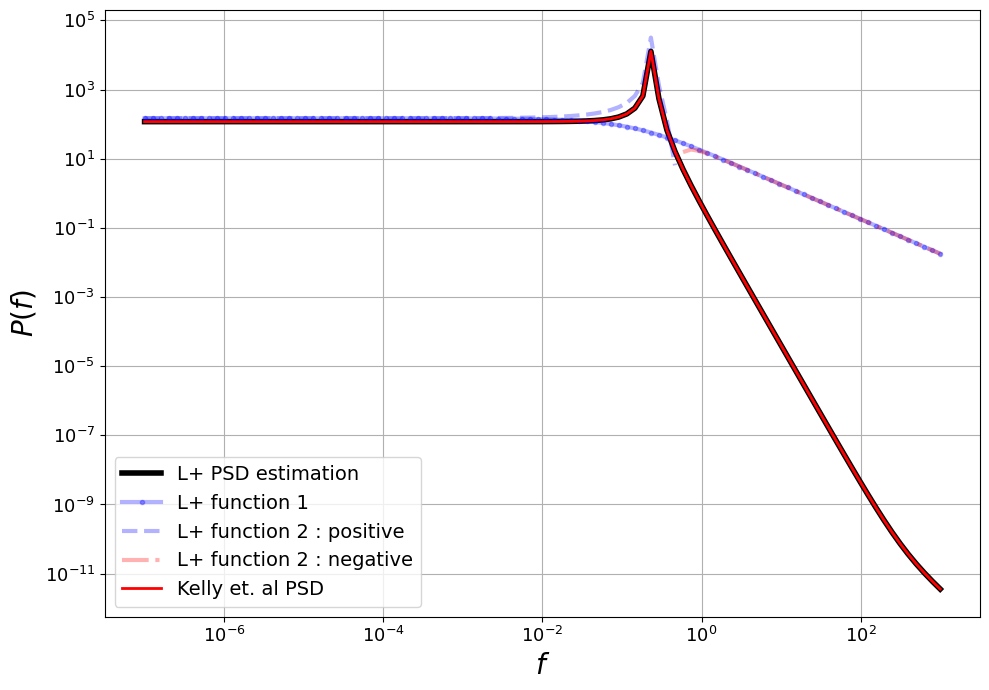

In [20]:
plt.figure(figsize=[10, 7])
#plt.plot(freq, celeritePSD_lorentz*2000, 'k-', lw=4, label = "'lorentzian+' PSD", alpha=0.2)
plt.plot(freq, celeritePSD, 'k-', lw=4, label = "L+ PSD estimation")

# sum = 0
# for i in range(len(true_lorentz)):
#     sum = sum + true_lorentz[i]
#     plt.plot(freq, true_lorentz[i], color='tab:blue' )

sum = 0
color = ['g', 'b', 'purple', 'red']
for i in range(len(pseudo_lorentz)):
    #sum = sum + pseudo_lorentz[i]
    x_pos, y_pos, x_neg, y_neg = separate_positive_negative_data(freq, pseudo_lorentz[i])
    if len(y_neg)==0:
        plt.plot(x_pos, y_pos, '.-', color = 'b', lw = 3, alpha= 0.3, label = 'L+ function '+str(i+1))
    else:
        if len(y_pos)>0:
            plt.plot(x_pos, y_pos, '--', color = 'b', lw = 3, alpha= 0.3, label = 'L+ function '+str(i+1)+' : positive')
        if len(y_neg)>0:
            plt.plot(x_neg, np.abs(y_neg), '-.', color = 'r', lw=3, alpha= 0.3, label = 'L+ function '+str(i+1)+' : negative')

plt.plot(freq, carmaPSD *celeritePSD[0]/carmaPSD[0], 'r-', lw=2, label = 'Kelly et. al PSD')
plt.legend(fontsize = 14, loc ='lower left')
#plt.plot(freq, sum, color = 'purple')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tick_params(labelsize=13)
plt.xlabel(r'$f$', fontsize=20)
plt.ylabel(r'$P(f)$', fontsize=20)
#plt.ylim(10**-8, 10**2)
plt.tight_layout()
#plt.savefig('plots/CARMA42_comp.png')

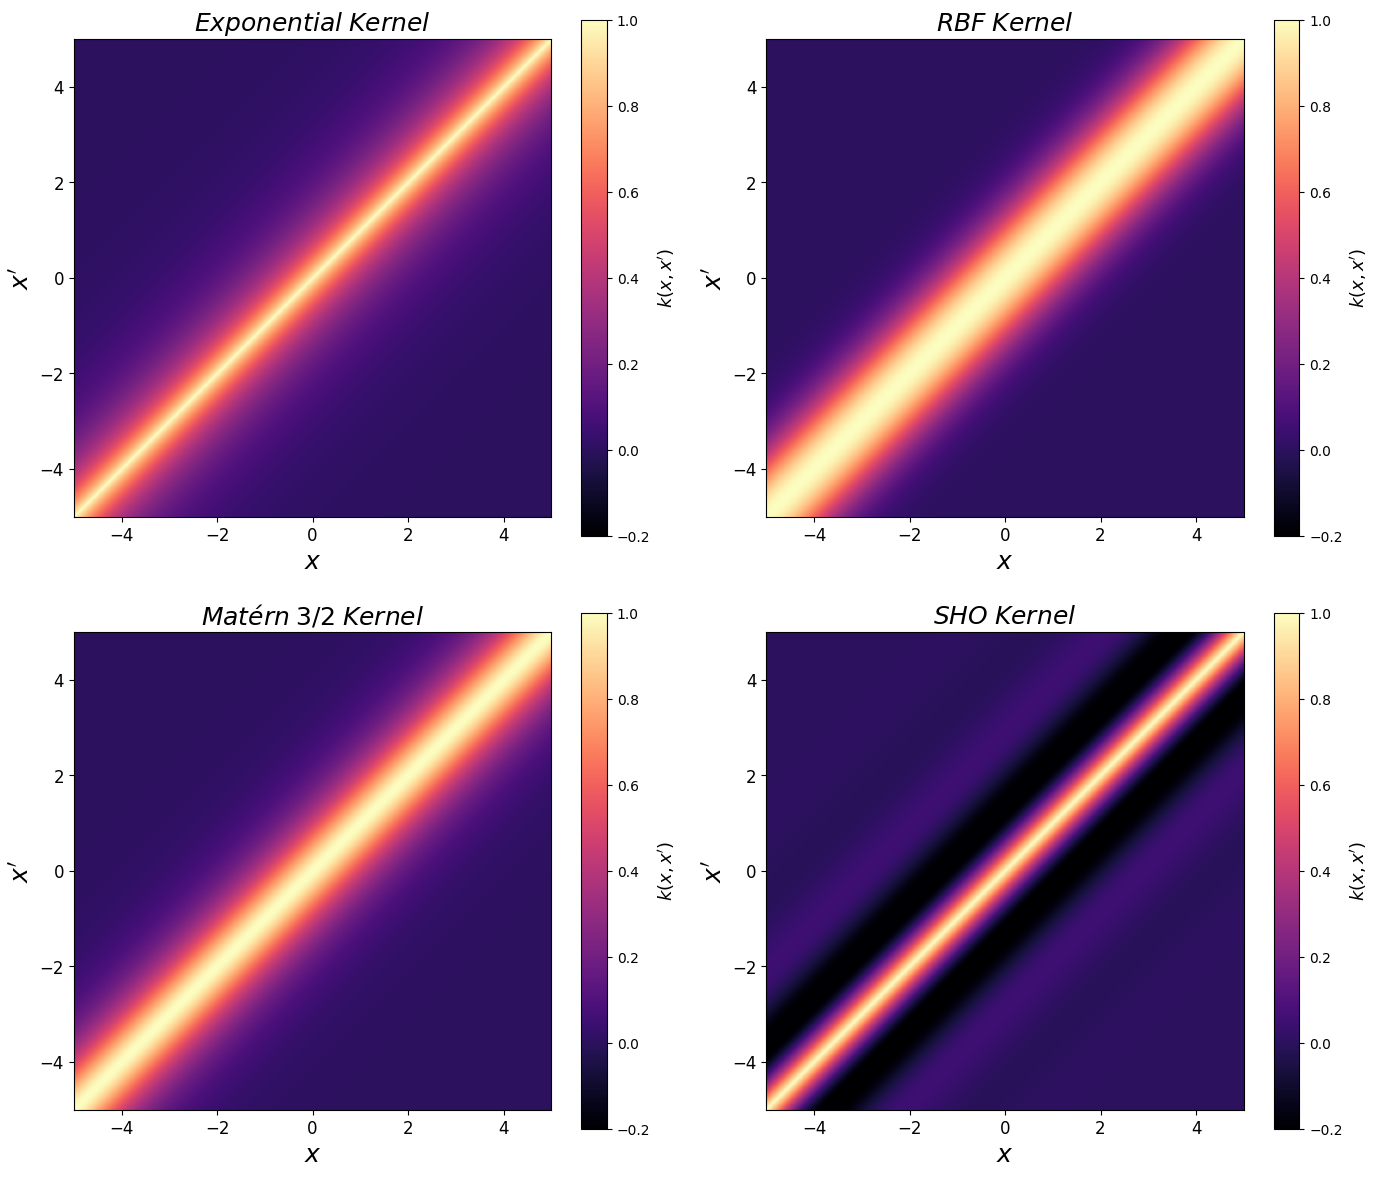

In [21]:

def exponential_kernel(x, y, length_scale):
    return np.exp(-np.abs(x - y) / length_scale)

def rbf_kernel(x, y, length_scale):
    return np.exp(-0.5 * ((x - y) ** 2) / length_scale ** 2)

def matern32_kernel(x, y, length_scale):
    sqrt3 = np.sqrt(3)
    dist = np.abs(x - y)
    return (1 + sqrt3 * dist / length_scale) * np.exp(-sqrt3 * dist / length_scale)

def sho_kernel(x, y, length_scale, omega):
    return np.exp(-np.abs(x - y) / length_scale) * np.cos(omega * np.abs(x - y))

# Define the grid for plotting
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
length_scale = 1.0
omega = 2.0  # Frequency for the SHO kernel

# Compute kernel values
exp_kernel_values = exponential_kernel(X, Y, length_scale)
rbf_kernel_values = rbf_kernel(X, Y, length_scale)
matern32_kernel_values = matern32_kernel(X, Y, length_scale)
sho_kernel_values = sho_kernel(X, Y, length_scale, omega)

# Plot the kernels
plt.figure(figsize=(14, 12))

vmin, vmax = -0.2, 1.0

plt.subplot(2, 2, 1)
plt.imshow(exp_kernel_values, vmin = vmin, vmax=vmax, extent=(-5, 5, -5, 5), origin='lower', cmap='magma')
plt.title('$Exponential\;Kernel$', fontsize = 18)
plt.colorbar().set_label(label='$k(x, x\')$',size=13)
plt.xlabel('$x$', fontsize = 18)
plt.ylabel('$x\'$', fontsize = 18)
plt.tick_params(labelsize = 12)

plt.subplot(2, 2, 2)
plt.imshow(rbf_kernel_values, vmin = vmin, vmax=vmax, extent=(-5, 5, -5, 5), origin='lower', cmap='magma')
plt.title('$RBF\;Kernel$', fontsize = 18)
plt.colorbar().set_label(label='$k(x, x\')$',size=13)
plt.xlabel('$x$', fontsize = 18)
plt.ylabel('$x\'$', fontsize = 18)
plt.tick_params(labelsize = 12)


plt.subplot(2, 2, 3)
plt.imshow(matern32_kernel_values,  vmin = vmin, vmax=vmax,extent=(-5, 5, -5, 5), origin='lower', cmap='magma')
plt.title('$Matérn\;3/2\;Kernel$', fontsize = 18)
plt.colorbar().set_label(label='$k(x, x\')$',size=13)
plt.xlabel('$x$', fontsize = 18)
plt.ylabel('$x\'$', fontsize = 18)
plt.tick_params(labelsize = 12)


plt.subplot(2, 2, 4)
plt.imshow(sho_kernel_values, vmin = vmin, vmax=vmax, extent=(-5, 5, -5, 5), origin='lower', cmap='magma')
plt.title('$SHO\;Kernel$', fontsize = 18)
plt.colorbar().set_label(label='$k(x, x\')$',size=13)
plt.tick_params(labelsize = 12)
plt.xlabel('$x$', fontsize = 18)
plt.ylabel('$x\'$', fontsize = 18)

plt.tight_layout()
plt.show()


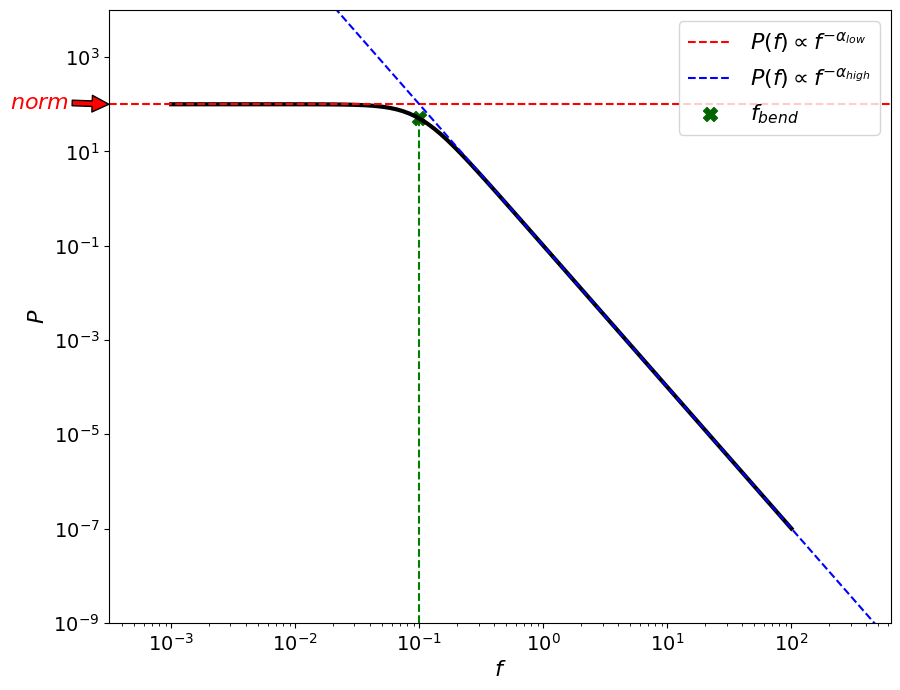

In [22]:
freq = np.logspace(-3, 2, 100)
ps = bend_pl(freq, 100, 0.1, 0, -3, 1)
plt.figure(figsize = [9, 7])
plt.plot(freq, ps, 'k-', lw=3)
plt.axhline(100, ls = '--', color='r', label = r'$P(f)\propto f^{-\alpha_{low}}$')

freq_line = np.logspace(-6, 3, 100)
plt.plot(freq_line, freq_line**-3/10, 'b--', label = r'$P(f)\propto f^{-\alpha_{high}}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-9, 10**4)
plt.xlim(10**-3.5, 10**2.8)
plt.scatter(0.1, bend_pl(0.1,  100, 0.1, 0, -2, 1), color='darkgreen', marker = 'X', s=100, label = r'$f_{bend}$')
plt.tick_params(labelsize = 14)
plt.axvline(0.1, ymin = 10**-5, ymax=0.815, color = 'green', ls= '--')
plt.xlabel('$f$', fontsize = 16)
plt.ylabel('$P$', fontsize = 16)
plt.annotate('$norm$', 
            xy=(10**-3.5, 100), 
            xytext=(10**-4.3, 80), 
            arrowprops = dict(facecolor='r', shrink=0.01), fontsize = 16, color = 'red')

plt.legend(fontsize = 16, loc = 'upper right')
plt.tight_layout()
plt.show()

In [23]:
def sin_curve(A, period, phase , time):
    return A * np.sin(2 * np.pi/ period * time + phase)


1352
9788


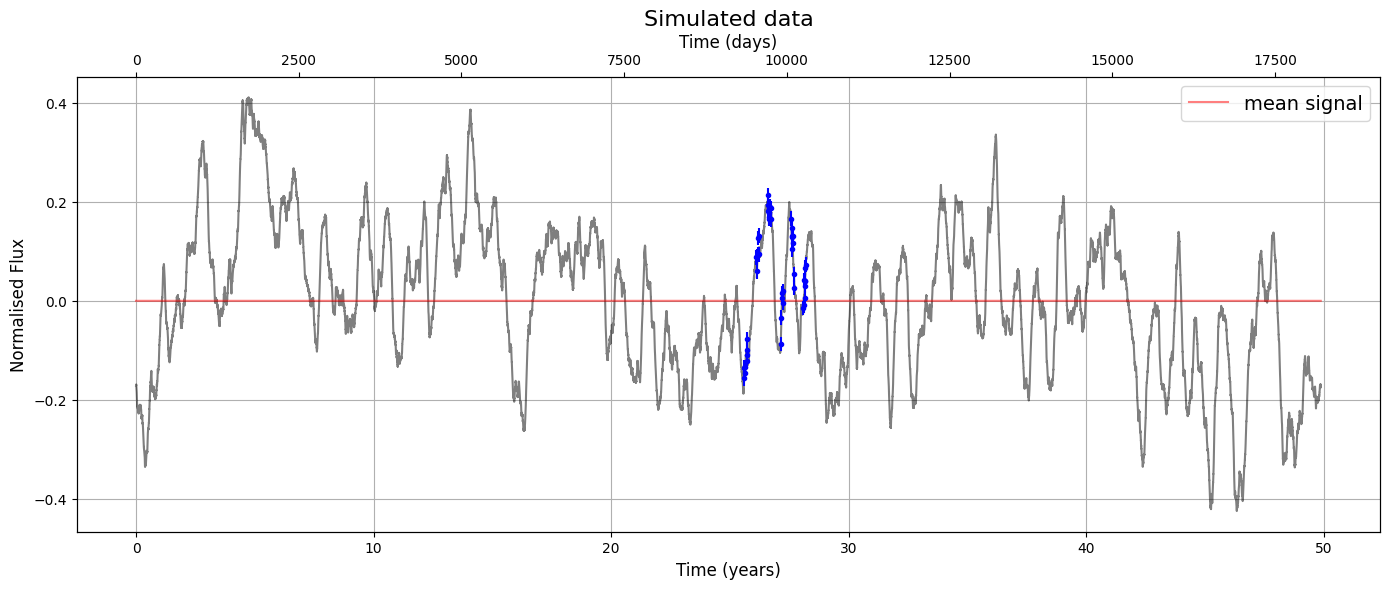

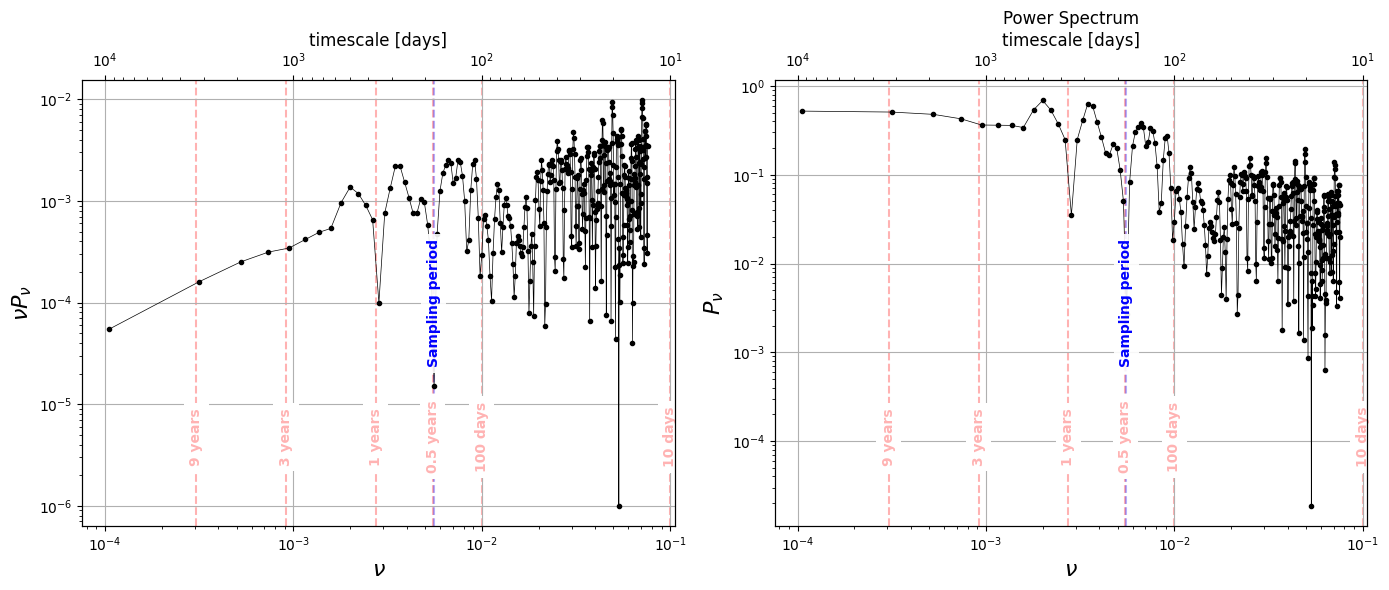

In [24]:
np.random.seed()
rand = 1352
print(rand)
l = LightCurveSampler(N=2**18, rms=0.15, dt = 100, simulatorSEED= rand ,mean = 0.0 ,  verbose=False)
l.load_powerspec(bend_pl, [200,  1/365,  -1,-3,10], plot=False)
l.LCsimulator()
np.random.seed() 
rand =  9788 #np.random.randint(0, 100000)

print(rand)
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 10, NumofWINDOW = 6, OBSperiod = 6, WINDOWwidth =60, samplerSEED=rand,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=True)


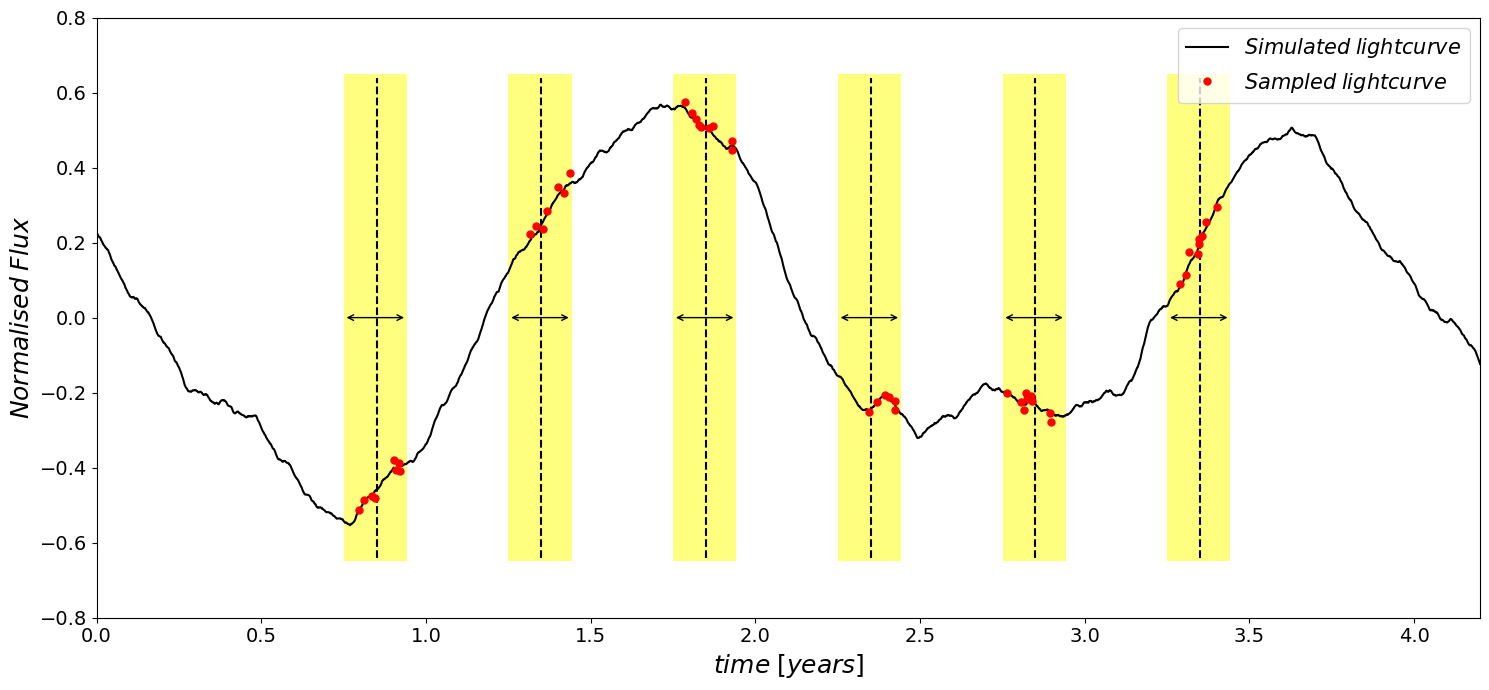

In [25]:
from matplotlib.patches import Rectangle


plt.figure(figsize = [15, 7])


low_lim = np.arange(25.66, 25.66 + 0.5*6, 0.5) - 40/365  - 24.8 
up_lim = np.arange(25.66, 25.66 + 0.5*6, 0.5) + 30/365  - 24.8 
center = np.arange(25.65, 25.65 + 0.5*6, 0.5)  - 24.8 
for low,up, cent in zip(low_lim, up_lim, center):
    #plt.axvline(low, ymin = 0.1, ymax = 0.9, ls = '--', color = 'k', alpha = 0.5)
    #plt.axvline(up, ymin = 0.1, ymax = 0.9, ls = '--', color = 'k', alpha = 0.5)
    plt.axvline(cent, ymin = 0.1, ymax = 0.9, ls = '--', color = 'k')
    plt.gca().add_patch(Rectangle((low, -0.65), 70/365, 1.3, facecolor = 'yellow', fill=True, alpha = 0.5))
    plt.annotate('', xy=(low,0), xytext=(up,0), arrowprops=dict(arrowstyle='<->'))

    
plt.plot(lc.time/365  - 24.8 , lc.counts+ sin_curve(0.375, 2, 0, lc.time/365 ), 'k-', label = '$Simulated\;lightcurve$')
plt.plot(simTIME  - 24.8 ,  simLC + sin_curve(0.375, 2, 0, simTIME, ), 'r.', markersize =10, label = '$Sampled\;lightcurve$')
plt.xlim(24.8  - 24.8 , 29  - 24.8 )
plt.ylim(-0.8, 0.8)
plt.xlabel(r'$time\;[years]$', fontsize = 18)
plt.ylabel(r'$Normalised\;Flux$', fontsize = 18)
plt.legend(fontsize= 15)
plt.tick_params(labelsize = 14)
plt.tight_layout()
plt.show()

# results and discussion

In [28]:
from plotter import datacollector, statPLOTS
import json
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde




# bend freqeuncy reconstruction

In [29]:
highALPHA_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_2_4_low_alpha_0_1.csv',
                         json_files_path='json_files/final/high_alpha_low_alpha/final/')

Collected all json files...


Gathering data from json files to dataframe:   0%|          | 1/1200 [00:00<05:00,  3.99it/s]

Gathering data from json files to dataframe: 100%|██████████| 1200/1200 [03:13<00:00,  6.21it/s]


In [30]:
highALPHA_plotter = statPLOTS(highALPHA_simdata)


In [31]:
highALPHA_simdata

ID  simSEED  sampleSEED   rms  noiseSIGMA  bendfreq  lowalpha  \
0     1000.0  45311.0     18817.0  0.15       0.015   0.00274       0.0   
1     1001.0  45311.0     18817.0  0.15       0.015   0.00274      -1.0   
2     1002.0  63783.0     53906.0  0.15       0.015   0.00274       0.0   
3     1003.0  63783.0     53906.0  0.15       0.015   0.00274      -1.0   
4     1004.0  84437.0     53792.0  0.15       0.015   0.00274       0.0   
...      ...      ...         ...   ...         ...       ...       ...   
1195  2195.0  44848.0     29409.0  0.15       0.015   0.00274      -1.0   
1196  2196.0  49041.0     30237.0  0.15       0.015   0.00274       0.0   
1197  2197.0  49041.0     30237.0  0.15       0.015   0.00274      -1.0   
1198  2198.0  75119.0     75906.0  0.15       0.015   0.00274       0.0   
1199  2199.0  75119.0     75906.0  0.15       0.015   0.00274      -1.0   

      highalpha  sharpness  NightsperWINDOW  ...  OBPLsine10_log_Z_uncert  \
0          -2.0       10.0               20  ...                 0.184203   
1          -2.0       10.0               20  ...                 0.158103   
2          -2.0       10.0               20  ...                 0.162775   
3          -2.0       10.0               20  ...                 0.153482   
4          -2.0       10.0               20  ...                 0.159011   
...         ...        ...              ...  ...                      ...   
1195       -4.0       10.0               20  ...                 0.157212   
1196       -4.0       10.0               20  ...                 0.165991   
1197       -4.0       10.0               20  ...                 0.166695   
1198       -4.0       10.0               20  ...                 0.158089   
1199       -4.0       10.0               20  ...                 0.154621   

      OBPLsine10_bf  OBPLsine10_alpha_h  OBPLsine10_t0  DRW_DRWsine_bayes  \
0         15.527646            3.004705       1.015902          26.765602   
1          1.121123            2.159046       2.887471         136.080159   
2          1.221849            1.907477       2.147605         121.852829   
3          1.517982            2.471363       4.206312         103.802518   
4          1.062062            2.001315       2.257556         109.932469   
...             ...                 ...            ...                ...   
1195       0.698823            3.316937       4.313356          15.892245   
1196       0.958194            3.651886       2.876603           4.114089   
1197       1.047125            3.541462       3.161503          32.485729   
1198       1.288699            3.299311       3.556426          32.506245   
1199       1.520961            2.802511       3.804926         156.648305   

      CARMA21_CARMA21sine_bayes  OBPL10_OBPLsine10_bayes  DRWsine_bool  \
0                     11.921584                22.550868             0   
1                     90.580142                56.949283            -1   
2                     72.937262               102.023488            -1   
3                     45.659262                58.389170            -1   
4                     21.102960                79.626550            -1   
...                         ...                      ...           ...   
1195                  12.866850                23.646835             0   
1196                  34.887759                47.089813             0   
1197                  41.324104                23.381149             0   
1198                 220.234473               129.371440             0   
1199                 133.376386               192.839497            -1   

      CARMA21sine_bool  OBPLsine_bool  
0                    0              0  
1                    0              0  
2                    0             -1  
3                    0              0  
4                    0              0  
...                ...            ...  
1195                 0              0  
1196                 0              0  
1197      

In [32]:
highalpha_array = list(set(highALPHA_simdata.highalpha.to_numpy()))
highalpha_array.sort()
highalpha_array.reverse()

In [33]:
highalpha_croped = highalpha_array


IndexError: index 6 is out of bounds for axis 0 with size 6

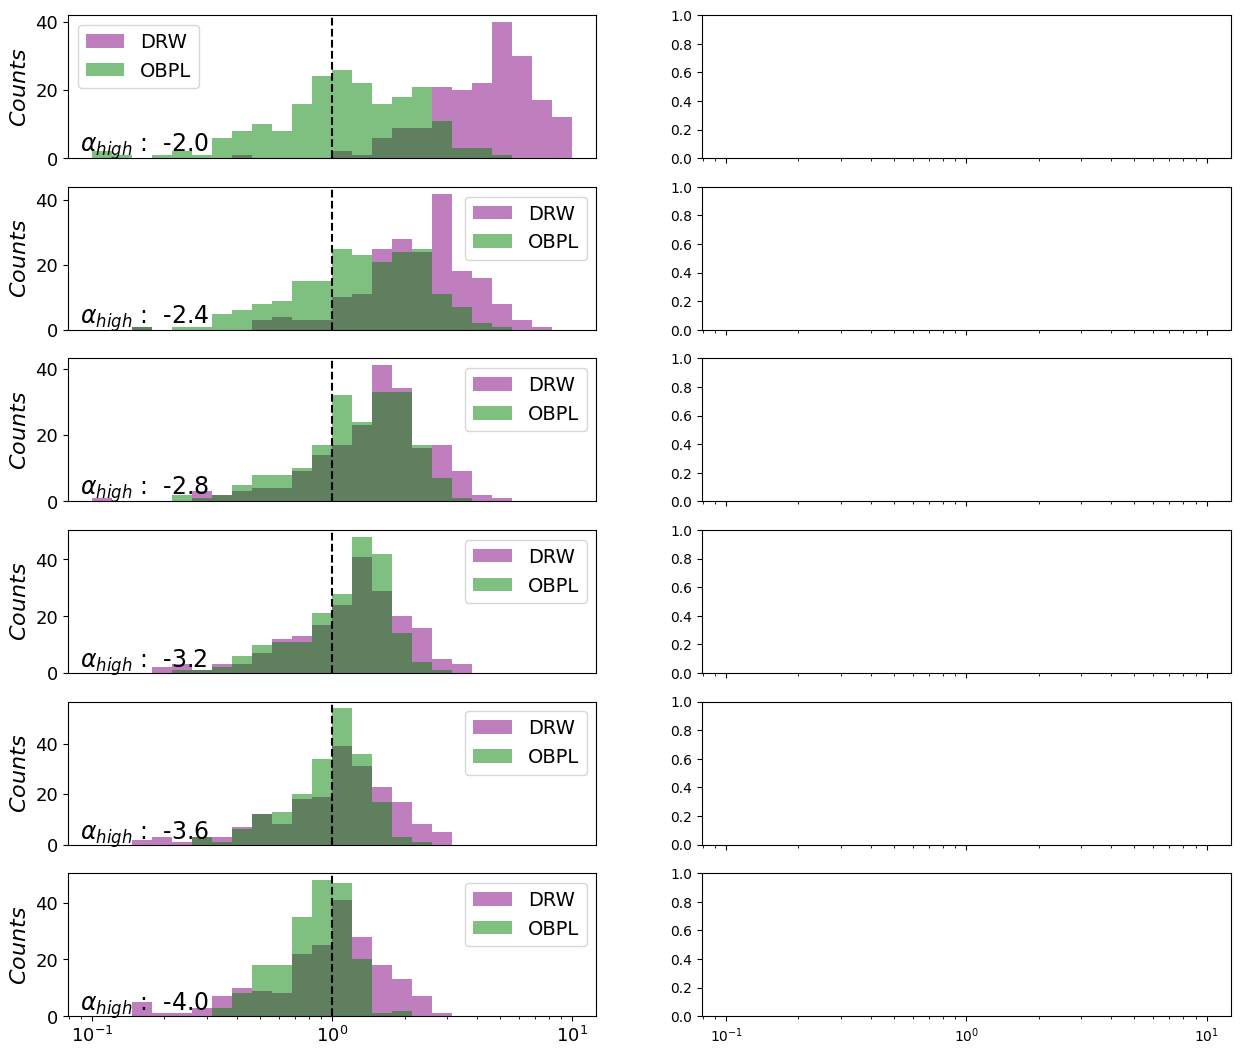

In [ ]:
def scaler(array, a, b):
    return (b-a) * (array - np.min(array))/(np.max(array)- np.min(array)) + a

fig, ax = plt.subplots(6, 2, figsize= [15, 13], sharex = True, sharey=False)
highalpha_croped = highalpha_array[0::1]
highalpha_croped.append(-4)
for i in range(len(highalpha_croped)):
    simDATA_filterd = highALPHA_simdata.loc[(highALPHA_simdata.highalpha ==highalpha_croped[i]) ]
    
    counts, bins,_ = ax[i].hist(simDATA_filterd.DRW_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'purple', label = 'DRW')

    counts, bins,_ =  ax[i].hist(simDATA_filterd.OBPL10_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'green',label = 'OBPL')
    #ax[i].plot(xs,scaler(density(xs), 0, max(counts)), '-', color = 'tab:orange')
    
    
    ax[i].axvline(0.00274*365, ls = '--',color = 'k')
    if i != 5: 
        ax[i].axes.get_xaxis().set_visible(False)
    ax[i].legend(fontsize = 14)
    ax[i].text(10**-1.05, 2, r'$\alpha_{high}$ :  ' + str(np.round(highalpha_croped[i], decimals = 2)), fontsize = 17)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()

In [ ]:
def histogram_thing(param_val_array, bin_edges):
    np.random.seed(0)
    posterior_samples = np.array(param_val_array)

    def generate_sample_set(posterior_samples):
        return [np.random.choice(samples) for samples in posterior_samples]


    N = 2000
    sample_sets = [generate_sample_set(posterior_samples) for _ in range(N)]

    #bins = 25
    #all_samples = [sample for sample_set in sample_sets for sample in sample_set]
    #bin_edges = np.linspace(1.5, 4.1, 23)

    all_histograms = np.array([np.histogram(sample_set, bins=bin_edges)[0] for sample_set in sample_sets])

    mean_hist = np.mean(all_histograms, axis=0)
    std_hist = np.std(all_histograms, axis=0)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    
    return mean_hist, std_hist, bin_centers, all_histograms

-2.0
-2.4444444444444446
-2.888888888888889
-3.333333333333333
-3.7777777777777777
-4


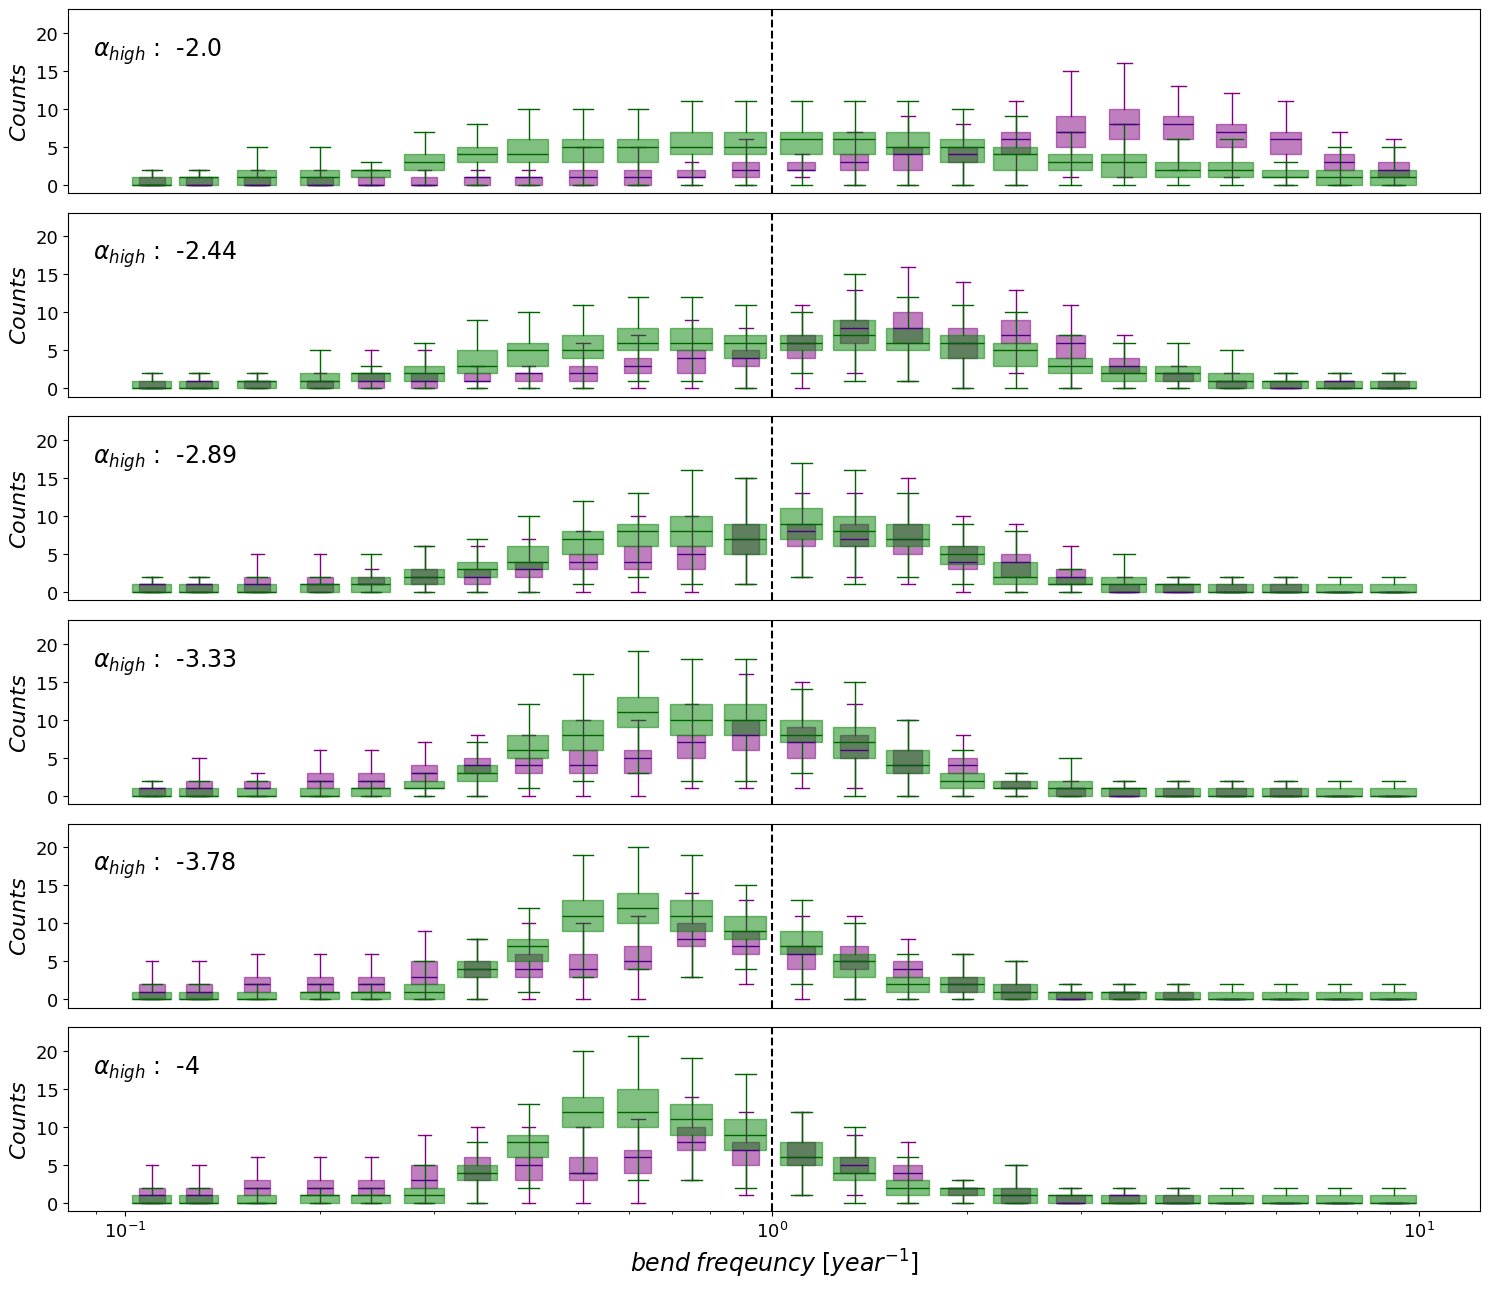

In [ ]:

fig, ax = plt.subplots(6, 1, figsize= [15, 13], sharex = True, sharey=True)

highalpha_array = list(set(highALPHA_simdata.highalpha.to_numpy()))
highalpha_array.sort()
highalpha_array.reverse()

highalpha_croped = highalpha_array[0::2]
highalpha_croped.append(-4)
for i in range(len(highalpha_croped)):
    simDATA_filterd = highALPHA_simdata.loc[highALPHA_simdata.highalpha ==highalpha_croped[i]]

    IDlist = simDATA_filterd.ID.to_numpy()
    print(highalpha_croped[i])
    OBPL_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/highalpha_2_4/' + str(int(val)) + '_OBPL10.json')
        OBPL_bf_val_array.append(jfile['log_bend_freq'][0:5600])
    DRW_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/highalpha_2_4/' + str(int(val)) + '_DRW.json')
        DRW_bf_val_array.append(jfile['log_bend_freq'][0:5600])

    DRW_mean_bf, DRW_std_bf, DRW_bin_centers, DRW_all_histograms = histogram_thing(np.power(10, DRW_bf_val_array), bin_edges = np.logspace(-1, 1, 25))
    OBPL_mean_bf, OBPL_std_bf, OBPL_bin_centers,  OBPL_all_histograms = histogram_thing(np.power(10, OBPL_bf_val_array), bin_edges = np.logspace(-1, 1, 25))

   
    #ax[i].hist(all_samples, bins=bin_edges, alpha=0.7,  color='blue', edgecolor='black', label='Histogram of Samples')
    #ax[i].errorbar(bin_centers, mean_hist, yerr=std_hist, fmt='o', color='red', ecolor='red', capsize=5, label='Mean and Std Dev of Histograms')
    whiskerprops_dict = dict(color = 'purple')
    capprops_dict = dict(color = 'purple')
    medianprops_dict = dict(color = 'indigo')
    bplot = ax[i].boxplot(DRW_all_histograms, positions=np.round(DRW_bin_centers, decimals=2), 
                          widths=0.1*np.logspace(-1, 1, np.shape(DRW_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    
    for patch in bplot['boxes']:
        patch.set_color('purple')
        patch.set_alpha(0.5)
        
    whiskerprops_dict = dict(color = 'darkgreen')
    capprops_dict = dict(color = 'darkgreen')
    medianprops_dict = dict(color = 'darkgreen')
    bplot = ax[i].boxplot(OBPL_all_histograms, positions=np.round(OBPL_bin_centers, decimals=2), 
                          widths=0.15*np.logspace(-1, 1, np.shape(OBPL_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_color('green')
        patch.set_alpha(0.5)
        
        
    ax[i].axvline(0.00274*365, ls = '--',color = 'k')
    if i != 5: 
        ax[i].axes.get_xaxis().set_visible(False)
    #ax[i].legend(fontsize = 14)
    ax[i].text(10**-1.05, 17, r'$\alpha_{high}$ :  ' + str(np.round(highalpha_croped[i], decimals = 2)), fontsize = 17)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()




In [ ]:
all_params_simdata = datacollector(csv_file_path= 'simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_14_period_0.75_6_A1_0.075_0.375_bendfreq_2_0.25.csv',
                         json_files_path='json_files/all_study_part1/outputs/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 6800/6800 [08:17<00:00, 13.66it/s]


In [ ]:
bend_freq_array = list(set(all_params_simdata.bendfreq.to_numpy()))
bend_freq_array.sort()
bend_freq_array

[0.0013698630136986, 0.0019339242546333, 0.0032876712328767, 0.010958904109589]

0.0013698630136986
0.0019339242546333
0.0032876712328767
0.010958904109589


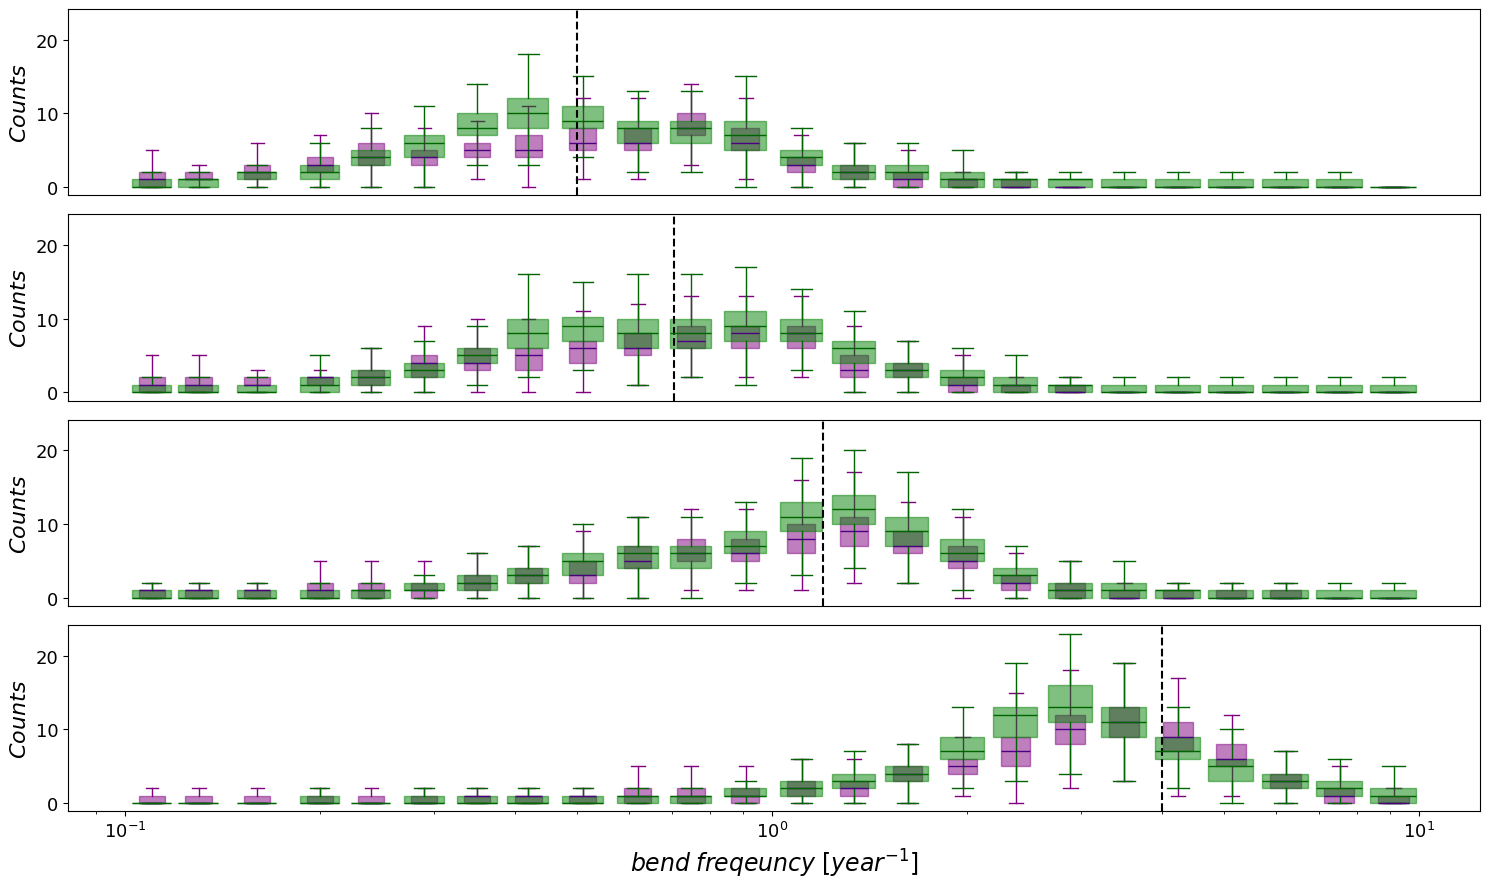

In [ ]:

fig, ax = plt.subplots(4, 1, figsize= [15, 9], sharex = True, sharey=True)

bend_freq_array = list(set(all_params_simdata.bendfreq.to_numpy()))
bend_freq_array.sort()
bend_freq_array

for i in range(len(bend_freq_array)):
    simDATA_filterd = all_params_simdata.loc[(all_params_simdata.bendfreq == bend_freq_array[i]) & (all_params_simdata.A1 == 0)]

    IDlist = simDATA_filterd.ID.to_numpy()
    print(bend_freq_array[i])
    OBPL_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/all_study_part1/outputs/' + str(int(val)) + '_OBPL10.json')
        OBPL_bf_val_array.append(jfile['log_bend_freq'][0:5600])
    DRW_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/all_study_part1/outputs/' + str(int(val)) + '_DRW.json')
        DRW_bf_val_array.append(jfile['log_bend_freq'][0:5600])

    DRW_mean_bf, DRW_std_bf, DRW_bin_centers, DRW_all_histograms = histogram_thing(np.power(10, DRW_bf_val_array), bin_edges = np.logspace(-1, 1, 25))
    OBPL_mean_bf, OBPL_std_bf, OBPL_bin_centers,  OBPL_all_histograms = histogram_thing(np.power(10, OBPL_bf_val_array), bin_edges = np.logspace(-1, 1, 25))

   
    #ax[i].hist(all_samples, bins=bin_edges, alpha=0.7,  color='blue', edgecolor='black', label='Histogram of Samples')
    #ax[i].errorbar(bin_centers, mean_hist, yerr=std_hist, fmt='o', color='red', ecolor='red', capsize=5, label='Mean and Std Dev of Histograms')
    whiskerprops_dict = dict(color = 'purple')
    capprops_dict = dict(color = 'purple')
    medianprops_dict = dict(color = 'indigo')
    bplot = ax[i].boxplot(DRW_all_histograms, positions=np.round(DRW_bin_centers, decimals=2), 
                          widths=0.1*np.logspace(-1, 1, np.shape(DRW_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    
    for patch in bplot['boxes']:
        patch.set_color('purple')
        patch.set_alpha(0.5)
        
    whiskerprops_dict = dict(color = 'darkgreen')
    capprops_dict = dict(color = 'darkgreen')
    medianprops_dict = dict(color = 'darkgreen')
    bplot = ax[i].boxplot(OBPL_all_histograms, positions=np.round(OBPL_bin_centers, decimals=2), 
                          widths=0.15*np.logspace(-1, 1, np.shape(OBPL_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_color('green')
        patch.set_alpha(0.5)
        
        
    ax[i].axvline(bend_freq_array[i]*365, ls = '--',color = 'k')
    if i != 3: 
        ax[i].axes.get_xaxis().set_visible(False)
    #ax[i].legend(fontsize = 14)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()




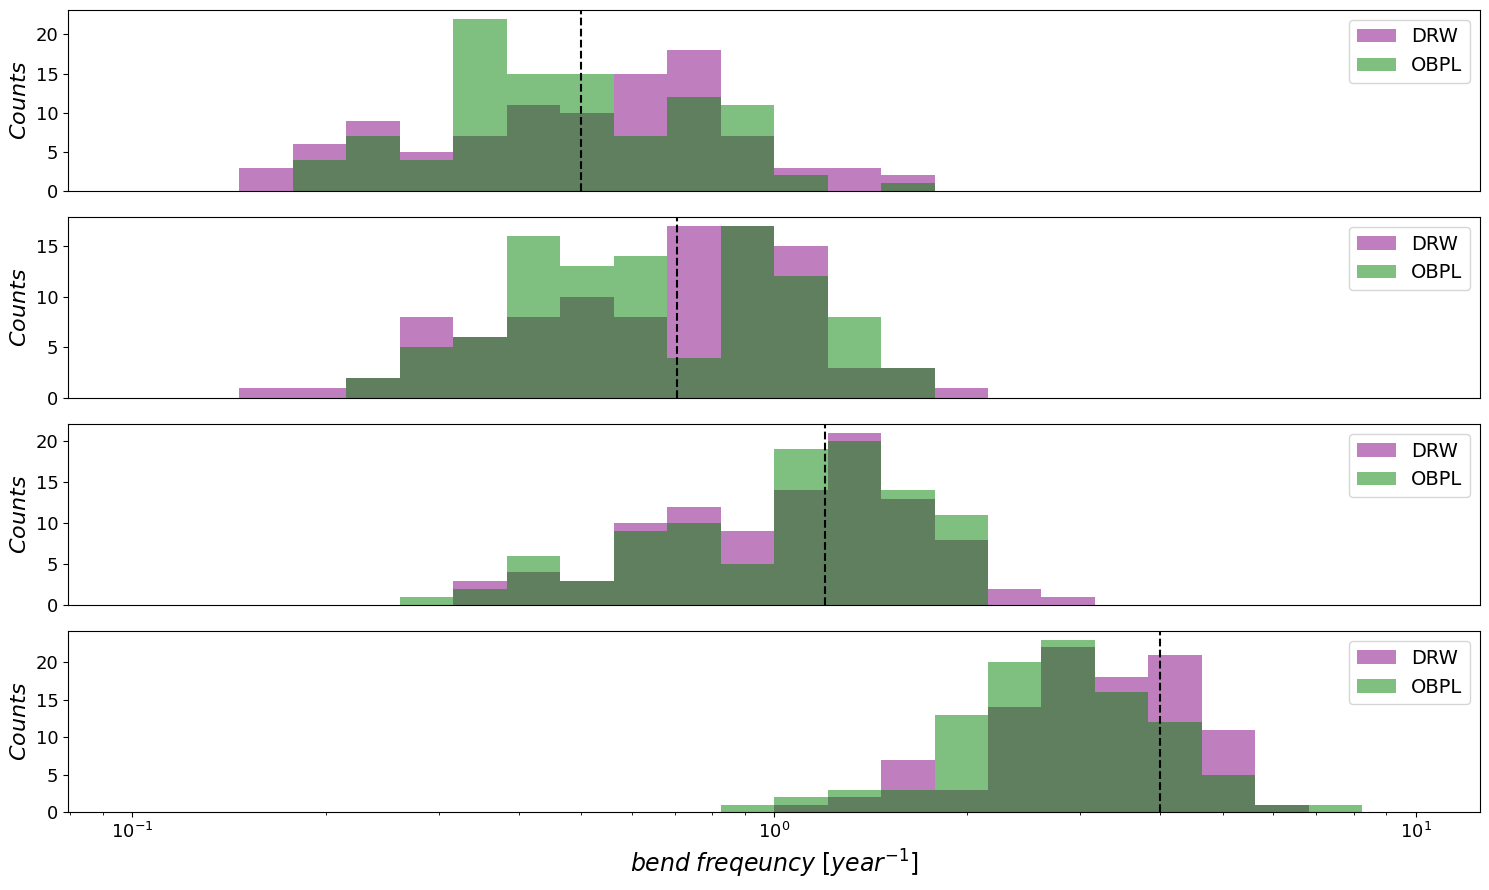

In [ ]:
fig, ax = plt.subplots(4, 1, figsize= [15, 9], sharex = True, sharey=False)

for i in range(len(bend_freq_array)):
    simDATA_filterd = all_params_simdata.loc[(all_params_simdata.bendfreq ==bend_freq_array[i]) & (all_params_simdata.A1 == 0)]

    # density = gaussian_kde(simDATA_filterd.DRW_bf)    
    # xs = np.linspace(0.1,10,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    counts, bins,_ = ax[i].hist(simDATA_filterd.DRW_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'purple', label = 'DRW')
    #ax[i].plot(xs,scaler(density(xs), 0, max(counts)), '-', color = 'tab:blue')
    
    # density = gaussian_kde(simDATA_filterd.OBPL10_bf)    
    # xs = np.linspace(0.1,10,200)
    # density._compute_covariance()
    counts, bins,_ =  ax[i].hist(simDATA_filterd.OBPL10_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'green',label = 'OBPL')
    #ax[i].plot(xs,scaler(density(xs), 0, max(counts)), '-', color = 'tab:orange')
    
    
    ax[i].axvline(bend_freq_array[i]*365, ls = '--',color = 'k')
    if i != 3: 
        ax[i].axes.get_xaxis().set_visible(False)
    ax[i].legend(fontsize = 14)
    #ax[i].text(10**-1.05, 2, r'$\alpha_{high}$ :  ' + str(np.round(bend_freq_array[i], decimals = 2)), fontsize = 17)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()

In [ ]:
OBSlength_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_4_20.csv',
                         json_files_path='json_files/final/numWIND/numWIND/')

Collected all json files...


Gathering data from json files to dataframe:   0%|          | 0/900 [00:00<?, ?it/s]

Gathering data from json files to dataframe: 100%|██████████| 900/900 [01:19<00:00, 11.31it/s]


In [ ]:
OBSlength_simdata

ID  simSEED  sampleSEED   rms  noiseSIGMA  bendfreq  lowalpha  \
0    1000.0  97207.0     74935.0  0.15       0.015   0.00274      -1.0   
1    1001.0  90142.0     73109.0  0.15       0.015   0.00274      -1.0   
2    1002.0  82063.0     85678.0  0.15       0.015   0.00274      -1.0   
3    1003.0  80502.0      3504.0  0.15       0.015   0.00274      -1.0   
4    1004.0  16552.0     47911.0  0.15       0.015   0.00274      -1.0   
..      ...      ...         ...   ...         ...       ...       ...   
895  1895.0  72319.0        56.0  0.15       0.015   0.00274      -1.0   
896  1896.0  47595.0     56942.0  0.15       0.015   0.00274      -1.0   
897  1897.0  61554.0     80932.0  0.15       0.015   0.00274      -1.0   
898  1898.0  28520.0     51439.0  0.15       0.015   0.00274      -1.0   
899  1899.0  71986.0     86682.0  0.15       0.015   0.00274      -1.0   

     highalpha  sharpness  NumofWINDOW  ...  OBPLsine10_log_Z_mean  \
0         -3.0       10.0          4.0  ...             141.123357   
1         -3.0       10.0          4.0  ...             130.978679   
2         -3.0       10.0          4.0  ...             149.529026   
3         -3.0       10.0          4.0  ...             139.091899   
4         -3.0       10.0          4.0  ...             145.355650   
..         ...        ...          ...  ...                    ...   
895       -3.0       10.0         20.0  ...             711.802974   
896       -3.0       10.0         20.0  ...             723.597136   
897       -3.0       10.0         20.0  ...             724.689801   
898       -3.0       10.0         20.0  ...             721.440712   
899       -3.0       10.0         20.0  ...             722.742194   

     OBPLsine10_log_Z_uncert  OBPLsine10_bf  OBPLsine10_alpha_h  \
0                   0.162081       1.365192            2.809135   
1                   0.142445       0.941441            2.100729   
2                   0.148470       4.926413            2.925557   
3                   0.141148       1.556132            3.334592   
4                   0.148542       1.163793            3.949581   
..                       ...            ...                 ...   
895                 0.163336       0.595107            3.110846   
896                 0.162486       1.017949            2.982210   
897                 0.159323       0.714382            2.964067   
898                 0.160046       0.787528            3.103633   
899                 0.156226       1.051293            3.316317   

     DRW_DRWsine_bayes  CARMA21_CARMA21sine_bayes  OBPL10_OBPLsine10_bayes  \
0            35.776030                 119.138689                73.512722   
1            54.045547                  69.530787                53.043077   
2            32.394280                  27.313248                26.079960   
3            63.943182                  47.298338                61.301067   
4            31.666675                  32.812745                66.323696   
..                 ...                        ...                      ...   
895          37.240922                  54.883693                41.095738   
896          31.303764                 144.475048               164.320461   
897          35.069887                 136.410337                57.415014   
898          10.571176                 155.841106                30.884311   
899          53.242355                 158.347621                35.323675   

     DRWsine_bool  CARMA21sine_bool  OBPLsine_bool  
0               0                -1              0  
1               0                 0              0  
2               0                 0              0  
3               0                 0              0  
4               0                 0              0  
..            ...               ...            ...  
895             0                 0              0  
896             0                -1             -1  
897             0                -1              0  
898    

In [ ]:
NumofWINDOW_array = list(set(OBSlength_simdata[0:800].NumofWINDOW.to_numpy()))
NumofWINDOW_array.sort()
NumofWINDOW_array = NumofWINDOW_array[0::1]
NumofWINDOW_array

[4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0]

In [ ]:
def val_array_calc(path, ext, param, IDlist):
    param_val_array_test = []
    test = []
    for val in IDlist:
        jfile = load_json(path + str(int(val)) + ext)
        param_val_array_test.append(jfile[param])
        test.append(len(jfile[param]))

    param_val_array = []
    for val in IDlist:
        jfile = load_json(path + str(int(val)) + ext)
        param_val_array.append(jfile[param][:min(test)])
        
    return param_val_array
        

[4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

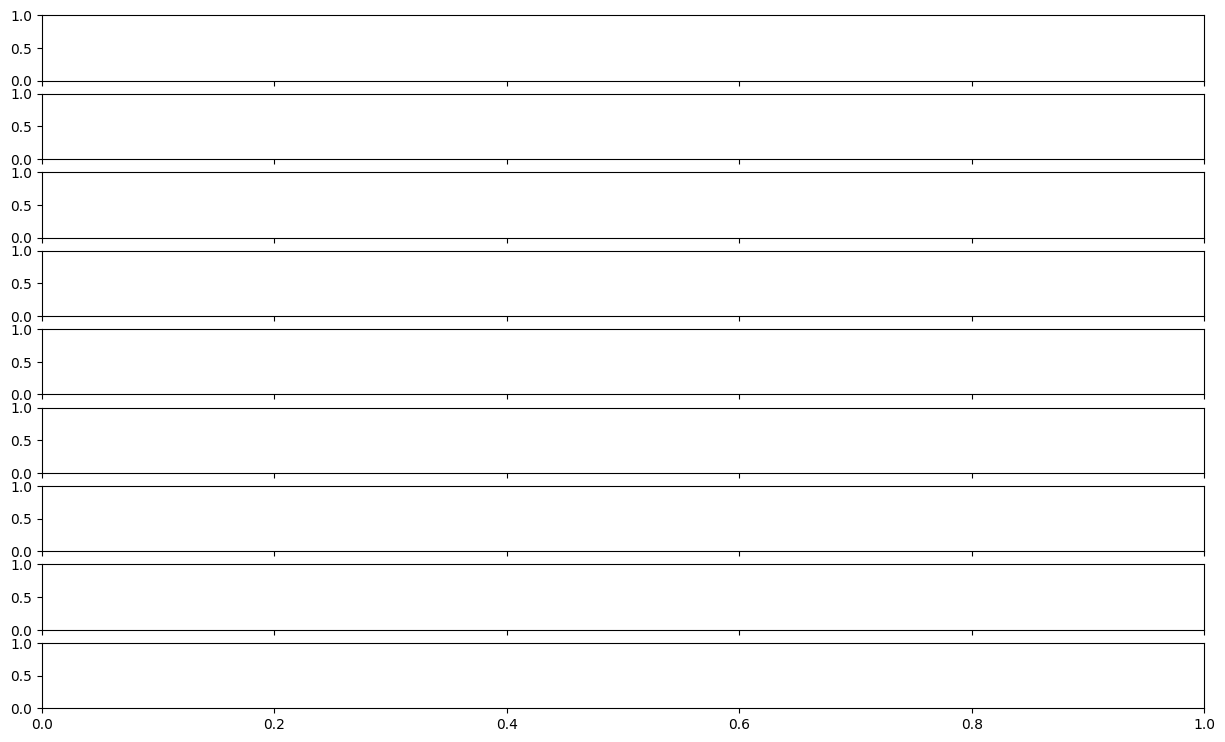

In [ ]:

NumofWINDOW_array = list(set(OBSlength_simdata.NumofWINDOW.to_numpy()))
NumofWINDOW_array.sort()
NumofWINDOW_array = NumofWINDOW_array[0::1]
print(NumofWINDOW_array)

fig, ax = plt.subplots(9, 1, figsize= [15, 9], sharex = True, sharey=False)
for i in range(len(NumofWINDOW_array)):
    simDATA_filterd = OBSlength_simdata.loc[OBSlength_simdata.NumofWINDOW == NumofWINDOW_array[i]]

    IDlist = simDATA_filterd.ID.to_numpy()
    
    OBPL_bf_val_array = val_array_calc('json_files/final/numWIND/')
    
    
    OBPL_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/' + str(int(val)) + '_OBPL10.json')
        OBPL_bf_val_array.append(jfile['log_bend_freq'][0:5600])
    DRW_bf_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/' + str(int(val)) + '_DRW.json')
        DRW_bf_val_array.append(jfile['log_bend_freq'][0:5600])

    DRW_mean_bf, DRW_std_bf, DRW_bin_centers, DRW_all_histograms = histogram_thing(np.power(10, DRW_bf_val_array), bin_edges = np.logspace(-1, 1, 25))
    OBPL_mean_bf, OBPL_std_bf, OBPL_bin_centers,  OBPL_all_histograms = histogram_thing(np.power(10, OBPL_bf_val_array), bin_edges = np.logspace(-1, 1, 25))

   
    #ax[i].hist(all_samples, bins=bin_edges, alpha=0.7,  color='blue', edgecolor='black', label='Histogram of Samples')
    #ax[i].errorbar(bin_centers, mean_hist, yerr=std_hist, fmt='o', color='red', ecolor='red', capsize=5, label='Mean and Std Dev of Histograms')
    whiskerprops_dict = dict(color = 'purple')
    capprops_dict = dict(color = 'purple')
    medianprops_dict = dict(color = 'indigo')
    bplot = ax[i].boxplot(DRW_all_histograms, positions=np.round(DRW_bin_centers, decimals=2), 
                          widths=0.05*np.logspace(-1, 1, np.shape(DRW_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    
    for patch in bplot['boxes']:
        patch.set_color('purple')
        patch.set_alpha(0.5)
        
    whiskerprops_dict = dict(color = 'darkgreen')
    capprops_dict = dict(color = 'darkgreen')
    medianprops_dict = dict(color = 'darkgreen')
    bplot = ax[i].boxplot(OBPL_all_histograms, positions=np.round(OBPL_bin_centers, decimals=2), 
                          widths=0.05*np.logspace(-1, 1, np.shape(OBPL_all_histograms)[1]), 
                          showfliers =False, whiskerprops =whiskerprops_dict,
                          capprops = capprops_dict, 
                          medianprops= medianprops_dict,
                          patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_color('green')
        patch.set_alpha(0.5)
        
        
    ax[i].axvline(0.00274*365, ls = '--',color = 'k')
    if i != 4: 
        ax[i].axes.get_xaxis().set_visible(False)
    #ax[i].legend(fontsize = 14)
    #ax[i].text(10**-1.05, 2, r'$t_{obs}$ :  ' + str(np.round(NumofWINDOW_array[i]/2, decimals = 0)) + ' years', fontsize = 17)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()




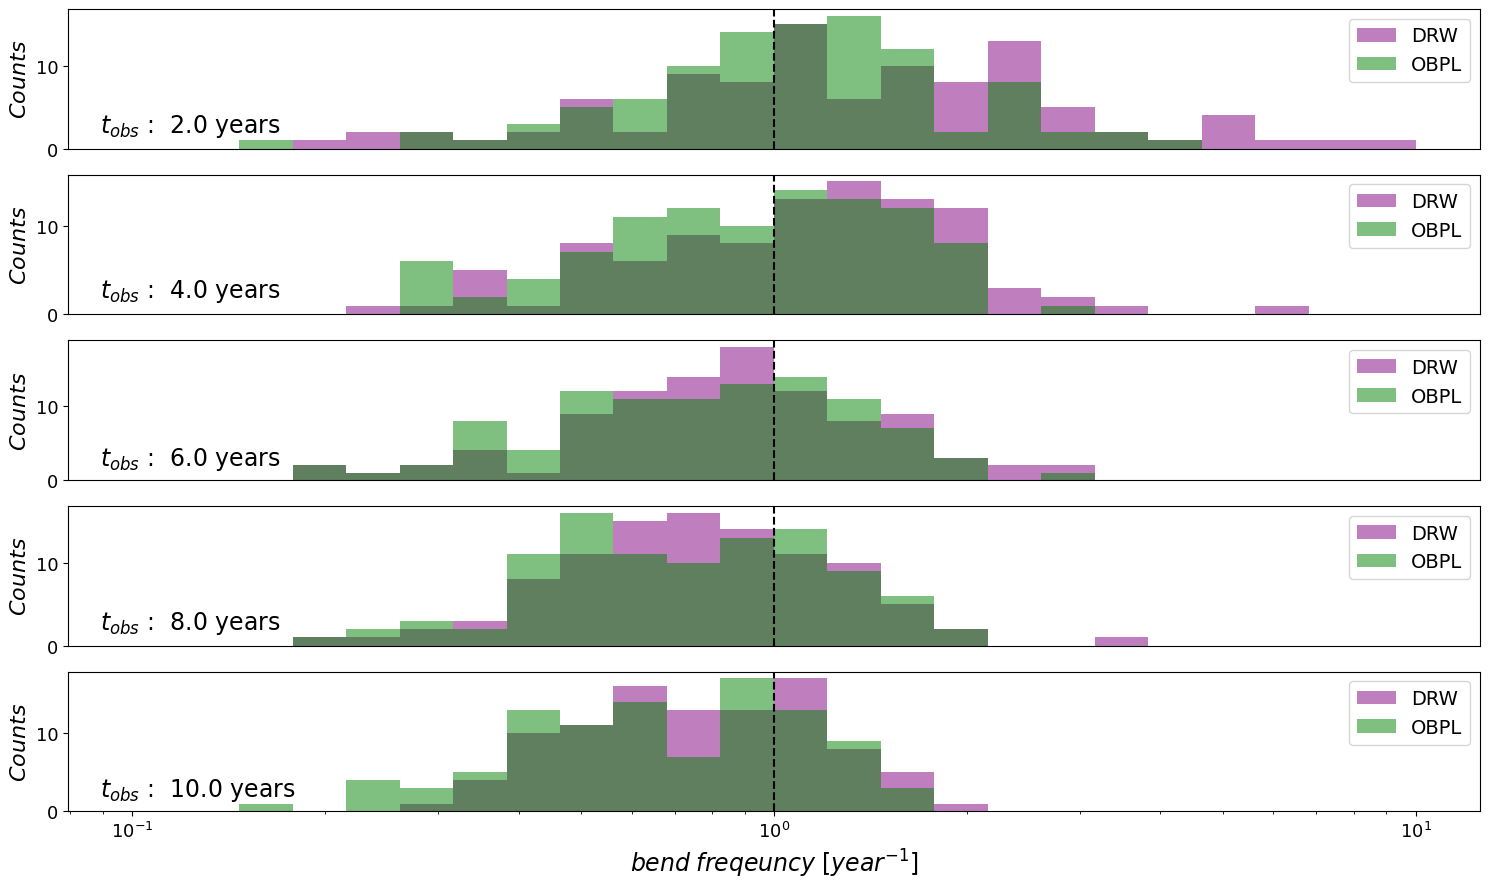

In [ ]:
fig, ax = plt.subplots(5, 1, figsize= [15, 9], sharex = True, sharey=False)

for i in range(len(NumofWINDOW_array)):
    simDATA_filterd = OBSlength_simdata.loc[OBSlength_simdata.NumofWINDOW ==NumofWINDOW_array[i]]

    # density = gaussian_kde(simDATA_filterd.DRW_bf)    
    # xs = np.linspace(0.1,10,200)
    # density.covariance_factor = lambda : .5
    # density._compute_covariance()
    
    counts, bins,_ = ax[i].hist(simDATA_filterd.DRW_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'purple', label = 'DRW')
    #ax[i].plot(xs,scaler(density(xs), 0, max(counts)), '-', color = 'tab:blue')
    
    # density = gaussian_kde(simDATA_filterd.OBPL10_bf)    
    # xs = np.linspace(0.1,10,200)
    # density._compute_covariance()
    counts, bins,_ =  ax[i].hist(simDATA_filterd.OBPL10_bf, bins =np.logspace(-1, 1, 25), density =False, stacked =False, alpha = 0.5, color = 'green',label = 'OBPL')
    #ax[i].plot(xs,scaler(density(xs), 0, max(counts)), '-', color = 'tab:orange')
    
    
    ax[i].axvline(0.00274*365, ls = '--',color = 'k')
    if i != 4: 
        ax[i].axes.get_xaxis().set_visible(False)
    ax[i].legend(fontsize = 14)
    ax[i].text(10**-1.05, 2, r'$t_{obs}$ :  ' + str(np.round(NumofWINDOW_array[i]/2, decimals = 0)) + ' years', fontsize = 17)
    ax[i].set_xscale('log')
    ax[i].tick_params(labelsize = 13)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$bend\;freqeuncy \;[year^{-1}]$', fontsize = 17)
plt.tight_layout()
plt.show()

# high alpha -2 to -4

In [38]:
highALPHA_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_2_4_low_alpha_0_1.csv',
                         json_files_path='json_files/final/high_alpha_low_alpha/final/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 1200/1200 [03:02<00:00,  6.57it/s]


In [39]:
class statPLOTS:
    def __init__(self, data_file) -> None:
        if isinstance(data_file, str):
            self.datafile = pd.read_csv(data_file)
            
        if isinstance(data_file, pd.DataFrame):
            self.datafile = data_file
            
    
    def get_dataframe(self):
        return self.datafile
    
    def fillna_model_counts(self, dictionary):
    
        BMCdict = dictionary.copy()
        for key in dictionary:

            if (key[0], 0) not in dictionary:
                BMCdict[(key[0], 0)] = 0
            if (key[0], 1) not in dictionary:
                BMCdict[(key[0], 1)] = 0
            if (key[0], -1) not in dictionary:
                BMCdict[(key[0], -1)] = 0

        return BMCdict
    
    
    
        
    
    
    
    def plot_barchart(self, param, model = 'DRW', xarray = [-99]):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
        
        BMCdict =  self.fillna_model_counts(self.datafile.groupby(param)[[boolvar]].value_counts().to_dict())
        BMCdict = dict(sorted(BMCdict.items(), key=lambda x: x[0]))
        x_array = []
        noise_value_counts = []
        noisesine_value_counts = []
        inc_value_counts = []
        for key in BMCdict:
            if key[1]==0:
                x_array.append(key[0])
                inc_value_counts.append(BMCdict[key])
            elif key[1]==1:
                noisesine_value_counts.append(BMCdict[key])
            elif key[1]==-1:
                noise_value_counts.append(BMCdict[key])

        if xarray[0] == -99:
            pass
        else:
            x_array = xarray
        noise_value_counts = np.array(noise_value_counts)
        noisesine_value_counts = np.array(noisesine_value_counts)
        inc_value_counts = np.array(inc_value_counts)  

        sumofall = noise_value_counts + noisesine_value_counts + inc_value_counts
        plt.figure(figsize=[12, 6])
        plt.barh(np.round(x_array,decimals=5).astype('str'), noise_value_counts*100/sumofall, height=0.5, color='mediumblue' )
        plt.barh(np.round(x_array,decimals=5).astype('str'), noisesine_value_counts*100/sumofall, left=noise_value_counts*100/sumofall, height=0.5,  color='firebrick')
        plt.barh(np.round(x_array,decimals=5).astype('str'), inc_value_counts*100/sumofall, left= np.array(noise_value_counts*100/sumofall) + np.array(noisesine_value_counts*100/sumofall), height=0.5,  color='gray')
        plt.tight_layout()
        plt.legend(['$'+ model+'$', '$'+ model+' + sine$', '$inconclusive$'], fontsize=13, loc = 'upper right')
        plt.ylabel('$'+ param+'$', fontsize=15)
        plt.xlabel('$Model\;preference\;[\%]$', fontsize=15)
        plt.gca().invert_yaxis()
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        #plt.savefig('plots/DRWsine_highalpha_2_4.png', )
        plt.show()
        return pd.DataFrame(np.array([noise_value_counts,noisesine_value_counts, inc_value_counts]).T,
                   index=np.round(x_array, decimals=2),
                   columns=[r"$red\;noise\;only$", r"$red\;noise + period$", r"$inconclusive$"])
        
    def plot_bayesDistri(self, param , model ='DRW', plottype = 'violin'):
        if model =='DRW':
            bayesvar_arr = ['DRW_DRWsine_bayes']
        if model =='CARMA21':
            bayesvar_arr = ['CARMA21_CARMA21sine_bayes']
        if model =='OBPL':
            bayesvar_arr =['OBPL10_OBPLsine10_bayes' ] 
        if model == 'all':
            bayesvar_arr =['DRW_DRWsine_bayes', 'CARMA21_CARMA21sine_bayes', 'OBPL10_OBPLsine10_bayes' ] 
            
        if model!='all':
            plt.figure(figsize=[10, 6])
            
            colors = ['purple', 'red', 'green']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                x_array.reverse()

                x_array = x_array[0::1]
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
            
                # for i in x_array:
                #     y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                #     plt.plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    plt.violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = plt.boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
            for i in [0.,  2, -2]:
                plt.axhline(10**i, label = 'log K = '+str(i), color = 'k', ls = '--')
                    
                    
            plt.xticks(x_array, labels=x_array)
            plt.yscale('log')
            #plt.gca().set_xticklabels()
            plt.legend(loc = 'lower right')
            plt.xlim(min(x_array) - diff/3, max(x_array) + diff/3)
            plt.xlabel(''+ param +'', fontsize = 13)
            plt.ylabel(r'$B_{10}\left(\frac{}{}\right)$'.format("{"+model+"}", "{"+model+" + sine }" ), fontsize =13)
            plt.tight_layout()
            plt.show()
            
            
        else:
            fig, ax = plt.subplots(3, 1, figsize=[14, 8], sharex=True, sharey=True)
            colors = ['purple', 'red', 'green']
            models = ['DRW', 'CARMA', 'OBPL']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                x_array.reverse()

                x_array = x_array[0::1]
                #x_array.append(-4)
                x_array = np.round(x_array, decimals=5)
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
                for i in x_array:
                    y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                    ax[j].plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    ax[j].violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = ax[j].boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
                for i in [ 2, -2]:
                    ax[j].axhline(10**i, label = '$log_{10}\;B_{10} = $'+str(i), color = 'k', ls = '--',alpha=0.3)
                    
                ax[j].set_xticks(x_array, labels=np.round(x_array, decimals=2))
                ax[j].set_yscale('log')
                ax[j].tick_params(labelsize = 12)
                #plt.gca().set_xticklabels()
                ax[j].legend(loc = 'lower left', fontsize = 13)
                #ax[j].set_xlim(min(x_array) - diff/5, max(x_array) + diff/5)
                ax[j].set_xlim(-4.3, -1.7)
                if j ==2:
                    ax[j].set_xlabel(r"$\alpha_{high}$", fontsize = 19)
                ax[j].grid(axis = 'x')
                ax[j].set_ylabel(r'$B_{}\left(\frac{}{}\right)$'.format("{"+str(10)+"}","{"+models[j]+"}", "{"+models[j]+" + sine }" ), fontsize =15)
                ax[j].invert_xaxis()
            plt.tight_layout()
            plt.show()
                
                    
                    
                    
                    
                    
                    
    def confusion_matrix(self,  no_period_dataset, period_dataset, model='DRW'):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
            
        no_period_prediction = no_period_dataset[boolvar].value_counts().to_dict()
        period_prediction = period_dataset[boolvar].value_counts().to_dict()
        
        for i in [-1,0,1]:
            if i not in no_period_prediction.keys():
                no_period_prediction[i] = 0
            if i not in period_prediction.keys():
                period_prediction[i] = 0
        
        confusion_matrix = np.zeros((2, 3), dtype=int)

        confusion_matrix[0, 0] = no_period_prediction[0]
        confusion_matrix[0, 1] = no_period_prediction[-1]
        confusion_matrix[0, 2] = no_period_prediction[1]
        confusion_matrix[1, 0] = period_prediction[0]
        confusion_matrix[1, 1] = period_prediction[-1]
        confusion_matrix[1, 2] = period_prediction[1]
        
        plt.figure(figsize=(12, 7))
        sns.set(font_scale=1.1)
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                    xticklabels=['$inconclusive$', '$Noise\;only\;prefered$', '$periodic\;model\;prefered$'],
                    yticklabels=['$No\;periodicity\;simulated$', '$Periodicity\;simulated$'], square=True, annot_kws={'size': 12})

        plt.xlabel('Predicted', fontsize = 16, weight = 'bold')
        plt.ylabel('True', fontsize = 16, weight = 'bold')
        plt.tight_layout()
        plt.show()
        

INFO[2026-02-05 11:45:16,645]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,646]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,649]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,652]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


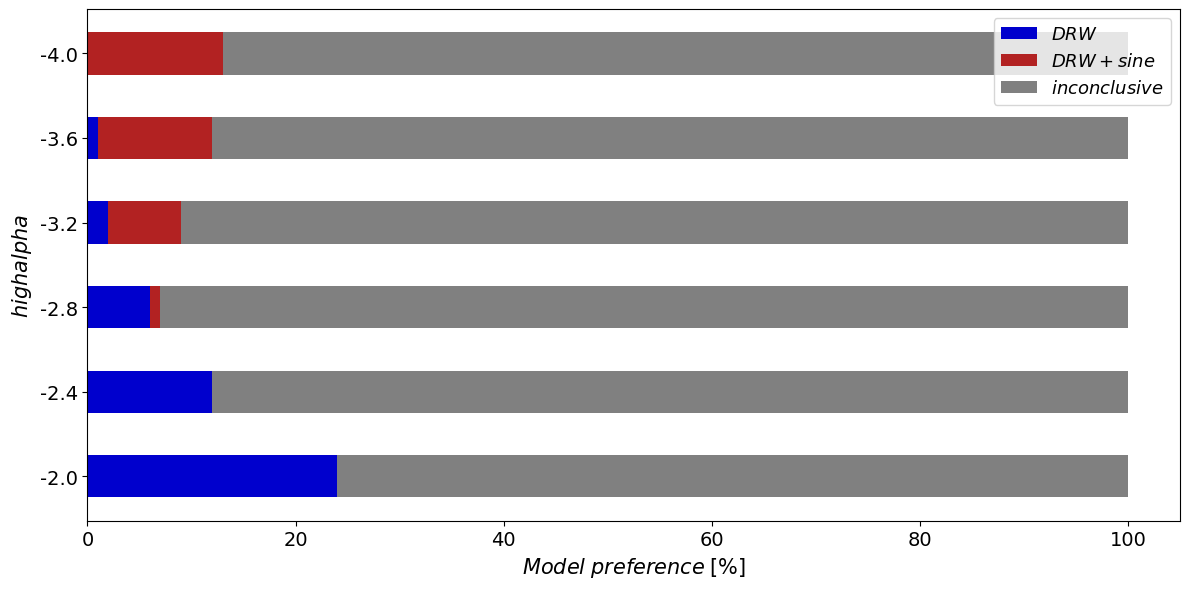

INFO[2026-02-05 11:45:16,759]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,760]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,762]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,763]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


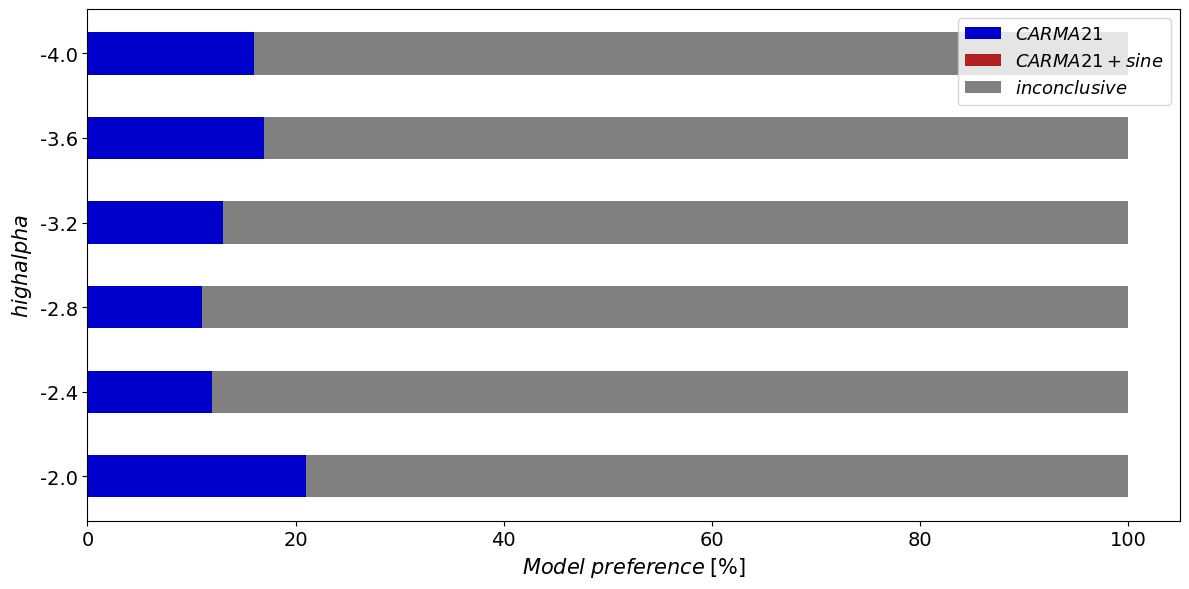

INFO[2026-02-05 11:45:16,845]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,845]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,847]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2026-02-05 11:45:16,849]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


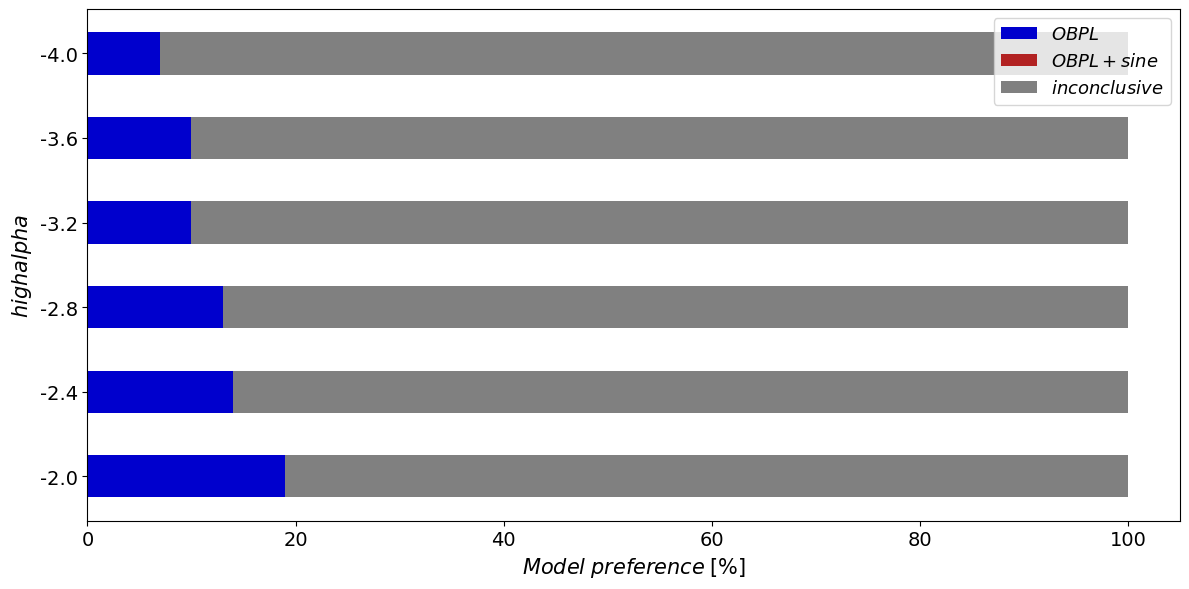

In [40]:
highALPHA_plotter = statPLOTS(highALPHA_simdata.loc[highALPHA_simdata.lowalpha == 0])

tDRW = highALPHA_plotter.plot_barchart('highalpha', model = 'DRW').sort_index(ascending=False)
tCARMA = highALPHA_plotter.plot_barchart('highalpha', model = 'CARMA21').sort_index(ascending=False)
tOBPL =  highALPHA_plotter.plot_barchart('highalpha', model = 'OBPL').sort_index(ascending=False)

In [41]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    plt.figure(figsize=[16, 7.5])
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      color = ['blue', 'red', 'gray'],
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)*2) #edited part   
                rect.set_edgecolor('white')  
                rect.set_width(1 / float(n_df + 1)/1.5)

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", edgecolor = 'white',hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[0.67, 0.81], fontsize =16, facecolor='white', framealpha=0.9)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.87,0.821], fontsize =16,  facecolor='white', framealpha=0.9) 
    axe.add_artist(l1)
    plt.tick_params(labelsize = 15)
    plt.xlabel(r'$High\;Frequency\;slope$', fontsize = 18)
    plt.ylabel(r'$Model\;preference$', fontsize = 18)
    plt.tight_layout()
    plt.show()
    return axe

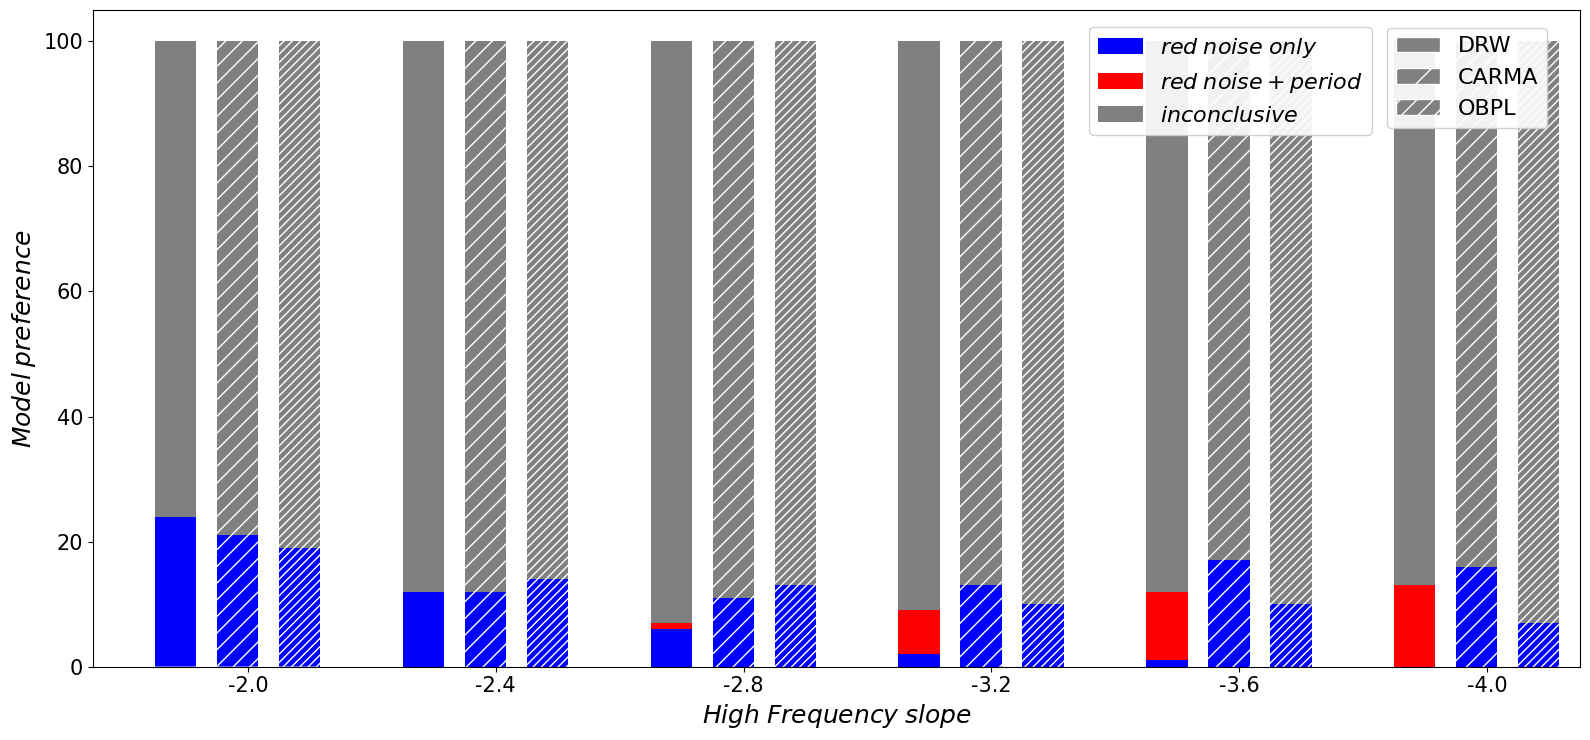

In [42]:
# _ = plot_clustered_stacked([tDRW.iloc[[0,2,4,5,7,9]], tCARMA.iloc[[0,2,4,5,7,9]], tOBPL.iloc[[0,2,4,5,7,9]]],['DRW', 'CARMA', 'OBPL'])
_ = plot_clustered_stacked([tDRW, tCARMA, tOBPL],['DRW', 'CARMA', 'OBPL'])


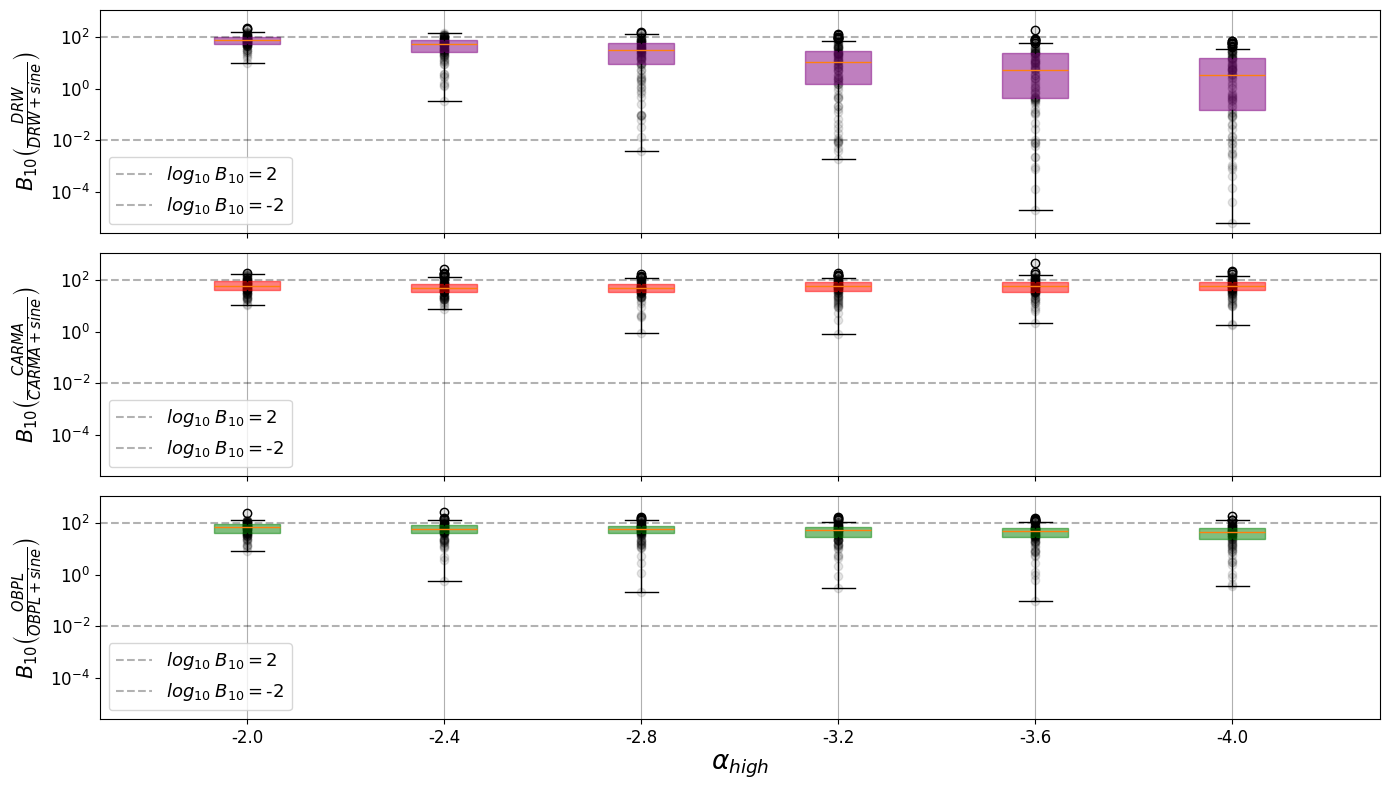

In [43]:
highALPHA_plotter.plot_bayesDistri(param='highalpha',  model='all', plottype='box')

# highALPHA_plotter.plot_bayesDistri(param='highalpha',  model='DRW', plottype='box')
# highALPHA_plotter.plot_bayesDistri(param='highalpha',  model='CARMA21', plottype='box')
# highALPHA_plotter.plot_bayesDistri(param='highalpha',  model='OBPL', plottype='box')


In [51]:
IDlist

array([1000., 1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008.,
       1009., 1010., 1011., 1012., 1013., 1014., 1015., 1016., 1017.,
       1018., 1019., 1020., 1021., 1022., 1023., 1024., 1025., 1026.,
       1027., 1028., 1029., 1030., 1031., 1032., 1033., 1034., 1035.,
       1036., 1037., 1038., 1039., 1040., 1041., 1042., 1043., 1044.,
       1045., 1046., 1047., 1048., 1049., 1050., 1051., 1052., 1053.,
       1054., 1055., 1056., 1057., 1058., 1059., 1060., 1061., 1062.,
       1063., 1064., 1065., 1066., 1067., 1068., 1069., 1070., 1071.,
       1072., 1073., 1074., 1075., 1076., 1077., 1078., 1079., 1080.,
       1081., 1082., 1083., 1084., 1085., 1086., 1087., 1088., 1089.,
       1090., 1091., 1092., 1093., 1094., 1095., 1096., 1097., 1098.,
       1099., 1100., 1101., 1102., 1103., 1104., 1105., 1106., 1107.,
       1108., 1109., 1110., 1111., 1112., 1113., 1114., 1115., 1116.,
       1117., 1118., 1119., 1120., 1121., 1122., 1123., 1124., 1125.,
       1126., 1127.,

-2.0


FileNotFoundError: [Errno 2] No such file or directory: 'json_files/highalpha_2_4/1000_OBPL10.json'

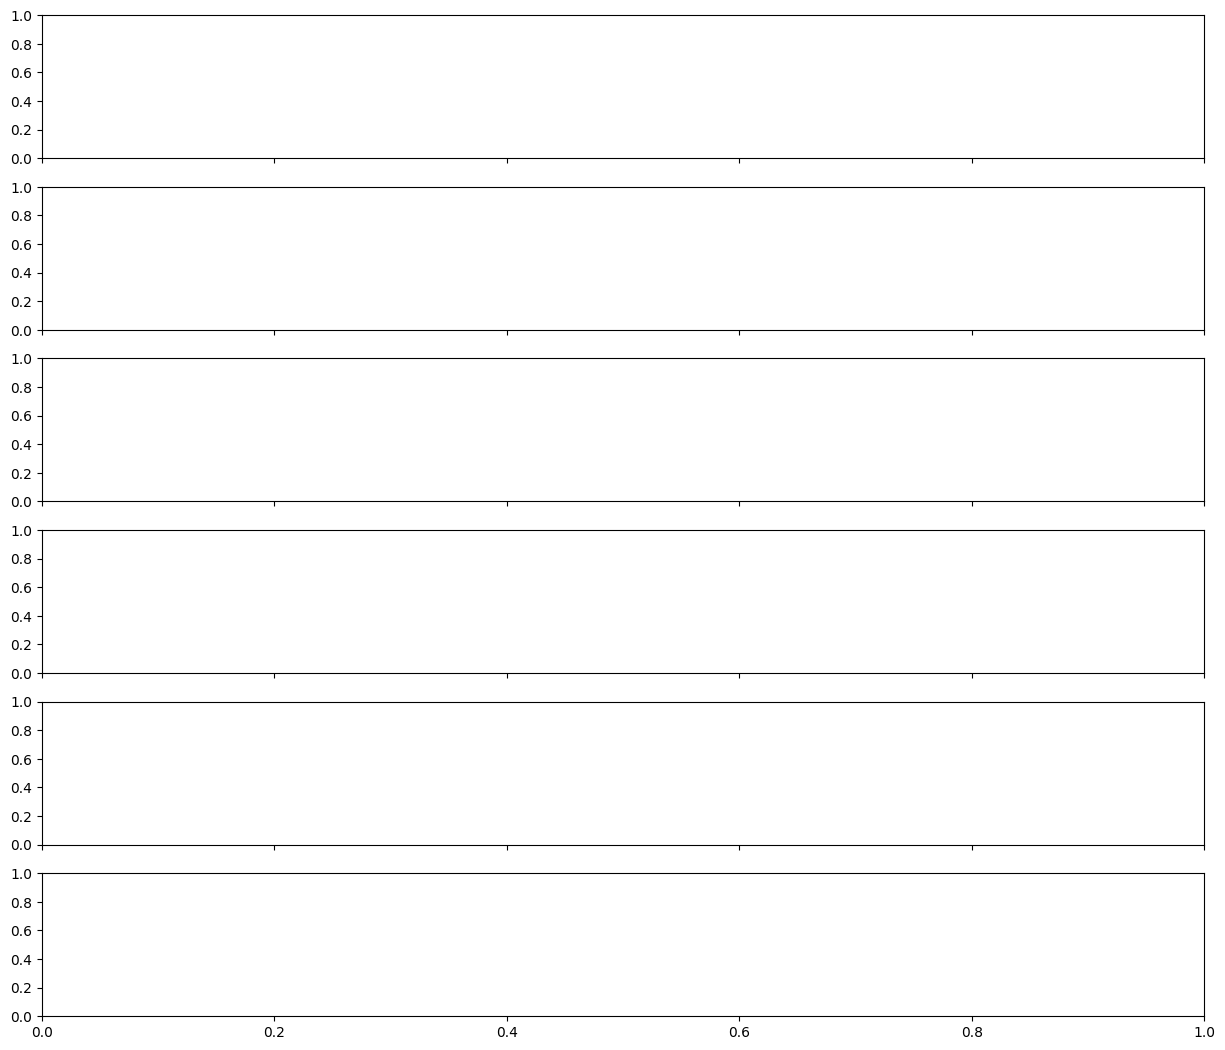

In [50]:

fig, ax = plt.subplots(6, 1, figsize= [15, 13], sharex = True, sharey=True)

highalpha_array = list(set(highALPHA_simdata.highalpha.to_numpy()))
highalpha_array.sort()
highalpha_array.reverse()

highalpha_croped = highalpha_array[0::2]
highalpha_croped.append(-4)
for i in range(len(highalpha_croped)):
    simDATA_filterd = highALPHA_simdata.loc[highALPHA_simdata.highalpha ==highalpha_croped[i]]

    IDlist = simDATA_filterd.ID.to_numpy()
    print(highalpha_croped[i])
    param_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/highalpha_2_4/' + str(int(val)) + '_OBPL10.json')
        param_val_array.append(jfile['alpha_h'][0:5600])

    np.random.seed(0)
    posterior_samples = np.array(param_val_array)
    medians = [np.median(samples) for samples in posterior_samples]

    # Function to perform bootstrap resampling and compute medians
    def bootstrap_medians(posterior_samples, n_resamples=1000):
        n_posteriors = len(posterior_samples)
        resampled_medians = []
        for _ in range(n_resamples):
            resample_indices = np.random.choice(range(n_posteriors), n_posteriors, replace=True)
            resample_medians = [np.median(posterior_samples[i]) for i in resample_indices]
            resampled_medians.append(resample_medians)
        return np.array(resampled_medians)


    n_resamples = 1000
    resampled_medians = bootstrap_medians(posterior_samples, n_resamples=n_resamples)

    bins = np.linspace(1.5, 4.1, 23  , endpoint=True)
    all_histograms = []
    bin_edges = None
    for resample in resampled_medians:
        hist_counts, bin_edges = np.histogram(resample, bins=bins)
        all_histograms.append(hist_counts)
    all_histograms = np.array(all_histograms)

    mean_hist = np.mean(all_histograms, axis=0)
    std_hist = np.std(all_histograms, axis=0)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    
    #plt.figure(figsize=(10, 6))
    counts, bins,_ = ax[i].hist(medians, bins=bins, color='green', alpha= 0.5)
    #counts, bins,_ =  ax[i].hist(simDATA_filterd.OBPL10_alpha_h, bins = bins, alpha = 0.5, color = 'green',label = 'OBPL')
    ax[i].errorbar(bin_centers[std_hist!=0], mean_hist[std_hist!=0], yerr=std_hist[std_hist!=0], fmt='o', color='darkgreen', ecolor='darkgreen', capsize=5)
    #counts, bins,_ =  ax[i].hist(simDATA_filterd.OBPL10_alpha_h, bins =np.linspace(1.5, 4., 25), density =False, stacked =False, alpha = 0.5, color = 'green',label = 'OBPL')  
    ax[i].axvline(-1*highalpha_croped[i], ls = '--',color = 'k')
    if i != 5: 
        ax[i].axes.get_xaxis().set_visible(False)

    #ax[i].legend(fontsize = 14, loc = 'upper right')
    ax[i].text(1.6, 40, r'$\alpha_{high}$ :  ' + str(np.round(highalpha_croped[i], decimals = 2)), fontsize = 17)
    ax[i].tick_params(labelsize = 13)
    ax[i].set_xlim(1.57, 4.1)
    ax[1].set_ylim(0, 50)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
    
plt.xlabel(r'$high\;frequency\;slope$', fontsize = 17)
plt.tight_layout()
plt.show()




In [45]:
from matplotlib.patches import Rectangle


-2.0


-2.4
-2.8
-3.2
-3.6
-4.0


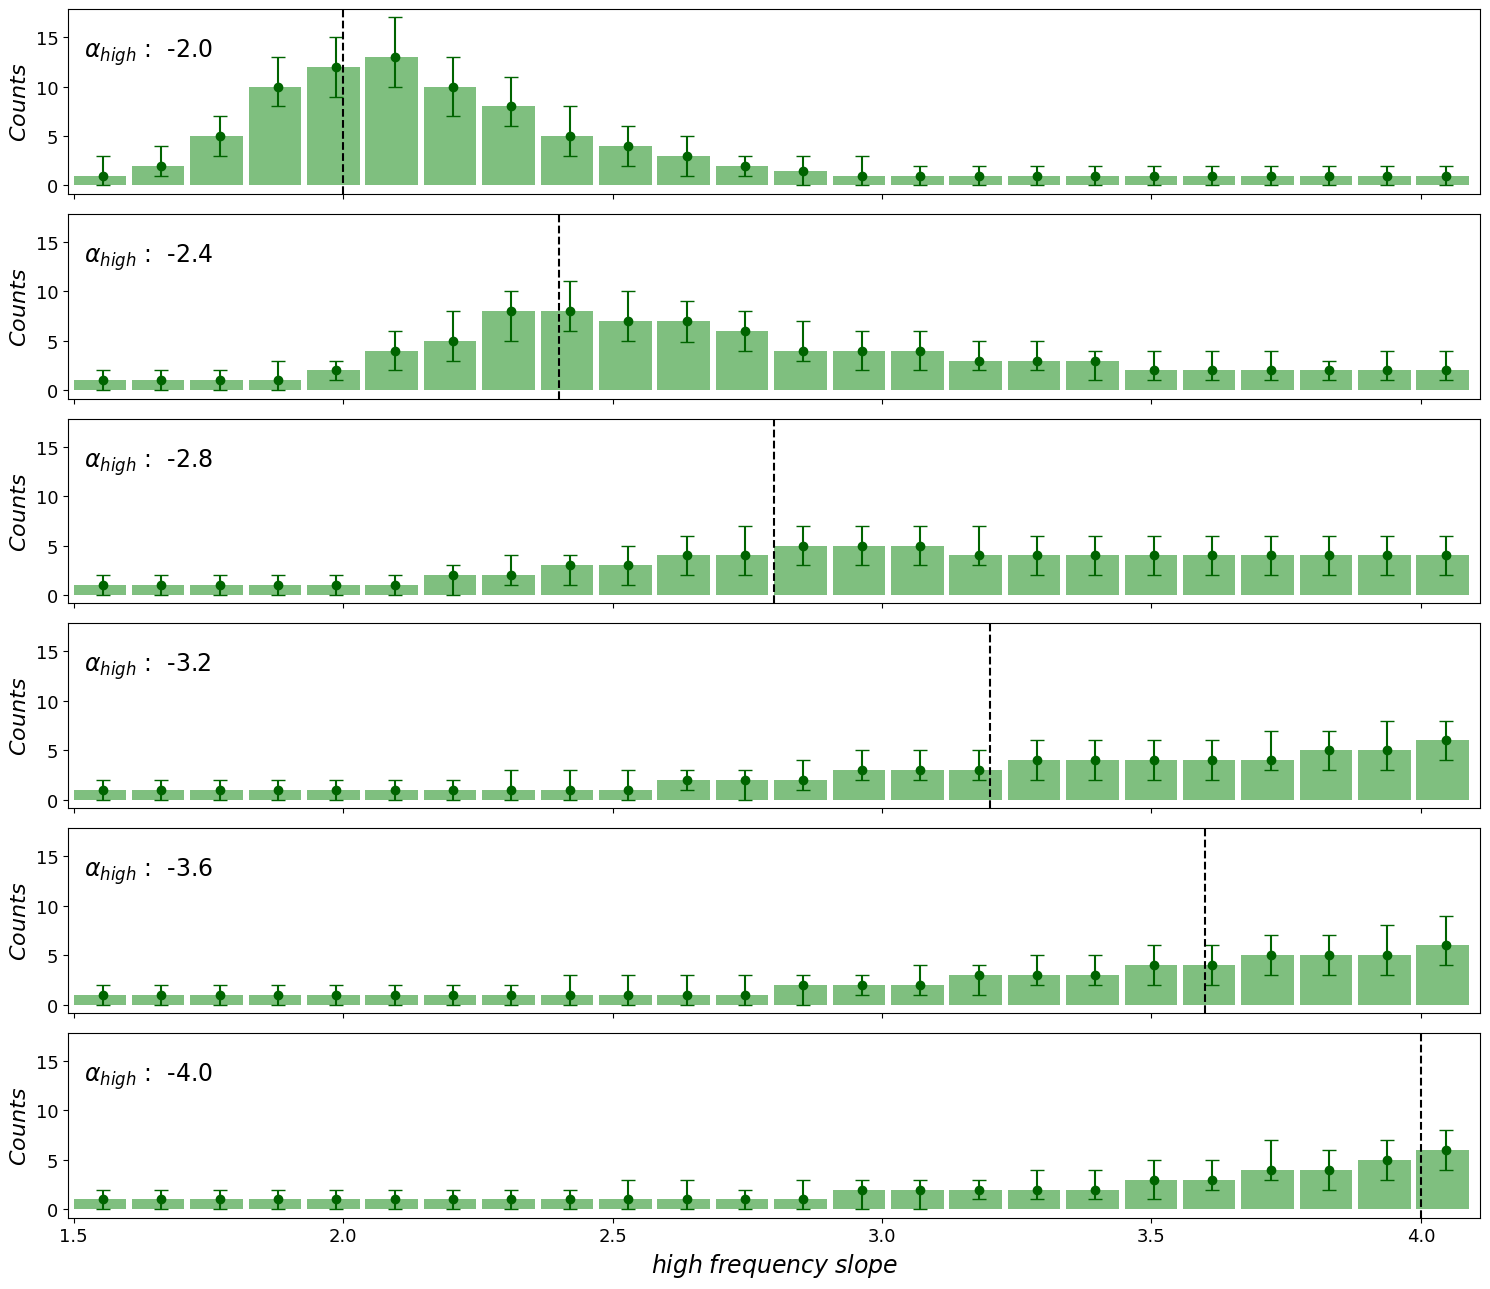

In [46]:

fig, ax = plt.subplots(6, 1, figsize= [15, 13], sharex = True, sharey=True)

highalpha_array = list(set(highALPHA_simdata.highalpha.to_numpy()))
highalpha_array.sort()
highalpha_array.reverse()

highalpha_croped = highalpha_array
#highalpha_croped.append(-4)
for i in range(len(highalpha_croped)):
    simDATA_filterd = highALPHA_simdata.loc[(highALPHA_simdata.highalpha ==highalpha_croped[i]) & (highALPHA_simdata.lowalpha ==0)]

    IDlist = simDATA_filterd.ID.to_numpy()
    print(highalpha_croped[i])
    param_val_array_test = []
    test = []
    for val in IDlist:
        jfile = load_json('json_files/final/high_alpha_low_alpha/' + str(int(val)) + '_OBPL10.json')
        param_val_array_test.append(jfile['alpha_h'])
        test.append(len(jfile['alpha_h']))

    param_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/final/high_alpha_low_alpha/' + str(int(val)) + '_OBPL10.json')
        param_val_array.append(jfile['alpha_h'][:min(test)])

    np.random.seed(0)
    posterior_samples = np.array(param_val_array)

    def generate_sample_set(posterior_samples):
        return [np.random.choice(samples) for samples in posterior_samples]


    N = 2000
    sample_sets = [generate_sample_set(posterior_samples) for _ in range(N)]

    #bins = 25
    all_samples = [sample for sample_set in sample_sets for sample in sample_set]
    bin_edges = np.linspace(1.5, 4.1, 25)

    all_histograms = np.array([np.histogram(sample_set, bins=bin_edges)[0] for sample_set in sample_sets])

    mean_hist = np.median(all_histograms, axis=0)
    std_hist = np.percentile(all_histograms, [16, 84], axis=0)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

   
    #ax[i].hist(all_samples, bins=bin_edges, alpha=0.7,  color='blue', edgecolor='black', label='Histogram of Samples')
    ax[i].errorbar(bin_centers, mean_hist, yerr=[mean_hist - std_hist[0], std_hist[1]-mean_hist], fmt='o', color='darkgreen', ecolor='darkgreen', capsize=5)
    for j in range(len(mean_hist)):
        ax[i].add_patch(Rectangle((bin_edges[j], 0), 0.9*(bin_centers[1] - bin_centers[0]), mean_hist[j] ,
                        facecolor = 'green',
                        fill=True, alpha=0.5))
    #bplot = ax[i].boxplot(all_histograms, positions=np.round(bin_centers, decimals=2), widths=0.05, patch_artist=True)
    # whiskerprops_dict = dict(color = 'darkgreen')
    # capprops_dict = dict(color = 'darkgreen')
    # medianprops_dict = dict(color = 'darkgreen')
    # bplot = ax[i].boxplot(all_histograms, positions=np.round(bin_centers, decimals=2), 
    #                       widths=0.1, 
    #                       showfliers =False, whiskerprops =whiskerprops_dict,
    #                       capprops = capprops_dict, 
    #                       medianprops= medianprops_dict,
    #                       patch_artist=True)
    # for patch in bplot['boxes']:
    #     patch.set_color('green')
    #     patch.set_alpha(0.5)
        
        
    ax[i].axvline(highalpha_croped[i]*-1, ls = '--', color = 'black')
    #ax[i].legend(fontsize = 14, loc = 'upper right')
    ax[i].text(1.52,13 , r'$\alpha_{high}$ :  ' + str(np.round(highalpha_croped[i], decimals = 2)), fontsize = 17)
    ax[i].tick_params(labelsize = 13)
    ax[i].set_xlim(1.49, 4.11)
    #ax[1].set_ylim(0, 50)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
plt.xlabel(r'$high\;frequency\;slope$', fontsize = 17)
plt.tight_layout()
plt.show()




# observation length

In [ ]:
class statPLOTS:
    def __init__(self, data_file) -> None:
        if isinstance(data_file, str):
            self.datafile = pd.read_csv(data_file)
            
        if isinstance(data_file, pd.DataFrame):
            self.datafile = data_file
            
    
    def get_dataframe(self):
        return self.datafile
    
    def fillna_model_counts(self, dictionary):
    
        BMCdict = dictionary.copy()
        for key in dictionary:

            if (key[0], 0) not in dictionary:
                BMCdict[(key[0], 0)] = 0
            if (key[0], 1) not in dictionary:
                BMCdict[(key[0], 1)] = 0
            if (key[0], -1) not in dictionary:
                BMCdict[(key[0], -1)] = 0

        return BMCdict
    
    
    
    
    def plot_barchart(self, param, model = 'DRW', xarray = [-99]):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
        
        BMCdict =  self.fillna_model_counts(self.datafile.groupby(param)[[boolvar]].value_counts().to_dict())
        BMCdict = dict(sorted(BMCdict.items(), key=lambda x: x[0]))
        x_array = []
        noise_value_counts = []
        noisesine_value_counts = []
        inc_value_counts = []
        for key in BMCdict:
            if key[1]==0:
                x_array.append(key[0])
                inc_value_counts.append(BMCdict[key])
            elif key[1]==1:
                noisesine_value_counts.append(BMCdict[key])
            elif key[1]==-1:
                noise_value_counts.append(BMCdict[key])

        if xarray[0] == -99:
            pass
        else:
            x_array = xarray
        noise_value_counts = np.array(noise_value_counts)
        noisesine_value_counts = np.array(noisesine_value_counts)
        inc_value_counts = np.array(inc_value_counts)  

        sumofall = noise_value_counts + noisesine_value_counts + inc_value_counts
        plt.figure(figsize=[12, 6])
        plt.barh(np.round(x_array,decimals=5).astype('str'), noise_value_counts*100/sumofall, height=0.5, color='mediumblue' )
        plt.barh(np.round(x_array,decimals=5).astype('str'), noisesine_value_counts*100/sumofall, left=noise_value_counts*100/sumofall, height=0.5,  color='firebrick')
        plt.barh(np.round(x_array,decimals=5).astype('str'), inc_value_counts*100/sumofall, left= np.array(noise_value_counts*100/sumofall) + np.array(noisesine_value_counts*100/sumofall), height=0.5,  color='gray')
        plt.tight_layout()
        plt.legend(['$'+ model+'$', '$'+ model+' + sine$', '$inconclusive$'], fontsize=13, loc = 'upper right')
        plt.ylabel('$'+ param+'$', fontsize=15)
        plt.xlabel('$Model\;preference\;[\%]$', fontsize=15)
        plt.gca().invert_yaxis()
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        #plt.savefig('plots/DRWsine_highalpha_2_4.png', )
        plt.show()
        return pd.DataFrame(np.array([noise_value_counts,noisesine_value_counts, inc_value_counts]).T,
                   index=np.round(x_array, decimals=2),
                   columns=[r"$red\;noise\;only$", r"$red\;noise + period$", r"$inconclusive$"])
        
    def plot_bayesDistri(self, param , model ='DRW', plottype = 'violin'):
        if model =='DRW':
            bayesvar_arr = ['DRW_DRWsine_bayes']
        if model =='CARMA21':
            bayesvar_arr = ['CARMA21_CARMA21sine_bayes']
        if model =='OBPL':
            bayesvar_arr =['OBPL10_OBPLsine10_bayes' ] 
        if model == 'all':
            bayesvar_arr =['DRW_DRWsine_bayes', 'CARMA21_CARMA21sine_bayes', 'OBPL10_OBPLsine10_bayes' ] 
            
        if model!='all':
            plt.figure(figsize=[10, 6])
            
            colors = ['purple', 'red', 'green']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                x_array.reverse()

                x_array = x_array[0::1]
#                x_array.append(-4)
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
            
                # for i in x_array:
                #     y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                #     plt.plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    plt.violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = plt.boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
            for i in [0.,  2, -2]:
                plt.axhline(10**i, label = 'log K = '+str(i), color = 'k', ls = '--')
                    
                    
            plt.xticks(x_array, labels=x_array)
            plt.yscale('log')
            #plt.gca().set_xticklabels()
            plt.legend(loc = 'lower right')
            plt.xlim(min(x_array) - diff/3, max(x_array) + diff/3)
            plt.xlabel(''+ param +'', fontsize = 13)
            plt.ylabel(r'$B_{10}\left(\frac{}{}\right)$'.format("{"+model+"}", "{"+model+" + sine }" ), fontsize =13)
            plt.tight_layout()
            plt.show()
            
            
        else:
            fig, ax = plt.subplots(3, 1, figsize=[16, 9], sharex=True, sharey=True)
            colors = ['purple', 'red', 'green']
            models = ['DRW', 'CARMA', 'OBPL']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                x_array.reverse()

                # x_array = x_array[0::2]
                # x_array.append(-4)
                x_array = np.round(x_array, decimals=5)
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
                for i in x_array:
                    y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                    ax[j].plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    ax[j].violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = ax[j].boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
                for i in [ 2, -2]:
                    ax[j].axhline(10**i, label = '$log_{10}\;B_{10} = $'+str(i), color = 'k', ls = '--',alpha=0.3)
                    
                ax[j].set_xticks(x_array, labels=np.round(x_array/2, decimals=2))
                ax[j].set_yscale('log')
                ax[j].tick_params(labelsize = 14)
                #plt.gca().set_xticklabels()
                ax[j].legend(loc = 'lower left', fontsize = 13)
                #ax[j].set_xlim(min(x_array) - diff/5, max(x_array) + diff/5)
                ax[j].set_xlim(3, 21)
                if j ==2:
                    ax[j].set_xlabel(r"$Length\;of\;Observation\;[years]$", fontsize = 19)
                ax[j].grid(axis = 'x')
                ax[j].set_ylabel(r'$B_{}\left(\frac{}{}\right)$'.format("{"+str(10)+"}","{"+models[j]+"}", "{"+models[j]+" + sine }" ), fontsize =15)
                # ax[j].invert_xaxis()
            
            plt.tight_layout()
            plt.show()
                
                    
                    
                    
                    
                    
                    
    def confusion_matrix(self,  no_period_dataset, period_dataset, model='DRW'):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
            
        no_period_prediction = no_period_dataset[boolvar].value_counts().to_dict()
        period_prediction = period_dataset[boolvar].value_counts().to_dict()
        
        for i in [-1,0,1]:
            if i not in no_period_prediction.keys():
                no_period_prediction[i] = 0
            if i not in period_prediction.keys():
                period_prediction[i] = 0
        
        confusion_matrix = np.zeros((2, 3), dtype=int)

        confusion_matrix[0, 0] = no_period_prediction[0]
        confusion_matrix[0, 1] = no_period_prediction[-1]
        confusion_matrix[0, 2] = no_period_prediction[1]
        confusion_matrix[1, 0] = period_prediction[0]
        confusion_matrix[1, 1] = period_prediction[-1]
        confusion_matrix[1, 2] = period_prediction[1]
        
        plt.figure(figsize=(12, 7))
        sns.set(font_scale=1.1)
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                    xticklabels=['$inconclusive$', '$Noise\;only\;prefered$', '$periodic\;model\;prefered$'],
                    yticklabels=['$No\;periodicity\;simulated$', '$Periodicity\;simulated$'], square=True, annot_kws={'size': 12})

        plt.xlabel('Predicted', fontsize = 16, weight = 'bold')
        plt.ylabel('True', fontsize = 16, weight = 'bold')
        plt.tight_layout()
        plt.show()
        


In [ ]:
OBSlength_simdata = datacollector(csv_file_path= 'simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv',
                         json_files_path='json_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/')

In [ ]:
OBSlength_simdata2 = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_4_20.csv',
                         json_files_path='json_files/final/numWIND/numWIND/final/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 900/900 [01:05<00:00, 13.68it/s]


INFO[2024-07-24 10:56:04,655]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,656]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,660]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,666]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


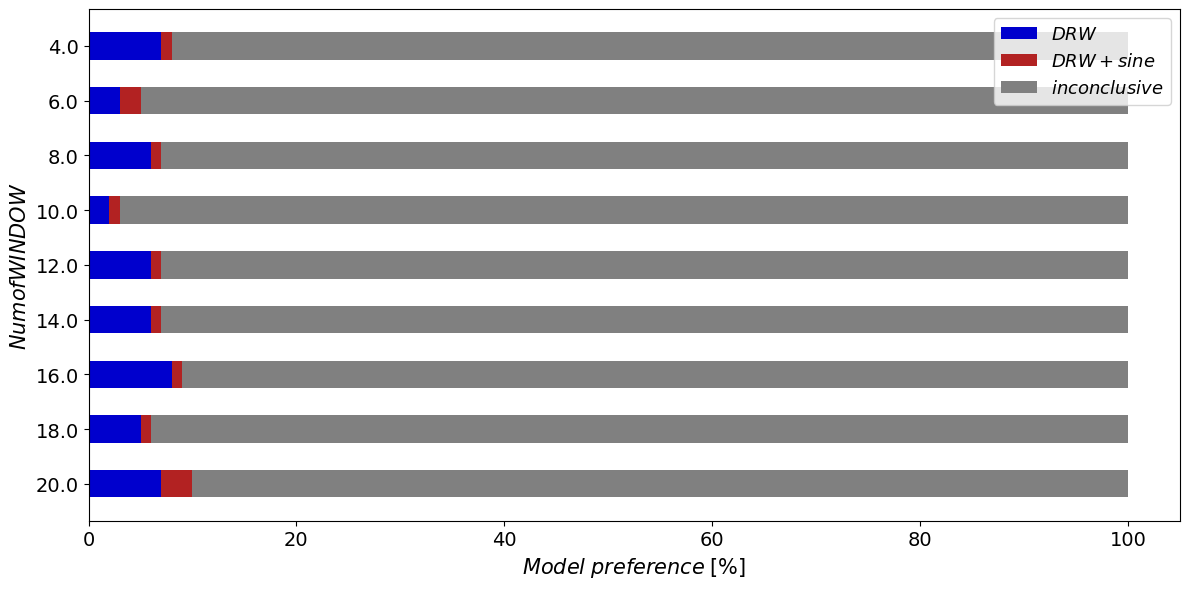

INFO[2024-07-24 10:56:04,840]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,841]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,845]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:04,849]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


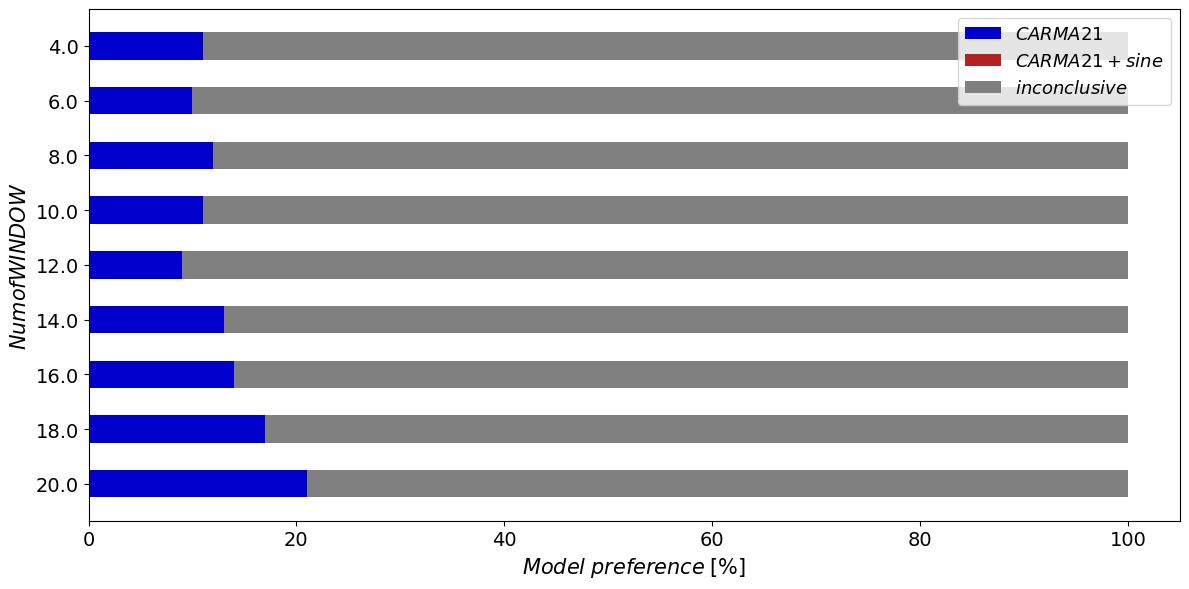

INFO[2024-07-24 10:56:05,026]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:05,027]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:05,032]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-24 10:56:05,036]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


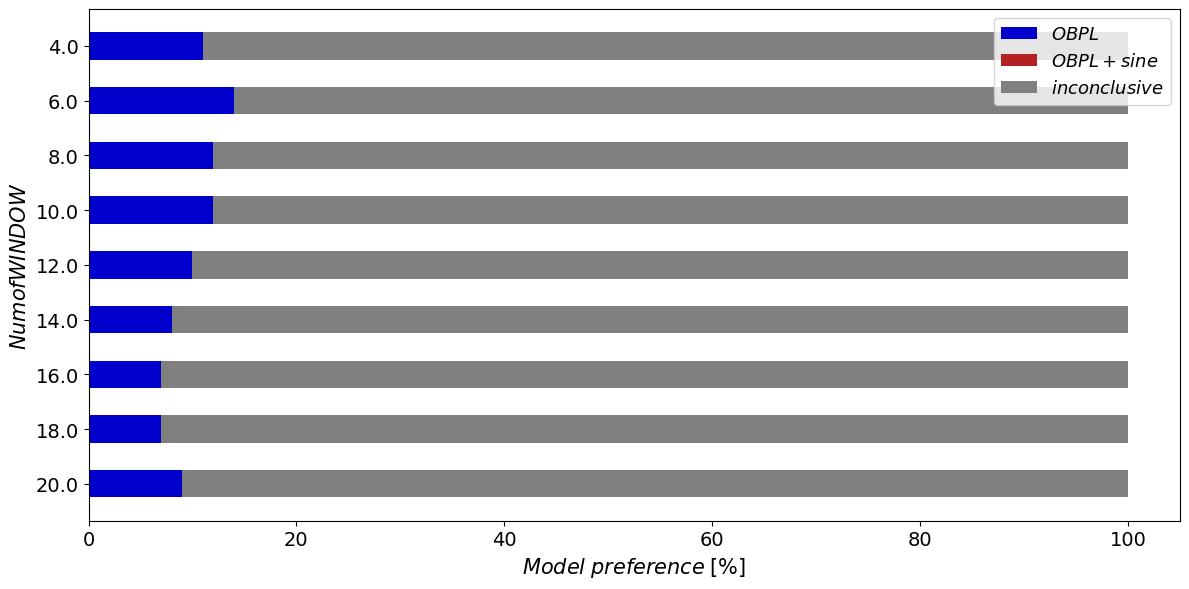

In [ ]:
OBSlength_plotter = statPLOTS(OBSlength_simdata2)

tDRW = OBSlength_plotter.plot_barchart('NumofWINDOW', model = 'DRW').sort_index(ascending=True)
tCARMA = OBSlength_plotter.plot_barchart('NumofWINDOW', model = 'CARMA21').sort_index(ascending=True)
tOBPL =  OBSlength_plotter.plot_barchart('NumofWINDOW', model = 'OBPL').sort_index(ascending=True)

In [ ]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    plt.figure(figsize=[16, 7.5])
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      color = ['blue', 'red', 'gray'],
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)*2) #edited part   
                rect.set_edgecolor('white')  
                rect.set_width(1 / float(n_df + 1)/1.5)

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index/2, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", edgecolor = 'white',hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[0.02, 0.81], fontsize =16, facecolor='white', framealpha=0.9)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.22,0.821], fontsize =16,  facecolor='white', framealpha=0.9) 
    axe.add_artist(l1)
    plt.tick_params(labelsize = 15)
    plt.xlabel(r'$Length\;of\;Observation\;[years]$', fontsize = 18)
    plt.ylabel(r'$Model\;preference$', fontsize = 18)
    plt.tight_layout()
    plt.show()
    return axe

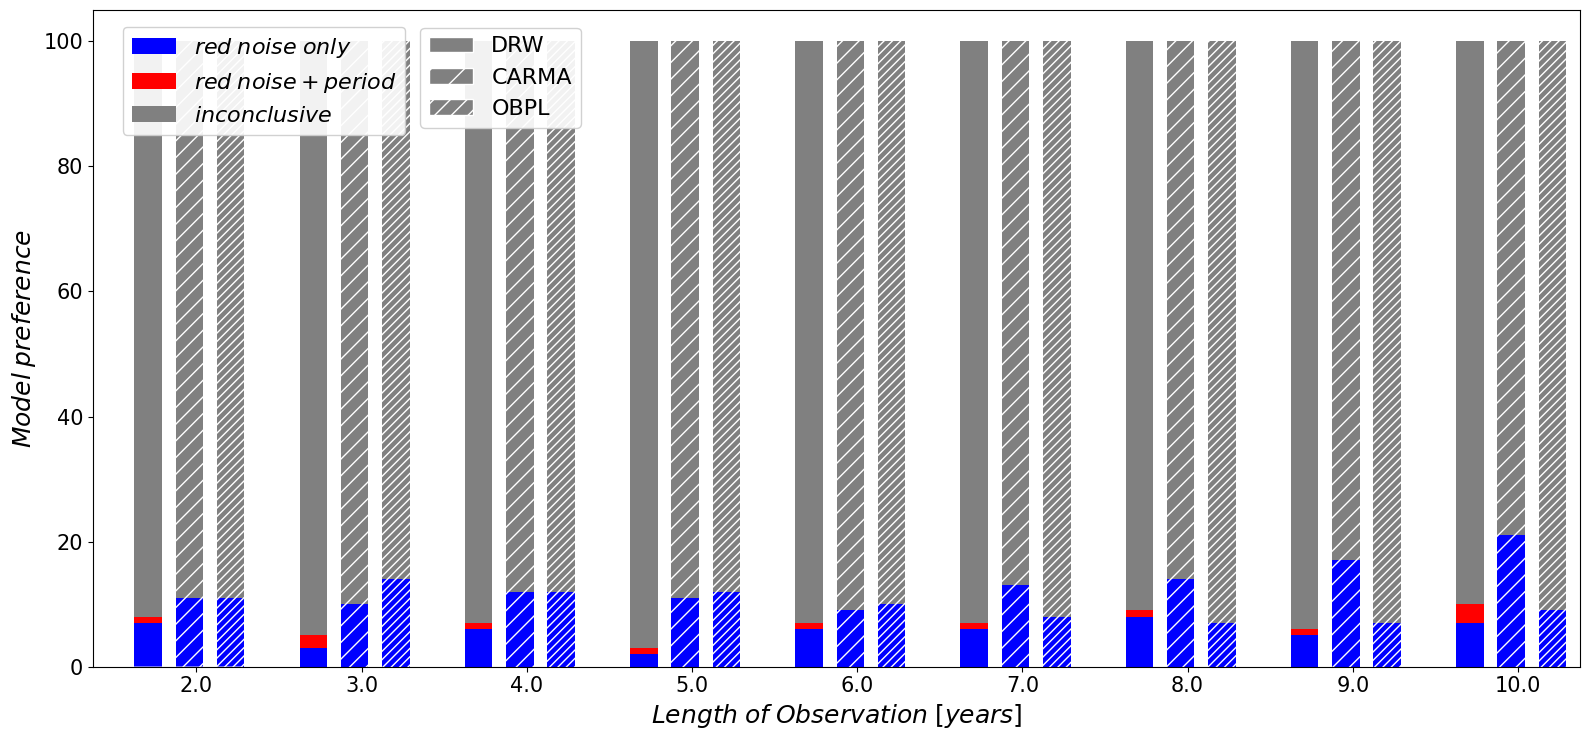

In [ ]:
_ = plot_clustered_stacked([tDRW,
                            tCARMA, 
                            tOBPL],['DRW', 'CARMA', 'OBPL'])


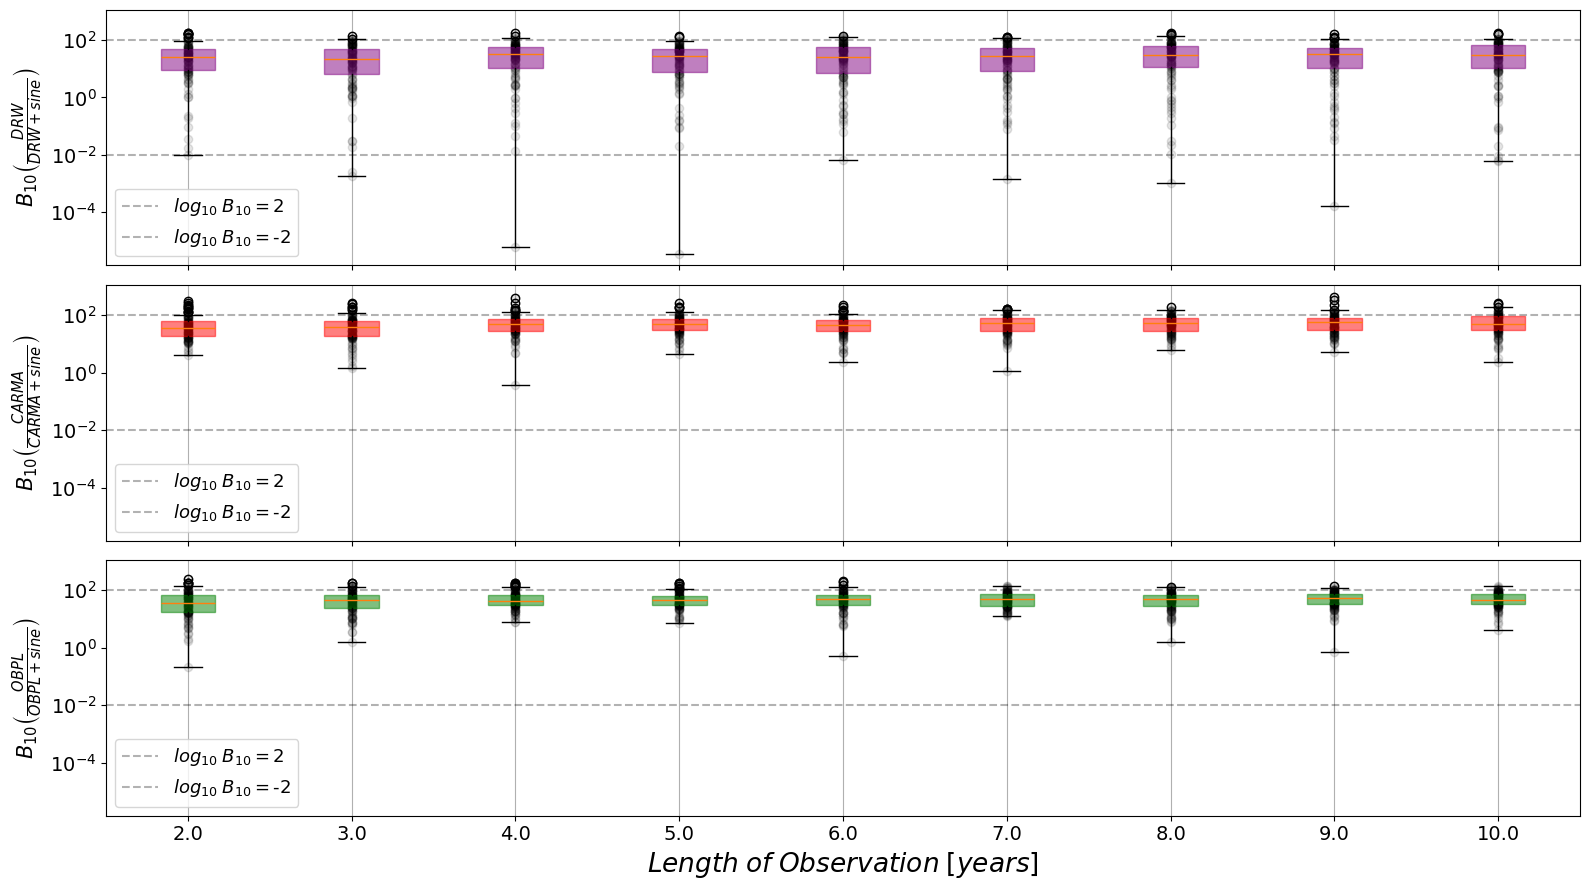

In [ ]:
OBSlength_plotter.plot_bayesDistri('NumofWINDOW', model = 'all', plottype='box')

4.0
6.0
8.0
10.0
12.0
14.0
16.0
18.0
20.0


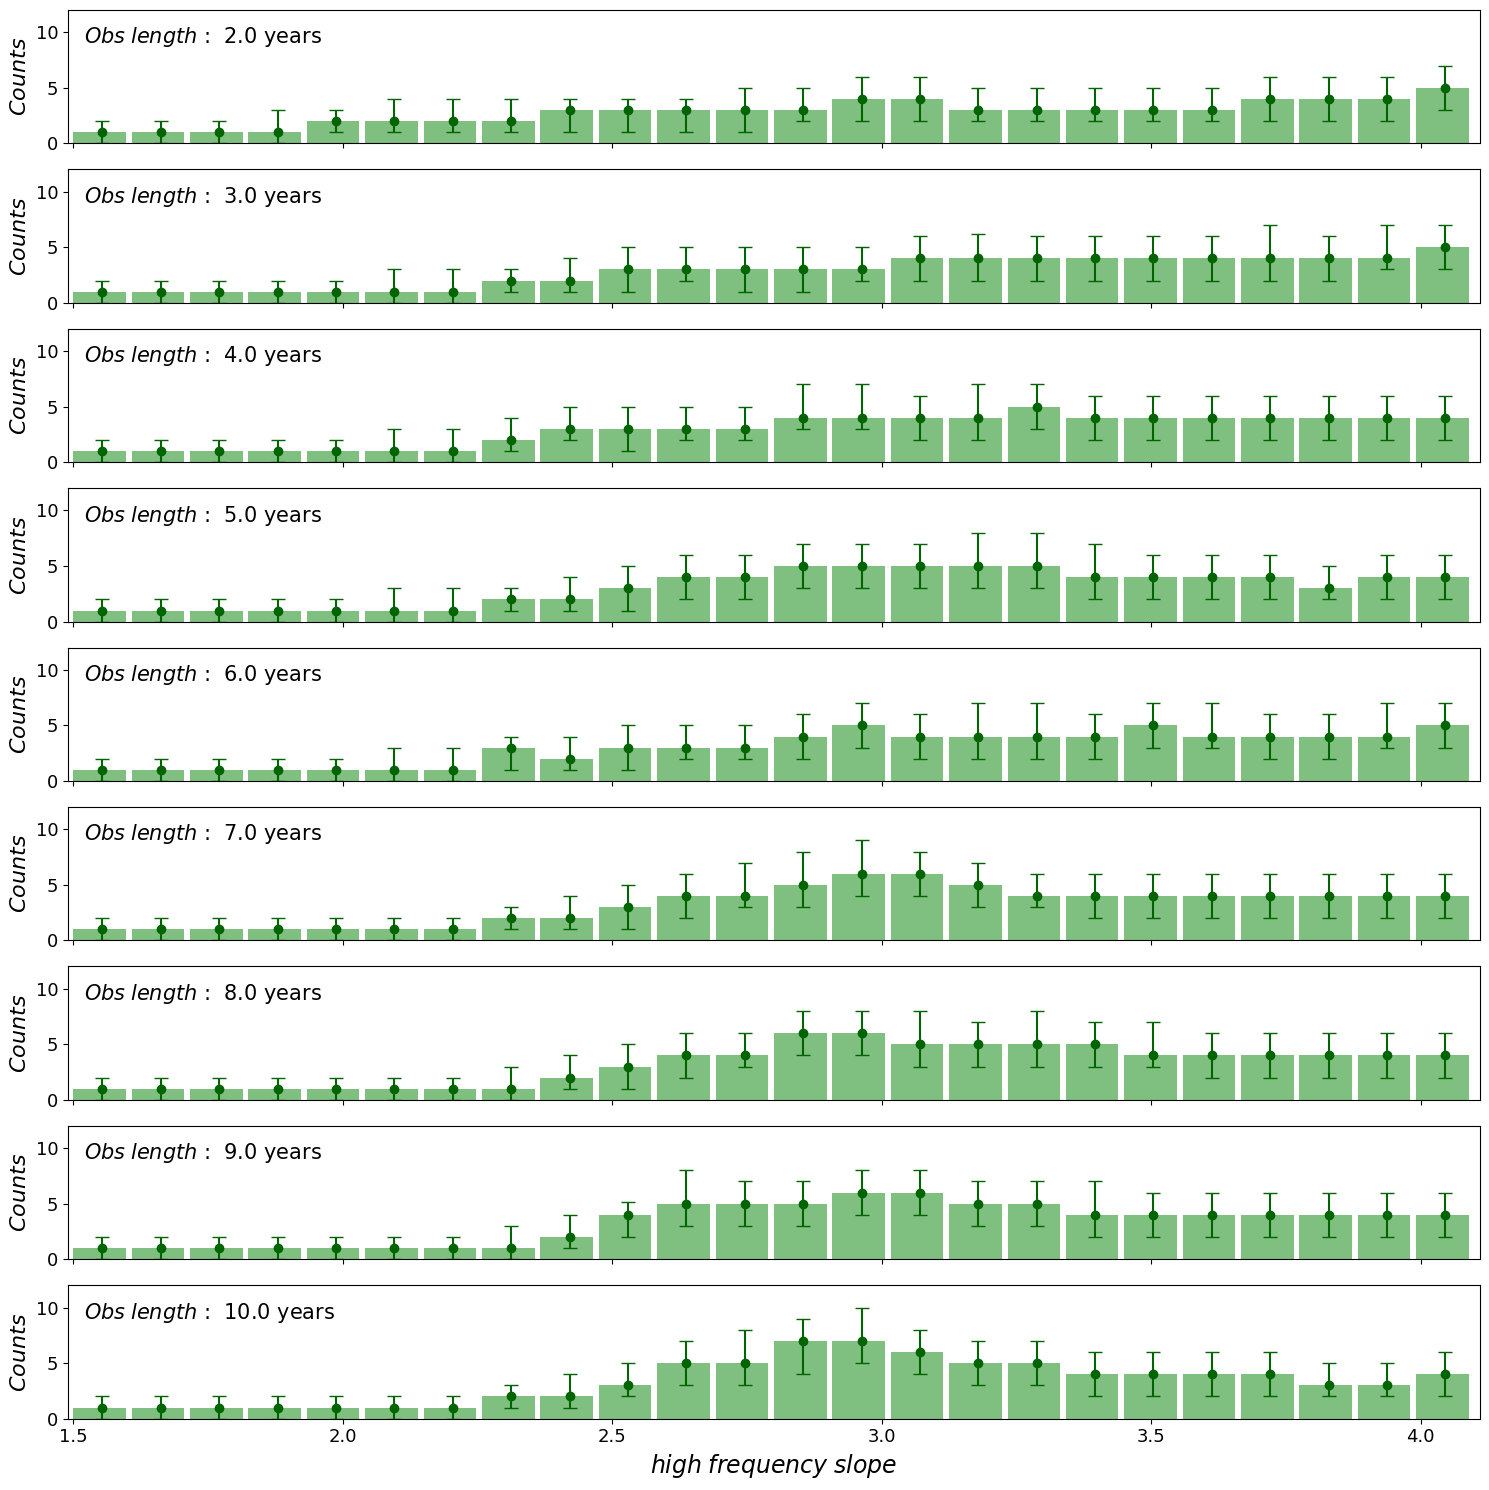

In [ ]:

fig, ax = plt.subplots(9, 1, figsize= [15, 15], sharex = True, sharey=True)

NumofWINDOW_array = list(set(OBSlength_simdata2.NumofWINDOW.to_numpy()))
NumofWINDOW_array.sort()
NumofWINDOW_array.reverse()

NumofWINDOW_croped = NumofWINDOW_array
NumofWINDOW_croped.reverse()

for i in range(len(NumofWINDOW_croped)):
    simDATA_filterd = OBSlength_simdata2.loc[(OBSlength_simdata2.NumofWINDOW ==NumofWINDOW_croped[i])]

    IDlist = simDATA_filterd.ID.to_numpy()
    print(NumofWINDOW_croped[i])
    param_val_array_test = []
    test = []
    for val in IDlist:
        jfile = load_json('json_files/final/numWIND/numWIND/' + str(int(val)) + '_OBPL10.json')
        param_val_array_test.append(jfile['alpha_h'])
        test.append(len(jfile['alpha_h']))

    param_val_array = []
    for val in IDlist:
        jfile = load_json('json_files/final/numWIND/numWIND/' + str(int(val)) + '_OBPL10.json')
        param_val_array.append(jfile['alpha_h'][:min(test)])

    np.random.seed(0)
    posterior_samples = np.array(param_val_array)

    def generate_sample_set(posterior_samples):
        return [np.random.choice(samples) for samples in posterior_samples]


    N = 2000
    sample_sets = [generate_sample_set(posterior_samples) for _ in range(N)]

    #bins = 25
    all_samples = [sample for sample_set in sample_sets for sample in sample_set]
    bin_edges = np.linspace(1.5, 4.1, 25)

    all_histograms = np.array([np.histogram(sample_set, bins=bin_edges)[0] for sample_set in sample_sets])

    mean_hist = np.median(all_histograms, axis=0)
    std_hist = np.percentile(all_histograms, [16, 84], axis=0)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

   
    #ax[i].hist(all_samples, bins=bin_edges, alpha=0.7,  color='blue', edgecolor='black', label='Histogram of Samples')
    ax[i].errorbar(bin_centers, mean_hist, yerr=[mean_hist - std_hist[0], std_hist[1]-mean_hist], fmt='o', color='darkgreen', ecolor='darkgreen', capsize=5)
    for j in range(len(mean_hist)):
        ax[i].add_patch(Rectangle((bin_edges[j], 0), 0.9*(bin_centers[1] - bin_centers[0]), mean_hist[j] ,
                        facecolor = 'green',
                        fill=True, alpha=0.5))
    #bplot = ax[i].boxplot(all_histograms, positions=np.round(bin_centers, decimals=2), widths=0.05, patch_artist=True)
    # whiskerprops_dict = dict(color = 'darkgreen')
    # capprops_dict = dict(color = 'darkgreen')
    # medianprops_dict = dict(color = 'darkgreen')
    # bplot = ax[i].boxplot(all_histograms, positions=np.round(bin_centers, decimals=2), 
    #                       widths=0.1, 
    #                       showfliers =False, whiskerprops =whiskerprops_dict,
    #                       capprops = capprops_dict, 
    #                       medianprops= medianprops_dict,
    #                       patch_artist=True)
    # for patch in bplot['boxes']:
    #     patch.set_color('green')
    #     patch.set_alpha(0.5)
        
        
    #ax[i].axvline(highalpha_croped[i]*-1, ls = '--', color = 'black')
    #ax[i].legend(fontsize = 14, loc = 'upper right')
    ax[i].text(1.52,9 , r'$Obs\;length$ :  ' + str(np.round(NumofWINDOW_croped[i]/2, decimals = 2)) + ' years', fontsize = 15)
    ax[i].tick_params(labelsize = 13)
    ax[i].set_xlim(1.49, 4.11)
    ax[1].set_ylim(0, 12)
    ax[i].set_ylabel('$Counts$', fontsize = 16)
plt.xlabel(r'$high\;frequency\;slope$', fontsize = 17)
plt.tight_layout()
plt.show()




# Window width

In [ ]:
class statPLOTS:
    def __init__(self, data_file) -> None:
        if isinstance(data_file, str):
            self.datafile = pd.read_csv(data_file)
            
        if isinstance(data_file, pd.DataFrame):
            self.datafile = data_file
            
    
    def get_dataframe(self):
        return self.datafile
    
    def fillna_model_counts(self, dictionary):
    
        BMCdict = dictionary.copy()
        for key in dictionary:

            if (key[0], 0) not in dictionary:
                BMCdict[(key[0], 0)] = 0
            if (key[0], 1) not in dictionary:
                BMCdict[(key[0], 1)] = 0
            if (key[0], -1) not in dictionary:
                BMCdict[(key[0], -1)] = 0

        return BMCdict
    
    
    
    
    def plot_barchart(self, param, model = 'DRW', xarray = [-99]):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
        
        BMCdict =  self.fillna_model_counts(self.datafile.groupby(param)[[boolvar]].value_counts().to_dict())
        BMCdict = dict(sorted(BMCdict.items(), key=lambda x: x[0]))
        x_array = []
        noise_value_counts = []
        noisesine_value_counts = []
        inc_value_counts = []
        for key in BMCdict:
            if key[1]==0:
                x_array.append(key[0])
                inc_value_counts.append(BMCdict[key])
            elif key[1]==1:
                noisesine_value_counts.append(BMCdict[key])
            elif key[1]==-1:
                noise_value_counts.append(BMCdict[key])

        if xarray[0] == -99:
            pass
        else:
            x_array = xarray
        noise_value_counts = np.array(noise_value_counts)
        noisesine_value_counts = np.array(noisesine_value_counts)
        inc_value_counts = np.array(inc_value_counts)  

        sumofall = noise_value_counts + noisesine_value_counts + inc_value_counts
        plt.figure(figsize=[12, 6])
        plt.barh(np.round(x_array,decimals=5).astype('str'), noise_value_counts*100/sumofall, height=0.5, color='mediumblue' )
        plt.barh(np.round(x_array,decimals=5).astype('str'), noisesine_value_counts*100/sumofall, left=noise_value_counts*100/sumofall, height=0.5,  color='firebrick')
        plt.barh(np.round(x_array,decimals=5).astype('str'), inc_value_counts*100/sumofall, left= np.array(noise_value_counts*100/sumofall) + np.array(noisesine_value_counts*100/sumofall), height=0.5,  color='gray')
        plt.tight_layout()
        plt.legend(['$'+ model+'$', '$'+ model+' + sine$', '$inconclusive$'], fontsize=13, loc = 'upper right')
        plt.ylabel('$'+ param+'$', fontsize=15)
        plt.xlabel('$Model\;preference\;[\%]$', fontsize=15)
        plt.gca().invert_yaxis()
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        #plt.savefig('plots/DRWsine_highalpha_2_4.png', )
        plt.show()
        return pd.DataFrame(np.array([noise_value_counts,noisesine_value_counts, inc_value_counts]).T,
                   index=np.round(x_array, decimals=2),
                   columns=[r"$red\;noise\;only$", r"$red\;noise + period$", r"$inconclusive$"])
        
    def plot_bayesDistri(self, param , model ='DRW', plottype = 'violin'):
        if model =='DRW':
            bayesvar_arr = ['DRW_DRWsine_bayes']
        if model =='CARMA21':
            bayesvar_arr = ['CARMA21_CARMA21sine_bayes']
        if model =='OBPL':
            bayesvar_arr =['OBPL10_OBPLsine10_bayes' ] 
        if model == 'all':
            bayesvar_arr =['DRW_DRWsine_bayes', 'CARMA21_CARMA21sine_bayes', 'OBPL10_OBPLsine10_bayes' ] 
            
        if model!='all':
            plt.figure(figsize=[10, 6])
            
            colors = ['purple', 'red', 'green']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                #x_array.reverse()

                x_array = x_array[0::2]
                x_array.append(-4)
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
            
                # for i in x_array:
                #     y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                #     plt.plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    plt.violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = plt.boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
            for i in [0.,  2, -2]:
                plt.axhline(10**i, label = 'log K = '+str(i), color = 'k', ls = '--')
                    
                    
            plt.xticks(x_array, labels=x_array)
            plt.yscale('log')
            #plt.gca().set_xticklabels()
            plt.legend(loc = 'lower right')
            plt.xlim(min(x_array) - diff/3, max(x_array) + diff/3)
            plt.xlabel(''+ param +'', fontsize = 13)
            plt.ylabel(r'$B_{10}\left(\frac{}{}\right)$'.format("{"+model+"}", "{"+model+" + sine }" ), fontsize =13)
            plt.tight_layout()
            plt.show()
            
            
        else:
            fig, ax = plt.subplots(3, 1, figsize=[16, 9], sharex=True, sharey=True)
            colors = ['purple', 'red', 'green']
            models = ['DRW', 'CARMA', 'OBPL']
            for j, bayesvar in enumerate(bayesvar_arr):
                box_plot_stack = []
                # x_array = list(set(self.datafile[param].to_list())) ; x_array.sort()
                # x_array = np.round(x_array, decimals=5)
                x_array = list(set(self.datafile[param].to_numpy()))
                x_array.sort()
                # x_array.reverse()

                x_array = np.array(x_array)#[np.array([0, 2, 4, 6, 8])]
                # x_array.append(-4)
                x_array = np.round(x_array, decimals=5)
                for i in x_array:
                    box_plot_stack.append(self.datafile.loc[np.round(self.datafile[param], decimals=5)== i][bayesvar].to_numpy())
                    
                for i in x_array:
                    y_array = self.datafile.loc[np.round(self.datafile[param], decimals=5) == i][bayesvar]
                    ax[j].plot(np.ones(len(y_array))*i, y_array, 'ko', alpha = 0.1  )
                
                diff = np.diff(x_array,n =1)[2]
                if plottype =='violin':
                    ax[j].violinplot(box_plot_stack, positions=x_array, widths=diff/3)
                elif plottype =='box':
                    bplot = ax[j].boxplot(box_plot_stack, positions=x_array, widths=diff/3, patch_artist=True)

                    for patch in bplot['boxes']:
                        patch.set_color(colors[int(j)])
                        patch.set_alpha(0.5)
                        
                for i in [ 2, -2]:
                    ax[j].axhline(10**i, label = '$log_{10}\;B_{10} = $'+str(i), color = 'k', ls = '--',alpha=0.3)
                    
                ax[j].set_xticks(x_array, labels=np.round(x_array/30/6/2, decimals=2))
                ax[j].set_yscale('log')
                ax[j].tick_params(labelsize = 14)
                #plt.gca().set_xticklabels()
                ax[j].legend(loc = 'lower right', fontsize = 13)
                #ax[j].set_xlim(min(x_array) - diff/5, max(x_array) + diff/5)
                #ax[j].set_xlim(3, 21)
                if j ==2:
                    ax[j].set_xlabel(r"$Dispersion\;level$", fontsize = 19)
                ax[j].grid(axis = 'x')
                ax[j].set_ylabel(r'$B_{}\left(\frac{}{}\right)$'.format("{"+str(10)+"}","{"+models[j]+"}", "{"+models[j]+" + sine }" ), fontsize =15)
                # ax[j].invert_xaxis()
            
            plt.tight_layout()
            plt.show()
                
                    
                    
                    
                    
                    
                    
    def confusion_matrix(self,  no_period_dataset, period_dataset, model='DRW'):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
            
        no_period_prediction = no_period_dataset[boolvar].value_counts().to_dict()
        period_prediction = period_dataset[boolvar].value_counts().to_dict()
        
        for i in [-1,0,1]:
            if i not in no_period_prediction.keys():
                no_period_prediction[i] = 0
            if i not in period_prediction.keys():
                period_prediction[i] = 0
        
        confusion_matrix = np.zeros((2, 3), dtype=int)

        confusion_matrix[0, 0] = no_period_prediction[0]
        confusion_matrix[0, 1] = no_period_prediction[-1]
        confusion_matrix[0, 2] = no_period_prediction[1]
        confusion_matrix[1, 0] = period_prediction[0]
        confusion_matrix[1, 1] = period_prediction[-1]
        confusion_matrix[1, 2] = period_prediction[1]
        
        plt.figure(figsize=(12, 7))
        sns.set(font_scale=1.1)
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                    xticklabels=['$inconclusive$', '$Noise\;only\;prefered$', '$periodic\;model\;prefered$'],
                    yticklabels=['$No\;periodicity\;simulated$', '$Periodicity\;simulated$'], square=True, annot_kws={'size': 12})

        plt.xlabel('Predicted', fontsize = 16, weight = 'bold')
        plt.ylabel('True', fontsize = 16, weight = 'bold')
        plt.tight_layout()
        plt.show()
        


In [ ]:
# WINDOWwidth_simdata = datacollector(csv_file_path= 'simDATAcsvs/simDATA_highALPHA_3_WINDOWwidth_2_12.csv',
#                          json_files_path='json_files/results_WINDOWwidth_2_11/json_files/WINDOWwidth_2_12/outputs/')


WINDOWwidth_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_WINDOWwidth_2_12.csv',
                         json_files_path='json_files/final/windWIDTH/final/')

Collected all json files...


Gathering data from json files to dataframe:   0%|          | 0/600 [00:00<?, ?it/s]

Gathering data from json files to dataframe: 100%|██████████| 600/600 [00:42<00:00, 14.14it/s]


In [ ]:
row = WINDOWwidth_simdata[101:102]

l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=False)
l.LCsimulator()
simTIME_nar, simLC_nar, simLCerr_nar , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=False)

row = WINDOWwidth_simdata[501:502]
l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=False)
l.LCsimulator()
simTIME_br, simLC_br, simLCerr_br , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=False)

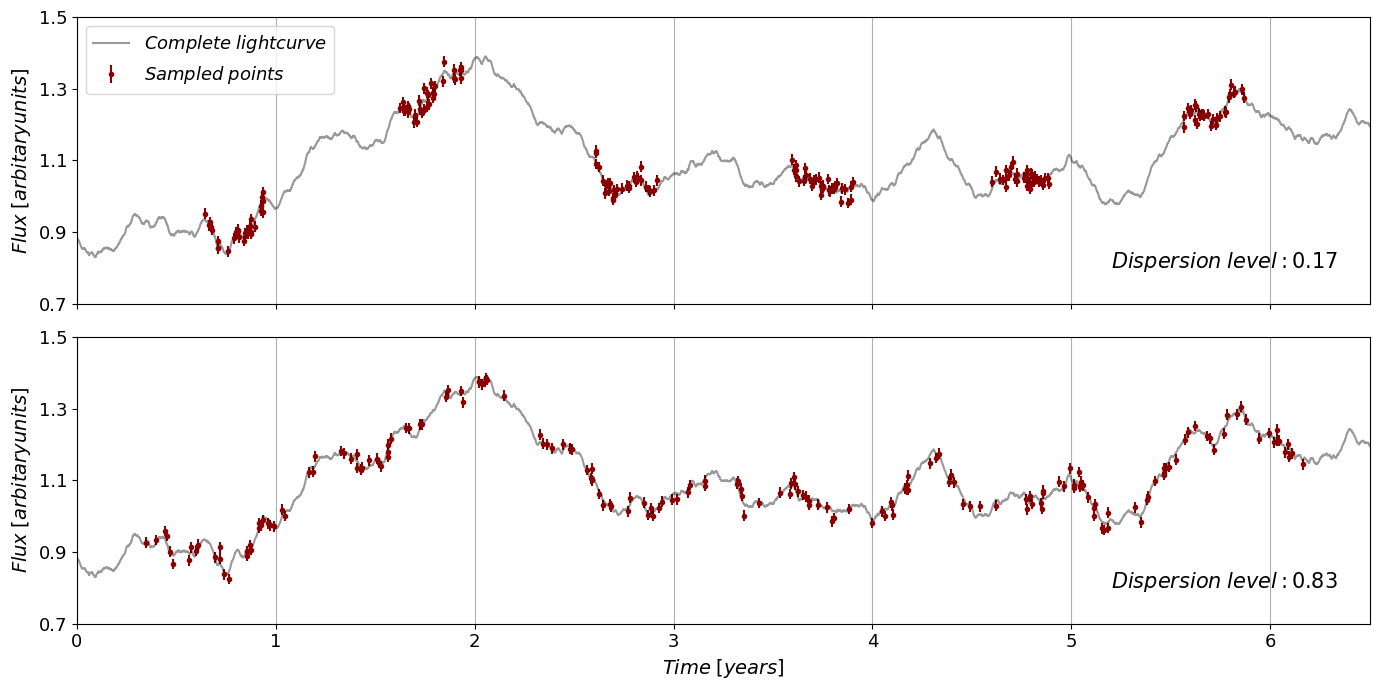

In [ ]:
fig, ax  = plt.subplots(2,1, figsize = [14,7],sharex=True, sharey=True)

ax[0].errorbar(simTIME_nar-13.5, simLC_nar, yerr = simLCerr_nar, fmt = '.', color = 'darkred', label = '$Sampled\;points$')
ax[0].plot(lc.time/365-13.5, lc.counts, 'k-', alpha = 0.4, label = '$Complete\;lightcurve$')
ax[0].set_xlim(0, 6.5)
ax[0].set_ylim(0.7, 1.5)
ax[0].set_yticks(np.linspace(0.7, 1.5, 5))
ax[0].tick_params(labelsize =13)
ax[0].grid(axis = 'x')
ax[0].text(5.2, 0.8, '$Dispersion\;level : 0.17$', fontsize = 15)
ax[0].legend(fontsize = 13)
ax[0].set_ylabel('$Flux\;[arbitary units]$', fontsize = 14)


ax[1].errorbar(simTIME_br-13.5, simLC_br, yerr = simLCerr_br, fmt = '.', color = 'darkred')
ax[1].plot(lc.time/365-13.5, lc.counts, 'k-', alpha = 0.4, label = '$Complete\;lightcurve$')
#ax[0].set_yticks(np.linspace(0.7, 1.5, 5))
ax[1].tick_params(labelsize =13)
ax[1].grid(axis = 'x')
ax[1].text(5.2, 0.8, '$Dispersion\;level : 0.83$', fontsize = 15)
ax[1].set_ylabel('$Flux\;[arbitary units]$', fontsize = 14)
ax[1].set_xlabel('$Time\;[years]$', fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
WINDOWwidth_simdata.NumofWINDOW

0      6
1      6
2      6
3      6
4      6
      ..
595    6
596    6
597    6
598    6
599    6
Name: NumofWINDOW, Length: 600, dtype: int64

In [ ]:
t = list(set(WINDOWwidth_simdata.WINDOWwidth))
t.sort()
np.array(t)/30

array([ 2. ,  3.8,  5.6,  7.4,  9.2, 11. ])

INFO[2024-07-31 17:17:20,822]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:20,823]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:20,829]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:20,832]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


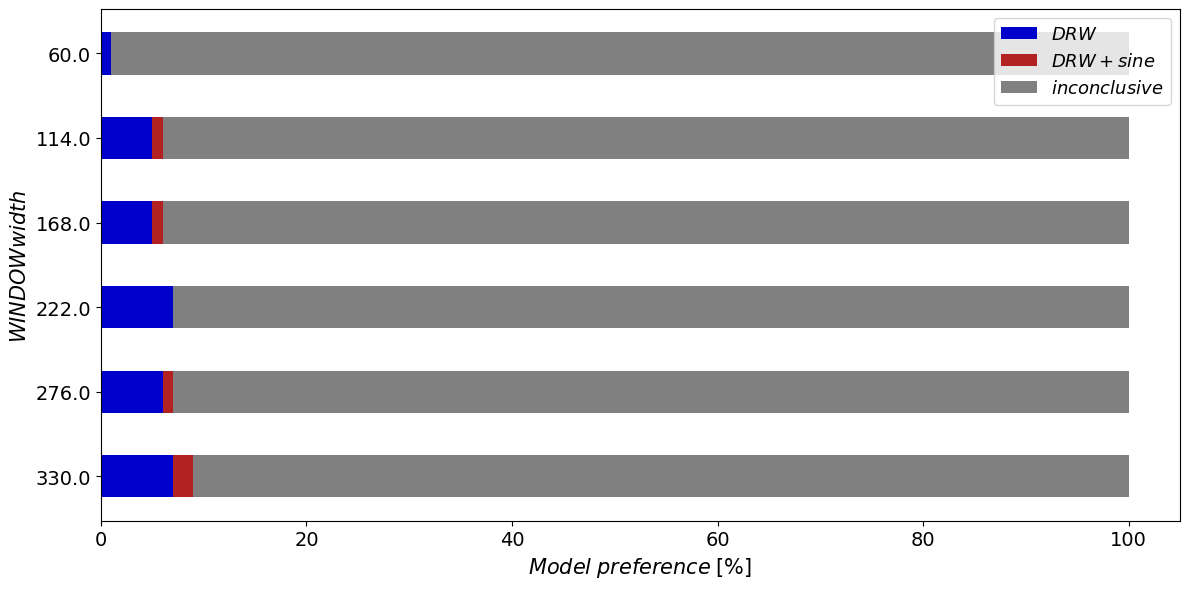

INFO[2024-07-31 17:17:21,038]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,039]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,043]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,047]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


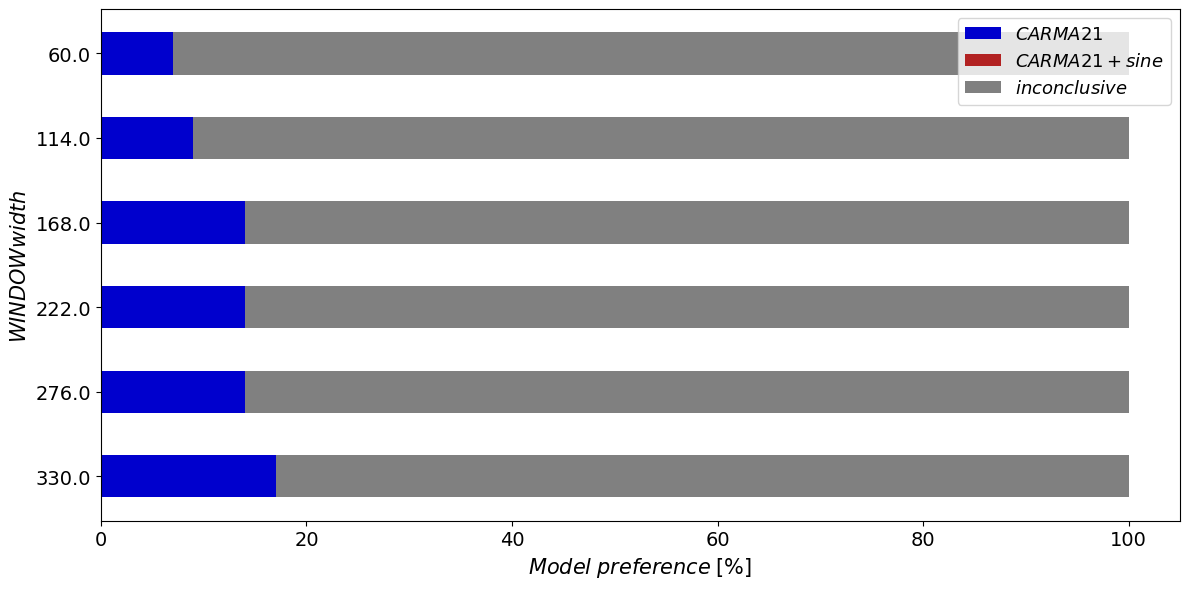

INFO[2024-07-31 17:17:21,215]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,216]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,220]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO[2024-07-31 17:17:21,223]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


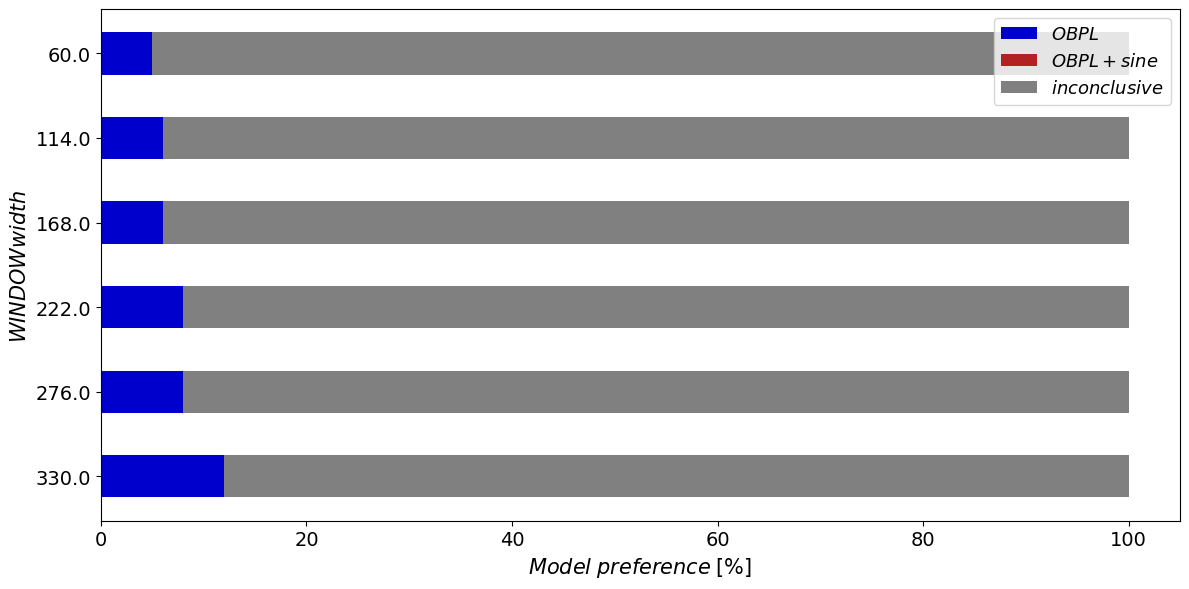

In [ ]:
WINDOWwidth_plotter = statPLOTS(WINDOWwidth_simdata)

tDRW = WINDOWwidth_plotter.plot_barchart('WINDOWwidth', model = 'DRW').sort_index(ascending=True)
tCARMA = WINDOWwidth_plotter.plot_barchart('WINDOWwidth', model = 'CARMA21').sort_index(ascending=True)
tOBPL =  WINDOWwidth_plotter.plot_barchart('WINDOWwidth', model = 'OBPL').sort_index(ascending=True)

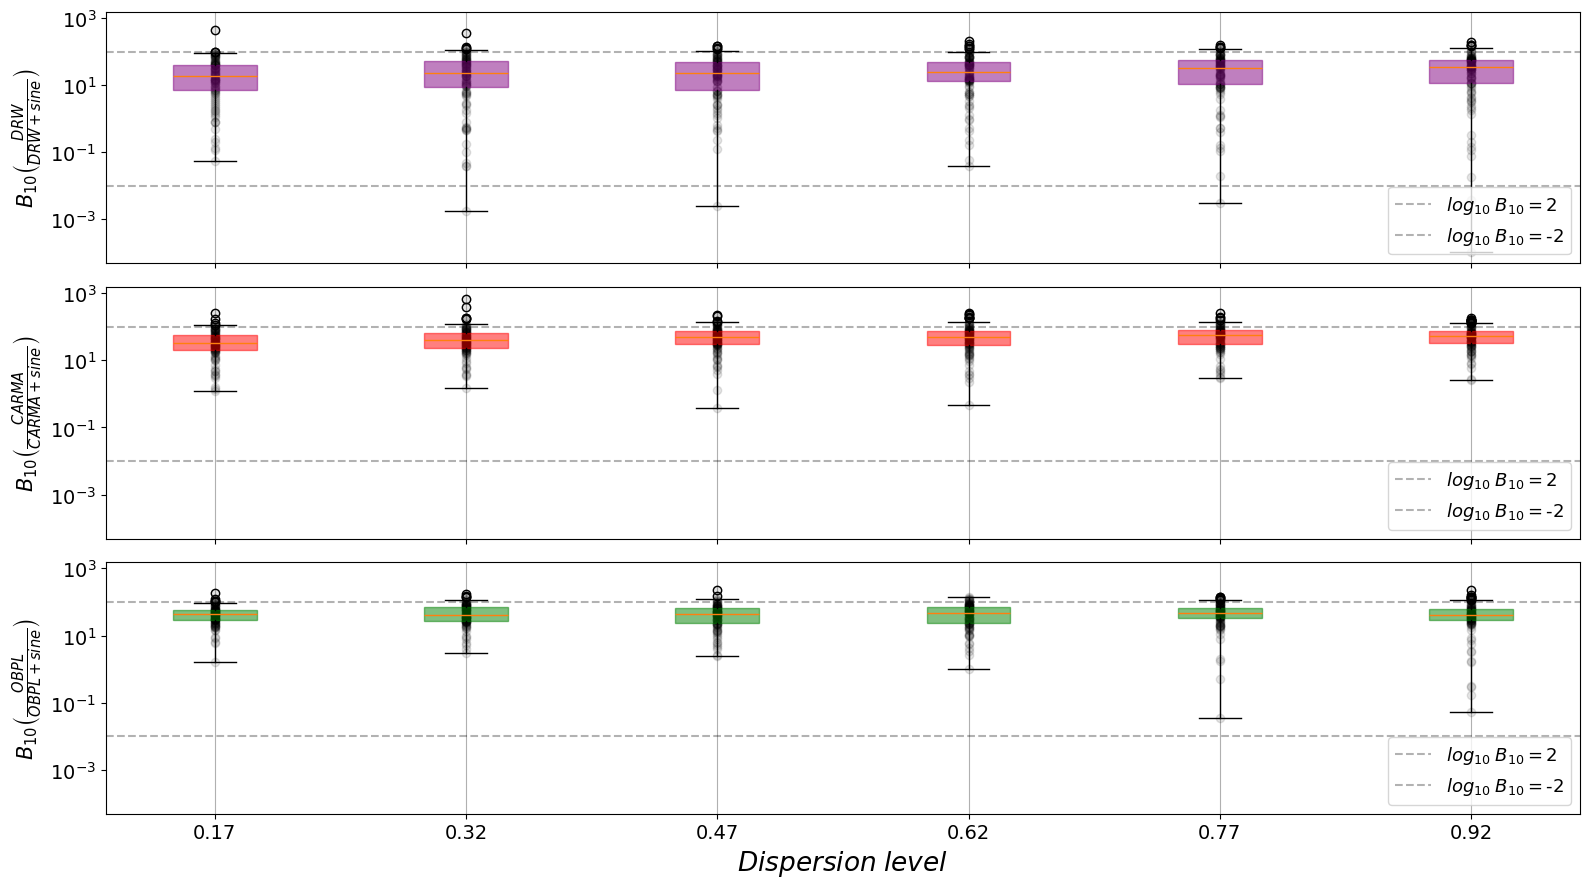

In [ ]:
WINDOWwidth_plotter.plot_bayesDistri(param = 'WINDOWwidth', model ='all', plottype = 'box')

In [ ]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    plt.figure(figsize=[16, 7.5])
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      color = ['blue', 'red', 'gray'],
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)*2) #edited part   
                rect.set_edgecolor('white')  
                rect.set_width(1 / float(n_df + 1)/1.5)

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(np.round(df.index/30/6/2, decimals=2), rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", edgecolor = 'white',hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[0.02, 0.81], fontsize =16, facecolor='white', framealpha=0.9)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.22,0.821], fontsize =16,  facecolor='white', framealpha=0.9) 
    axe.add_artist(l1)
    plt.tick_params(labelsize = 15)
    plt.xlabel(r'$Dispersion\;level$', fontsize = 18)
    plt.ylabel(r'$Model\;preference$', fontsize = 18)
    plt.tight_layout()
    plt.show()
    return axe

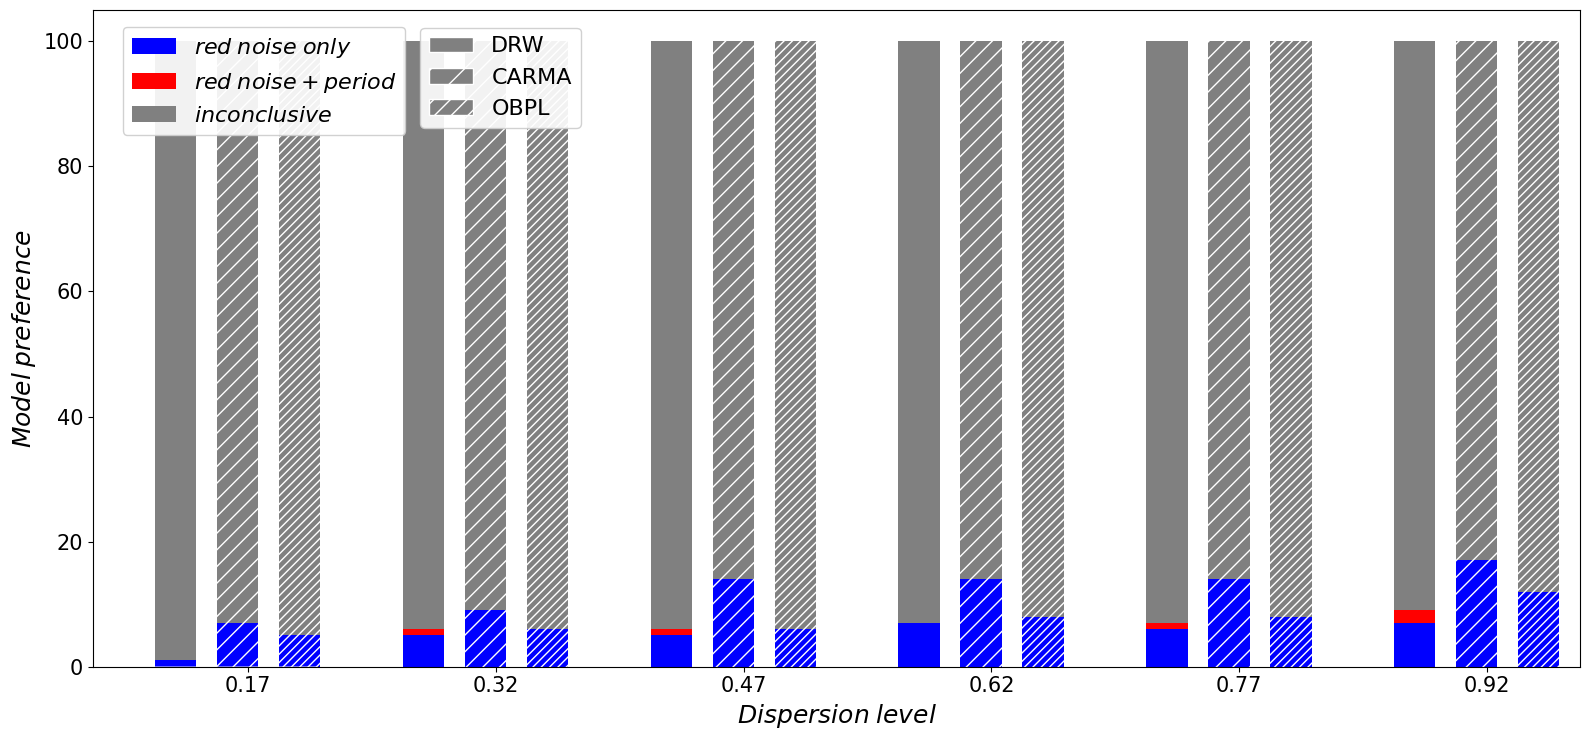

In [ ]:
# _ = plot_clustered_stacked([tDRW.iloc[list(np.arange(0, 9, 1).astype('int'))],
#                             tCARMA.iloc[list(np.arange(0, 9, 1).astype('int'))], 
#                             tOBPL.iloc[list(np.arange(0, 9, 1).astype('int'))]],['DRW', 'CARMA', 'OBPL'])

_ = plot_clustered_stacked([tDRW,
                            tCARMA, 
                            tOBPL],['DRW', 'CARMA', 'OBPL'])


# periods

In [ ]:
periodicity_simdata_1year = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_20_period_1.25_7.5_A1_0.1125_0.75_bendf_1year.csv',
                         json_files_path='json_files/final/periodicity_1year/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 3600/3600 [04:28<00:00, 13.40it/s]


In [ ]:
no_periodicity_simdata_1year = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_20_A1_0_bendf_1year.csv',
                         json_files_path='json_files/final/periodicity_1year/noper/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 100/100 [00:07<00:00, 13.87it/s]


In [ ]:
periodicity_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_20_period_1.25_7.5_A1_0.1125_0.75.csv',
                         json_files_path='json_files/final/periodicity/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 3600/3600 [04:44<00:00, 12.67it/s]


In [ ]:
no_periodicity_simdata = datacollector(csv_file_path= 'simDATAcsvs/final/simDATA_highALPHA_3_NumofWINDOW_20_A1_0.csv',
                         json_files_path='json_files/final/periodicity/noper/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


In [ ]:
def confusion_matrix( no_period_dataset, period_dataset, model='DRW'):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
            
        no_period_prediction = no_period_dataset[boolvar].value_counts().to_dict()
        period_prediction = period_dataset[boolvar].value_counts().to_dict()
        
        for i in [-1,0,1]:
            if i not in no_period_prediction.keys():
                no_period_prediction[i] = 0
            if i not in period_prediction.keys():
                period_prediction[i] = 0
        
        confusion_matrix = np.zeros((2, 3), dtype=int)

        confusion_matrix[0, 0] = no_period_prediction[0]
        confusion_matrix[0, 1] = no_period_prediction[-1]
        confusion_matrix[0, 2] = no_period_prediction[1]
        confusion_matrix[1, 0] = period_prediction[0]
        confusion_matrix[1, 1] = period_prediction[-1]
        confusion_matrix[1, 2] = period_prediction[1]
        
        #row_sums = confusion_matrix.sum(axis=1)
        #new_matrix = confusion_matrix / row_sums[:,np.newaxis]
        new_matrix = confusion_matrix
        
        plt.figure(figsize=(10, 7))
        # sns.set(font_scale=1.2)
        #[['inconclusive', 'True Negative', 'False Postive'],['inconclusive', 'False Negative', 'True Positive']]
        sns.heatmap(new_matrix, annot=True, cmap='Blues',
                    xticklabels=['$inconclusive$', '$Noise\;only\;prefered$', '$periodic\;model\;prefered$'],
                    yticklabels=['$No\;periodicity\;simulated$', '$Periodicity\;simulated$'], square=False, annot_kws={'size': 17})

        plt.xlabel('Predicted', fontsize = 18, weight = 'bold')
        plt.ylabel('True', fontsize = 18, weight = 'bold')
        plt.tight_layout()
        plt.show()
        return new_matrix

In [ ]:
A1_array = list(set(periodicity_simdata.A1.to_numpy()))
A1_array.sort()
period_array = list(set(periodicity_simdata.period.to_numpy()))
period_array.sort()
np.array(A1_array)/0.15, np.array(period_array)

(array([0.75, 1.6 , 2.45, 3.3 , 4.15, 5.  ]),
 array([1.25, 2.5 , 3.75, 5.  , 6.25, 7.5 ]))

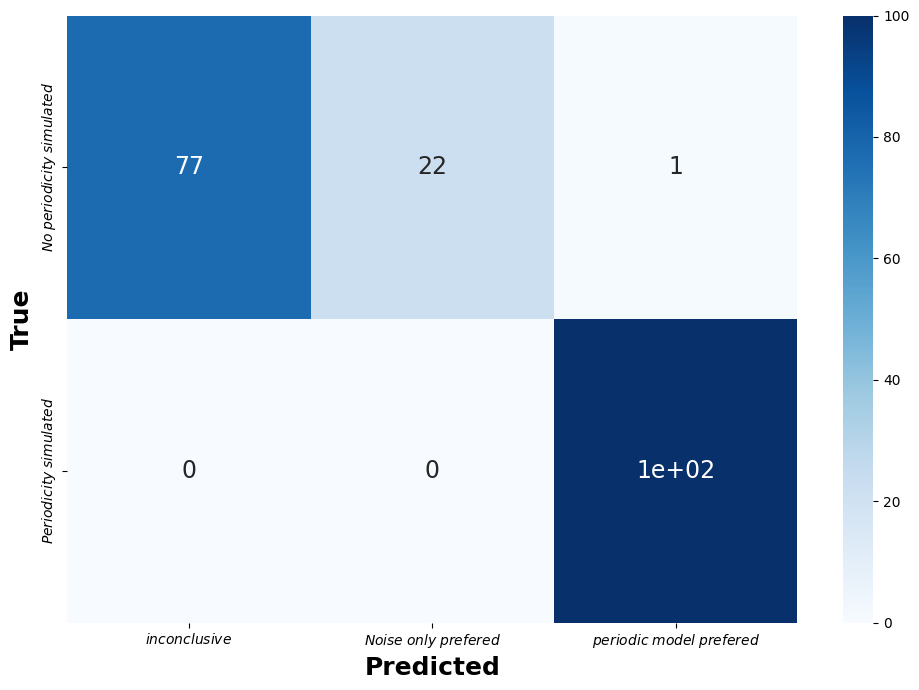

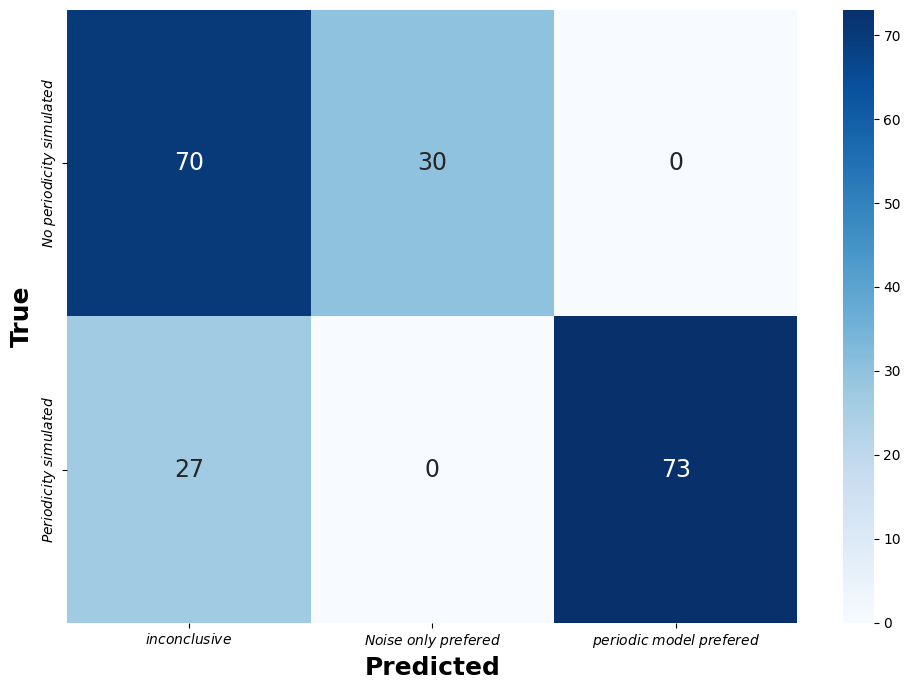

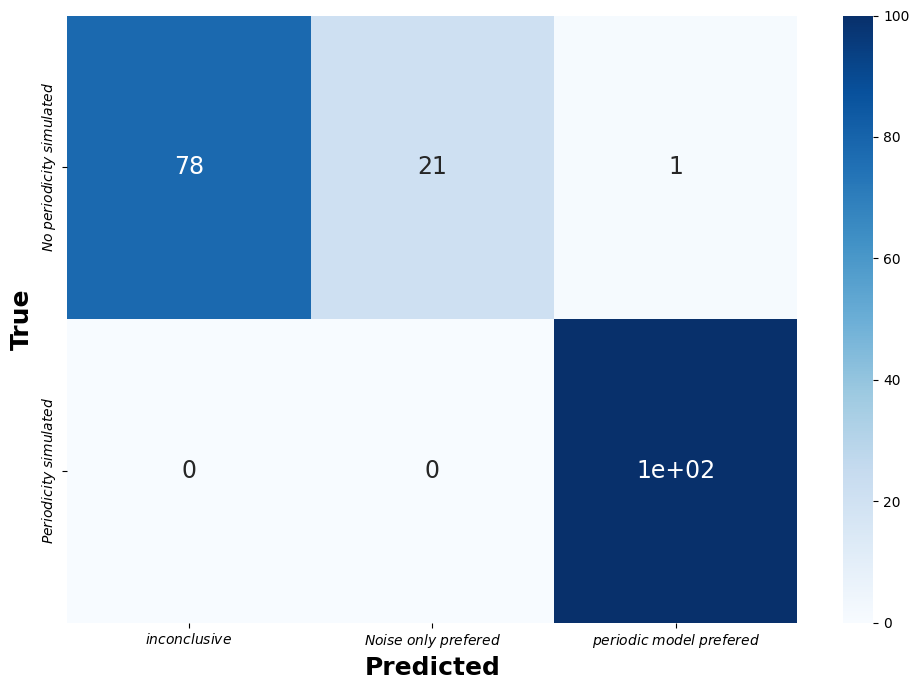

In [ ]:
A1_ind  = 5
period_ind  = 0

DRW_matrix = confusion_matrix(no_period_dataset = no_periodicity_simdata.loc[(no_periodicity_simdata.A1==0) ], 
                        period_dataset=periodicity_simdata .loc[(periodicity_simdata .A1==A1_array[A1_ind]) &  (periodicity_simdata .period==period_array[period_ind])], model='DRW')#& (simdata1.bendfreq != bf_array[bf_ar_ind]) ], model='DRW')
CARMA_matrix = confusion_matrix(no_period_dataset = no_periodicity_simdata.loc[(no_periodicity_simdata.A1==0) ],#& (simdata1.bendfreq != bf_array[bf_ar_ind])], 
                        period_dataset=periodicity_simdata .loc[(periodicity_simdata .A1==A1_array[A1_ind]) &  (periodicity_simdata .period==period_array[period_ind])], model='CARMA21')#& (simdata1.bendfreq != bf_array[bf_ar_ind]) ], model='CARMA21')
OBPL_matrix = confusion_matrix(no_period_dataset = no_periodicity_simdata.loc[(no_periodicity_simdata.A1==0)],# & (simdata1.bendfreq != bf_array[bf_ar_ind])], 
                        period_dataset=periodicity_simdata .loc[(periodicity_simdata .A1==A1_array[A1_ind]) &  (periodicity_simdata .period==period_array[period_ind])], model='OBPL')#& (simdata1.bendfreq != bf_array[bf_ar_ind]) ], model='OBPL')

In [ ]:
def draw_pie(dist, xpos, ypos, size, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    #print(pie)
    for i, (r1, r2) in enumerate(zip(pie[:-1], pie[1:])):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        if i==0:
            ax.scatter([xpos], [ypos], marker=xy, s=size, facecolor = 'gray')
        if i==1:
            ax.scatter([xpos], [ypos], marker=xy, s=size, facecolor = 'red')
        if i==2:
            ax.scatter([xpos], [ypos], marker=xy, s=size, facecolor = 'blue')

    #ax.pie(dist, center=(xpos, ypos), radius=size, colors =['r', 'b'])
    return ax


def get_best_model_counts(dictionary):
    
    BMCdict = dictionary.copy()
    for key in dictionary:

        if (key[0], key[1], 0) not in dictionary:
            BMCdict[(key[0], key[1], 0)] = 0
        if (key[0], key[1], 1) not in dictionary:
            BMCdict[(key[0], key[1], 1)] = 0
        if (key[0], key[1], -1) not in dictionary:
            BMCdict[(key[0], key[1], -1)] = 0

    return BMCdict

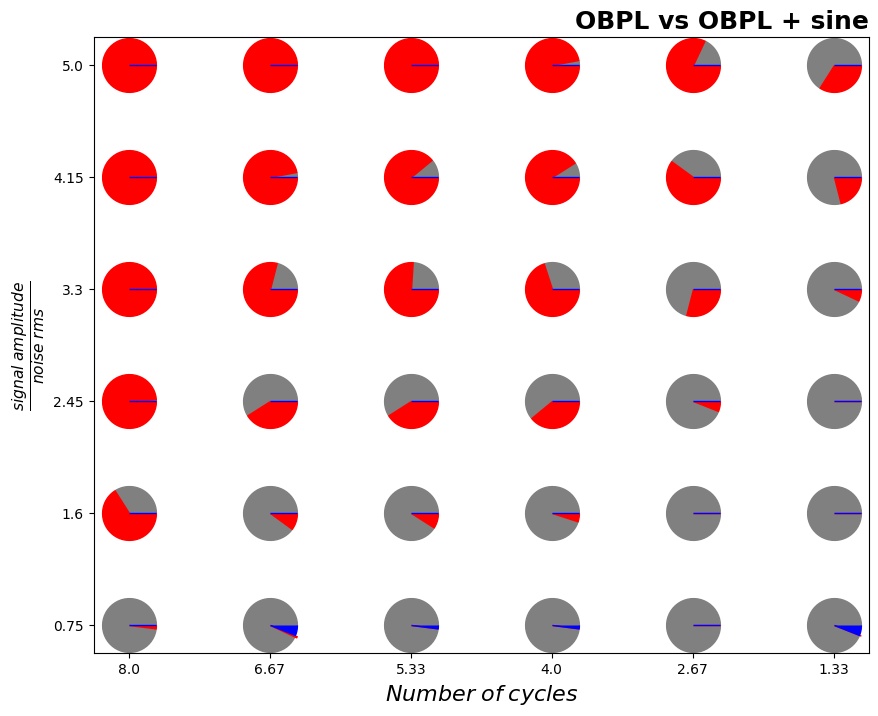

In [ ]:

if True:
    BMCdict_DRW = get_best_model_counts(dictionary = periodicity_simdata.groupby(['period', 'A1'])[['OBPLsine_bool']].value_counts().to_dict())
    BMCdict_DRW = dict(sorted(BMCdict_DRW.items(), key=lambda x: x[0]))
    # period_array = []
    # A1_array = []
    DRW_value_counts = []
    DRWsine_value_counts = []
    #FNR_dict = {}
    DRW_value_count_dict = {}
    for key in BMCdict_DRW:
        if key[2]==0:
            # period_array.append(key[0])
            # A1_array.append(key[1])
            #DRW_value_counts.append(BMCdict_DRW[key])
            #FNR_dict[(key[0], key[1])] = BMCdict_DRW[(key[0], key[1], 0)]/(BMCdict_DRW[(key[0], key[1], 0)] + BMCdict_DRW[(key[0], key[1], 1)] )
            DRW_value_count_dict[(key[0], key[1])] = (BMCdict_DRW[(key[0], key[1], 0)], BMCdict_DRW[(key[0], key[1], 1)], BMCdict_DRW[(key[0], key[1], -1)])
            # print(key[0]/3, key[1]/0.15, '-->', DRW_value_count_dict[(key[0], key[1])])

        #elif key[2]==1:
            #DRWsine_value_counts.append(BMCdict_DRW[key])
            

    fig, ax = plt.subplots(1,1, figsize=[10,8])
    for key in DRW_value_count_dict:
        
        #ax.pie(DRW_value_count_dict[key], center=(key[0], key[1]) radius = 0.0, colors=['tab:blue', 'tab:orange'])
        draw_pie(DRW_value_count_dict[key], key[0], key[1], size = 1500, ax=ax)
        
    ax.set_xticks(period_array, np.round(np.linspace(8, 1/0.75, 6), decimals=2))
    ax.set_yticks(A1_array, np.round(np.linspace(0.75, 5, 6), decimals=2))

    ax.set_ylabel(r'$\frac{signal\;amplitude}{noise\;rms}$', fontsize = 16)
    #ax.set_xlabel(r'$\frac{signal\;period}{observation\;period}$', fontsize = 19)
    ax.set_xlabel(r'$Number\;of\;cycles$', fontsize = 16)
    plt.title('OBPL vs OBPL + sine', loc = 'right', fontsize = 18, weight = 'bold')
    plt.show()

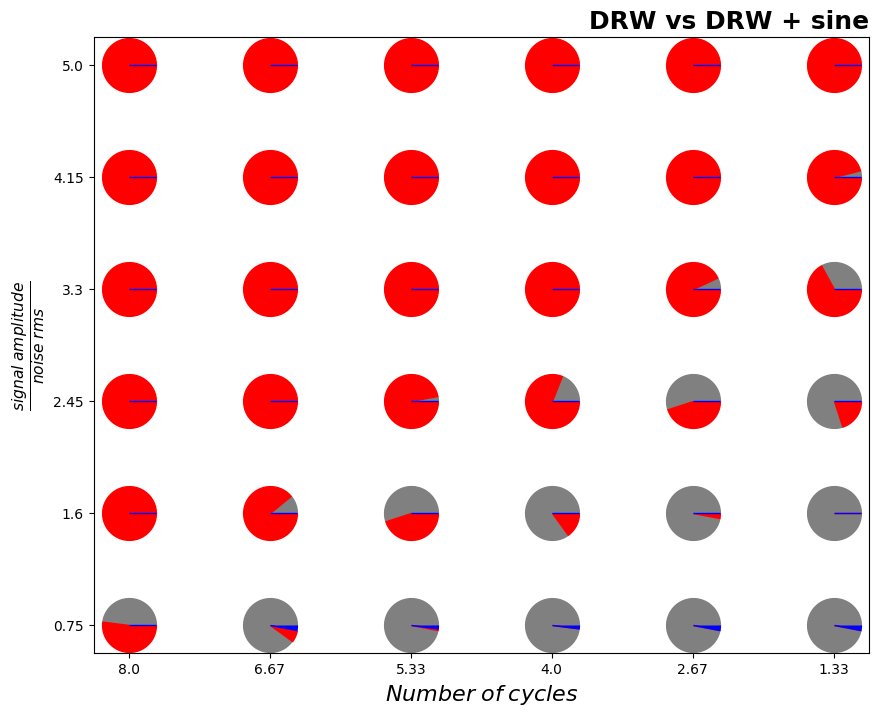

In [ ]:
if True:
    BMCdict_DRW = get_best_model_counts(dictionary = periodicity_simdata.groupby(['period', 'A1'])[['DRWsine_bool']].value_counts().to_dict())
    BMCdict_DRW = dict(sorted(BMCdict_DRW.items(), key=lambda x: x[0]))
    # period_array = []
    # A1_array = []
    DRW_value_counts = []
    DRWsine_value_counts = []
    #FNR_dict = {}
    DRW_value_count_dict = {}
    for key in BMCdict_DRW:
        if key[2]==0:
            # period_array.append(key[0])
            # A1_array.append(key[1])
            #DRW_value_counts.append(BMCdict_DRW[key])
            #FNR_dict[(key[0], key[1])] = BMCdict_DRW[(key[0], key[1], 0)]/(BMCdict_DRW[(key[0], key[1], 0)] + BMCdict_DRW[(key[0], key[1], 1)] )
            DRW_value_count_dict[(key[0], key[1])] = (BMCdict_DRW[(key[0], key[1], 0)], BMCdict_DRW[(key[0], key[1], 1)], BMCdict_DRW[(key[0], key[1], -1)])
            # print(key[0]/3, key[1]/0.15, '-->', DRW_value_count_dict[(key[0], key[1])])

        #elif key[2]==1:
            #DRWsine_value_counts.append(BMCdict_DRW[key])
            

    fig, ax = plt.subplots(1,1, figsize=[10,8])
    for key in DRW_value_count_dict:
        
        #ax.pie(DRW_value_count_dict[key], center=(key[0], key[1]) radius = 0.0, colors=['tab:blue', 'tab:orange'])
        draw_pie(DRW_value_count_dict[key], key[0], key[1], size = 1500, ax=ax)
        
    ax.set_xticks(period_array, np.round(np.linspace(8, 1/0.75, 6), decimals=2))
    ax.set_yticks(A1_array, np.round(np.linspace(0.75, 5, 6), decimals=2))

    ax.set_ylabel(r'$\frac{signal\;amplitude}{noise\;rms}$', fontsize = 16)
    #ax.set_xlabel(r'$\frac{signal\;period}{observation\;period}$', fontsize = 19)
    ax.set_xlabel(r'$Number\;of\;cycles$', fontsize = 16)
    plt.title('DRW vs DRW + sine', loc = 'right', fontsize = 18, weight = 'bold')
    plt.show()

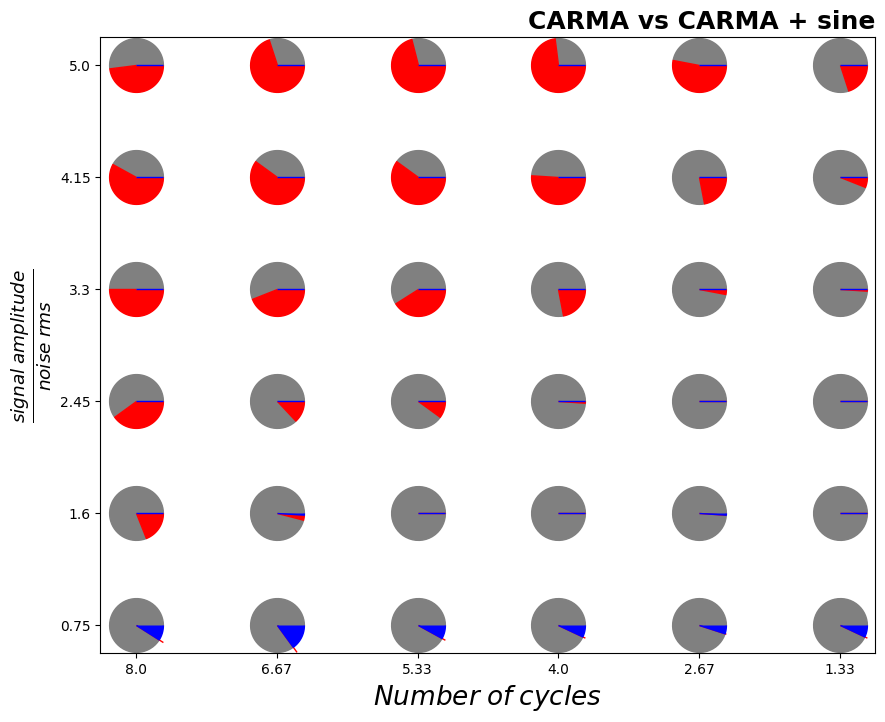

In [ ]:
if True:
    BMCdict_DRW = get_best_model_counts(dictionary = periodicity_simdata.groupby(['period', 'A1'])[['CARMA21sine_bool']].value_counts().to_dict())
    BMCdict_DRW = dict(sorted(BMCdict_DRW.items(), key=lambda x: x[0]))
    # period_array = []
    # A1_array = []
    DRW_value_counts = []
    DRWsine_value_counts = []
    #FNR_dict = {}
    DRW_value_count_dict = {}
    for key in BMCdict_DRW:
        if key[2]==0:
            # period_array.append(key[0])
            # A1_array.append(key[1])
            #DRW_value_counts.append(BMCdict_DRW[key])
            #FNR_dict[(key[0], key[1])] = BMCdict_DRW[(key[0], key[1], 0)]/(BMCdict_DRW[(key[0], key[1], 0)] + BMCdict_DRW[(key[0], key[1], 1)] )
            DRW_value_count_dict[(key[0], key[1])] = (BMCdict_DRW[(key[0], key[1], 0)], BMCdict_DRW[(key[0], key[1], 1)], BMCdict_DRW[(key[0], key[1], -1)])
            # print(key[0]/3, key[1]/0.15, '-->', DRW_value_count_dict[(key[0], key[1])])

        #elif key[2]==1:
            #DRWsine_value_counts.append(BMCdict_DRW[key])
            

    fig, ax = plt.subplots(1,1, figsize=[10,8])
    for key in DRW_value_count_dict:
        
        #ax.pie(DRW_value_count_dict[key], center=(key[0], key[1]) radius = 0.0, colors=['tab:blue', 'tab:orange'])
        draw_pie(DRW_value_count_dict[key], key[0], key[1], size = 1500, ax=ax)
        
    ax.set_xticks(period_array, np.round(np.linspace(8, 1/0.75, 6), decimals=2))
    ax.set_yticks(A1_array, np.round(np.linspace(0.75, 5, 6), decimals=2))

    ax.set_ylabel(r'$\frac{signal\;amplitude}{noise\;rms}$', fontsize = 19)
    #ax.set_xlabel(r'$\frac{signal\;period}{observation\;period}$', fontsize = 19)
    ax.set_xlabel(r'$Number\;of\;cycles$', fontsize = 19)
    plt.title('CARMA vs CARMA + sine', loc = 'right', fontsize = 18, weight = 'bold')
    plt.show()

In [ ]:
def box_grid(simdata, bayes_var, plottype = 'box'):
    fig, axes = plt.subplots(6, 1, figsize = (14,9), sharex=True)
    
    for i,ax in enumerate(axes):
        box_plot_stack = []
        for j, val in enumerate(period_array):
            box_plot_stack.append(simdata.loc[(simdata['A1'] == A1_array[i]) & (simdata['period'] == period_array[j])][bayes_var].to_numpy())
        
        diff = np.diff(period_array,n =1)[2]
        if plottype =='violin':
            plt.violinplot(box_plot_stack, positions=list(set(simdata['period'].to_numpy())), widths=diff/3)
        elif plottype =='box':
            bplot = plt.boxplot(box_plot_stack, positions=list(set(simdata['period'].to_numpy())), widths=diff/3, patch_artist=True)

            for patch in bplot['boxes']:
                patch.set_color(colors[int(j)])
                patch.set_alpha(0.5)

    
    plt.gca().set_xticks(period_array, np.round(np.linspace(8, 1/0.75, 6), decimals=2))
    plt.tick_params( axis = 'x', labelsize= 14)
    plt.xlabel(r'$Number\;of\;cycles$', fontsize = 18)
    #ax.set_yticks(A1_array, np.round(np.linspace(0.75, 5, 6), decimals=2))
    fig.text(-0.04, 0.5, r'$\frac{signal\;amplitude}{noise\;rms}$', va='center', fontsize = 22, rotation='vertical')

    plt.tight_layout()

TypeError: cannot unpack non-iterable numpy.float64 object

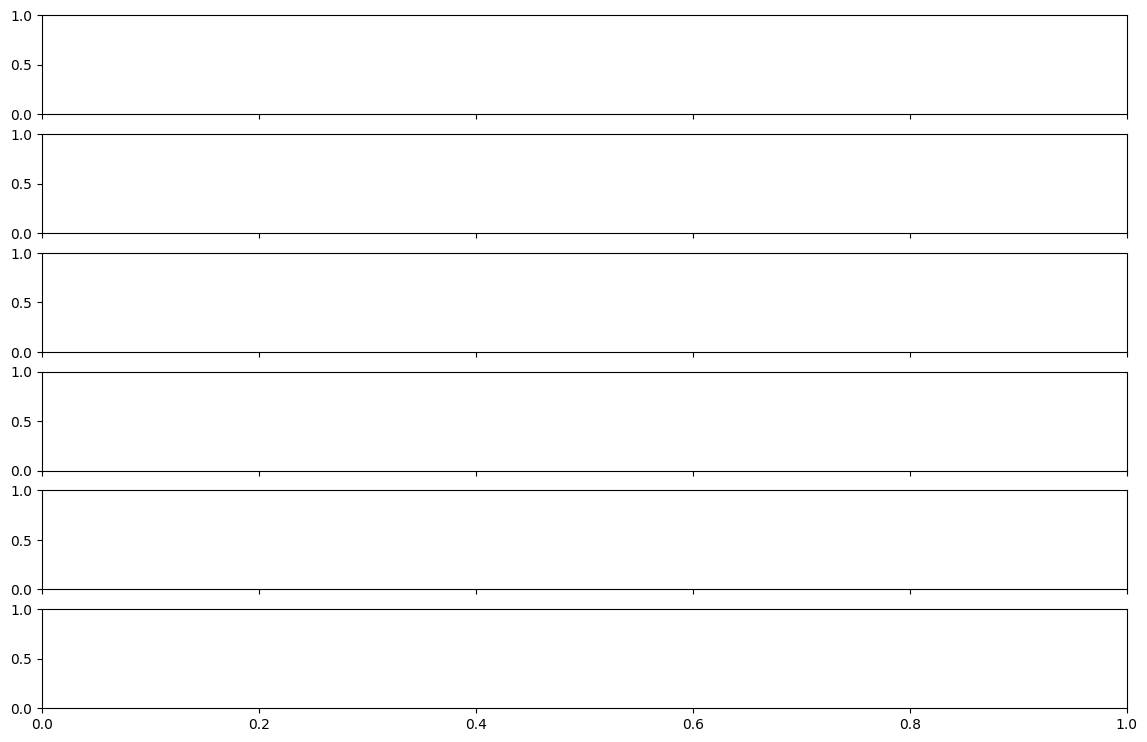

In [ ]:
box_grid(periodicity_simdata, 'DRW_DRWsine_bayes')

In [ ]:
def bar_grid(simdata, boolvar):
    fig, axes = plt.subplots(6, 1, figsize = (14,9), sharex=True)

    BMCdict_DRW = get_best_model_counts(dictionary = simdata.groupby(['period', 'A1'])[[boolvar]].value_counts().to_dict())
    BMCdict_DRW = dict(sorted(BMCdict_DRW.items(), key=lambda x: x[0]))

    DRW_value_counts = []
    DRWsine_value_counts = []
    DRW_value_count_dict = {}
    for key in BMCdict_DRW:
        if key[2]==0:
            DRW_value_count_dict[(key[0], key[1])] = (BMCdict_DRW[(key[0], key[1], 0)], BMCdict_DRW[(key[0], key[1], 1)], BMCdict_DRW[(key[0], key[1], -1)])


    for i, ax in enumerate(axes):
        ax.set_ylabel(np.round(np.linspace(0.75, 5, 6)[i], decimals=2), fontsize= 14)
        for j,val in enumerate(period_array):
            per_values = list(DRW_value_count_dict[(period_array[j], A1_array[i])])
            per_values.reverse()
            bottom = 0
            colors= ['blue', 'red', 'gray']
            for k,per in enumerate(per_values):
                ax.bar(period_array[j], per, bottom=bottom, color = colors[k] )
                bottom+=per
    plt.gca().set_xticks(period_array, np.round(np.linspace(8, 1/0.75, 6), decimals=2))
    plt.tick_params( axis = 'x', labelsize= 14)
    plt.xlabel(r'$Number\;of\;cycles$', fontsize = 18)
    #ax.set_yticks(A1_array, np.round(np.linspace(0.75, 5, 6), decimals=2))
    fig.text(-0.04, 0.5, r'$\frac{signal\;amplitude}{noise\;rms}$', va='center', fontsize = 22, rotation='vertical')

    plt.tight_layout()

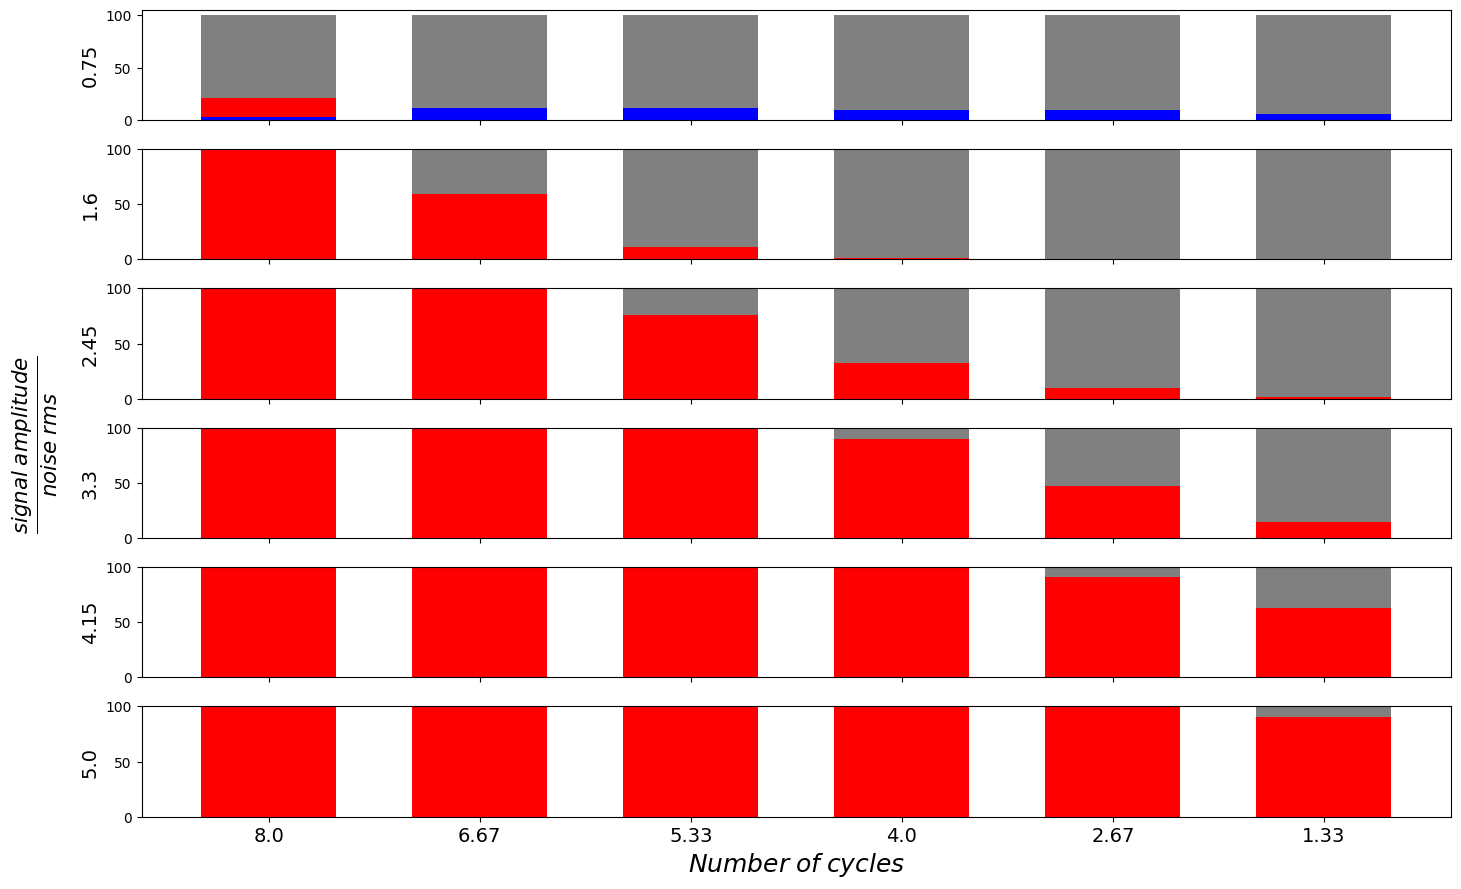

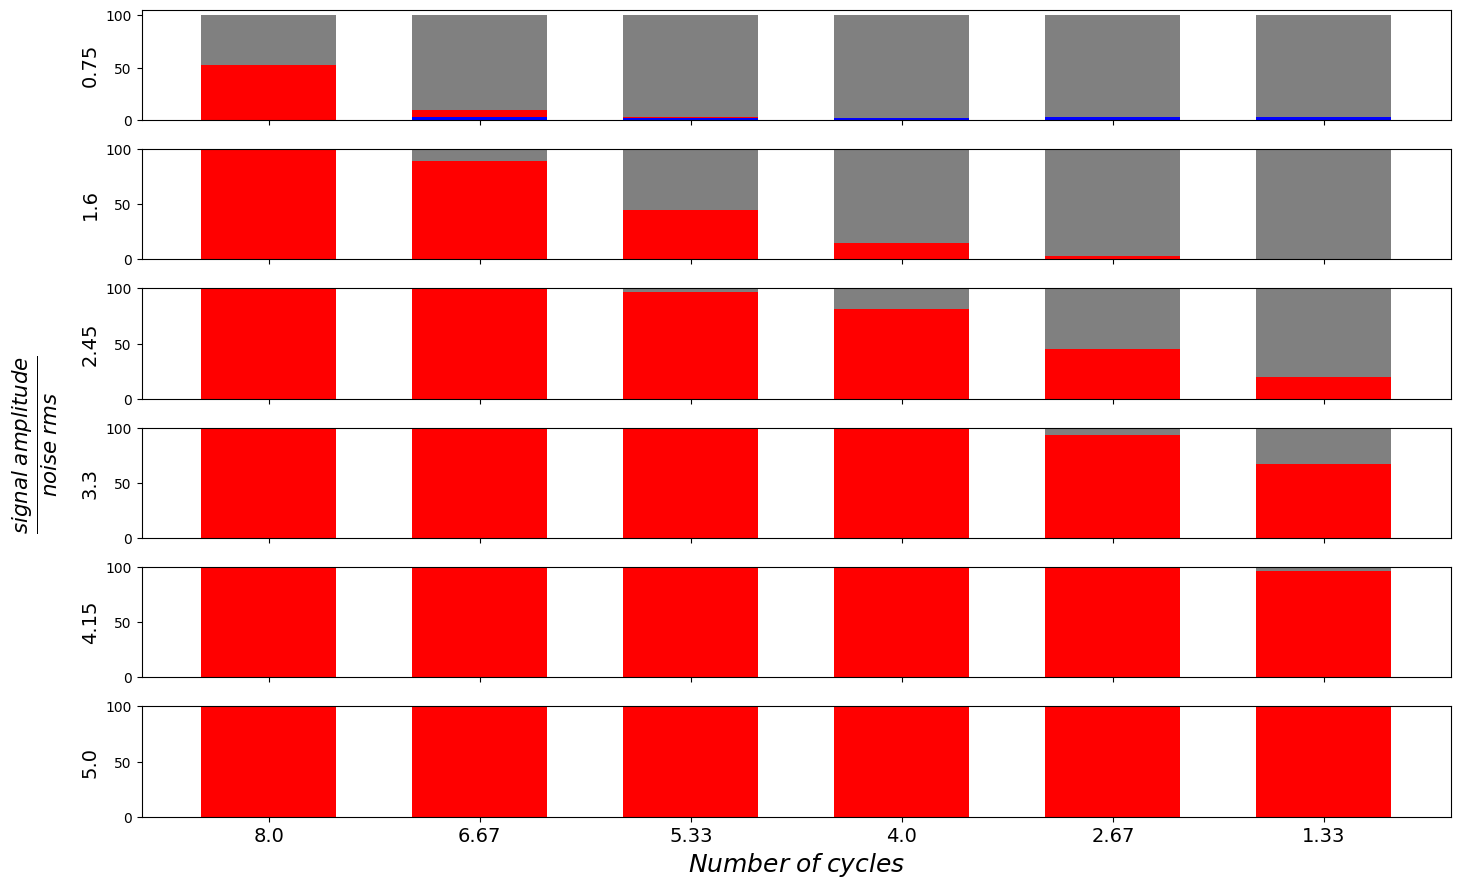

In [ ]:
bar_grid(periodicity_simdata, boolvar='DRWsine_bool')
bar_grid(periodicity_simdata_1year, boolvar='DRWsine_bool')

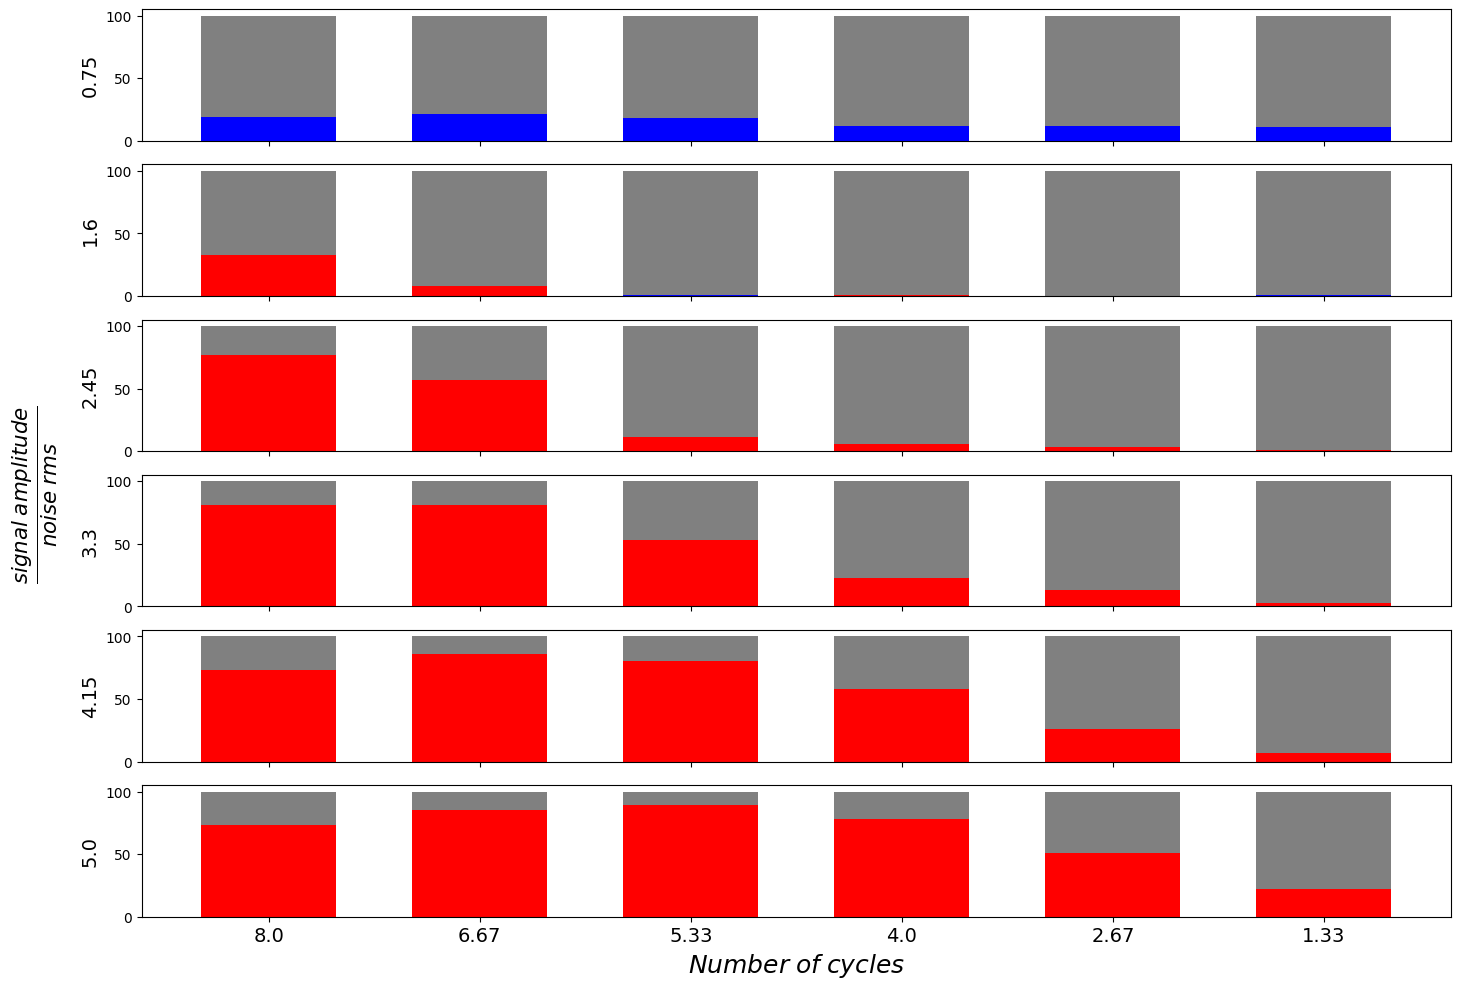

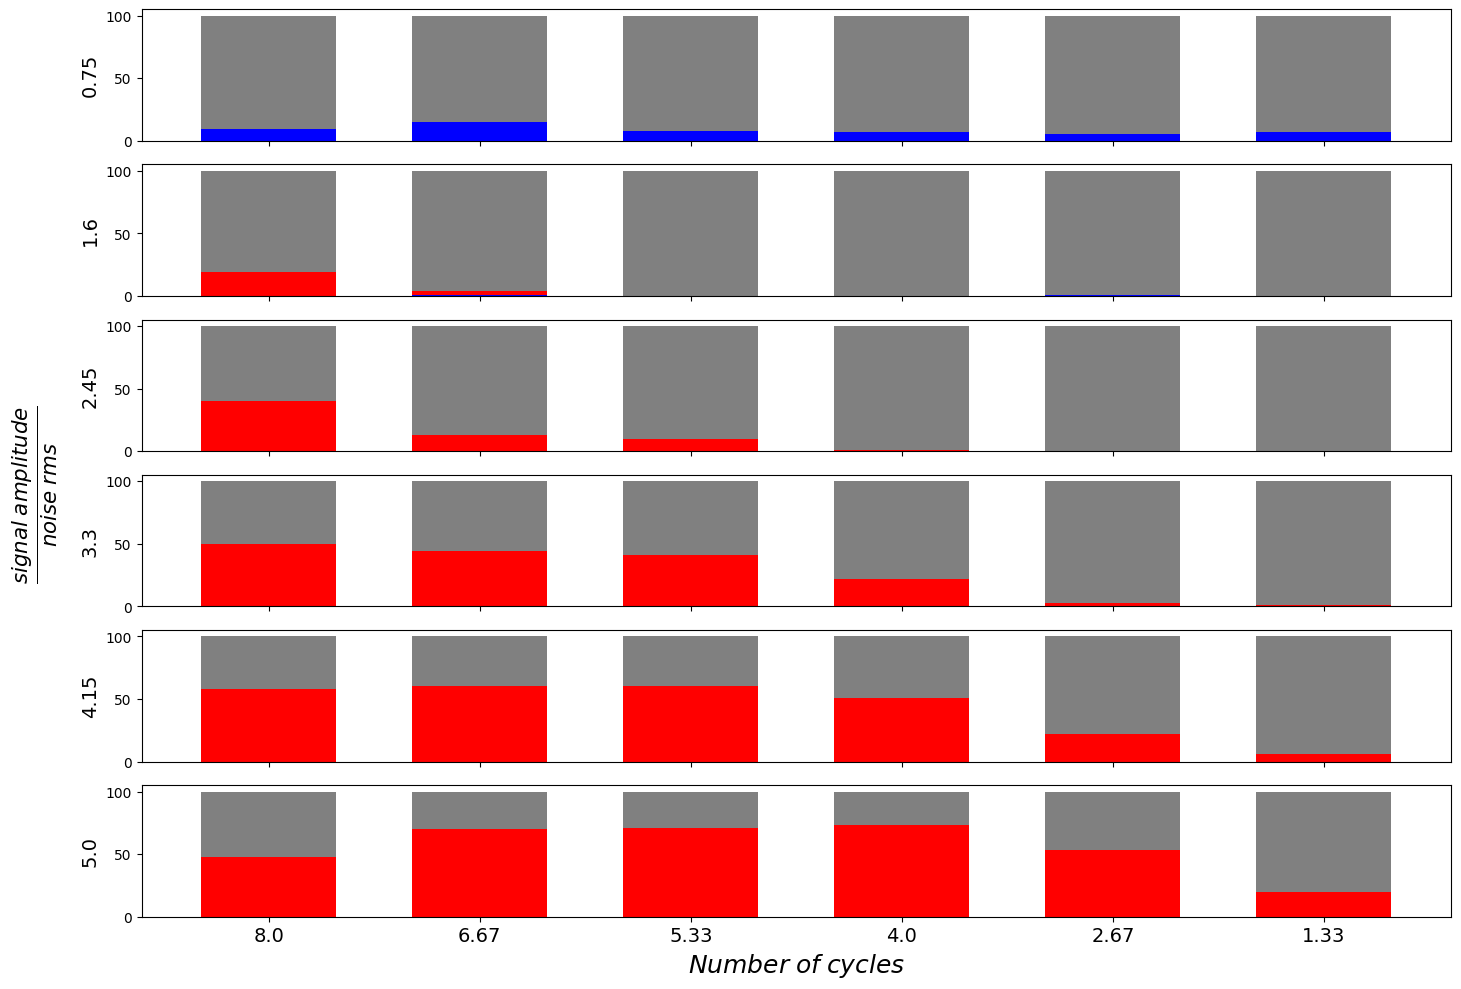

In [ ]:
bar_grid(periodicity_simdata, boolvar='CARMA21sine_bool')
bar_grid(periodicity_simdata_1year, boolvar='CARMA21sine_bool')


In [ ]:
import seaborn as sns

In [ ]:
novar_simdata = datacollector(csv_file_path= 'simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_14_period_0.75_A1_0.375_no_variability.csv',
                         json_files_path='json_files/no_variability/')

Collected all json files...


Gathering data from json files to dataframe: 100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


In [ ]:
def confusion_matrix_half( no_period_dataset, period_dataset, model='DRW'):
        if model =='DRW':
            boolvar = 'DRWsine_bool'
        if model =='CARMA21':
            boolvar = 'CARMA21sine_bool'
        if model =='OBPL':
            boolvar = 'OBPLsine_bool'
            
        no_period_prediction = no_period_dataset[boolvar].value_counts().to_dict()
        period_prediction = period_dataset[boolvar].value_counts().to_dict()
        
        for i in [-1,0,1]:
            if i not in no_period_prediction.keys():
                no_period_prediction[i] = 0
            if i not in period_prediction.keys():
                period_prediction[i] = 0
        
        confusion_matrix = np.zeros((1, 3), dtype=int)

        confusion_matrix[0, 0] = period_prediction[0]
        confusion_matrix[0, 1] = period_prediction[-1]
        confusion_matrix[0, 2] = period_prediction[1]
        #confusion_matrix[1, 0] = period_prediction[0]
        #confusion_matrix[1, 1] = period_prediction[-1]
        #confusion_matrix[1, 2] = period_prediction[1]
        
        row_sums = confusion_matrix.sum(axis=1)
        new_matrix = confusion_matrix / row_sums[:,np.newaxis]
        
        plt.figure(figsize=(10, 3.5))
        #sns.set(font_scale=1.2)
        #[['inconclusive', 'True Negative', 'False Postive'],['inconclusive', 'False Negative', 'True Positive']]
        sns.heatmap(new_matrix, annot=True, cmap='Blues',
                    xticklabels=['$inconclusive$', '$Noise\;only\;prefered$', '$periodic\;model\;prefered$'],
                    yticklabels=['$Periodicity\;simulated$'], square=False, annot_kws={'size': 17})

        plt.xlabel('Predicted', fontsize = 18, weight = 'bold')
        plt.ylabel('True', fontsize = 18, weight = 'bold')
        plt.tight_layout()
        plt.show()
        return new_matrix

In [ ]:
novar_simdata.period

0      0.75
1      0.75
2      0.75
3      0.75
4      0.75
       ... 
395    0.75
396    0.75
397    0.75
398    0.75
399    0.75
Name: period, Length: 400, dtype: float64

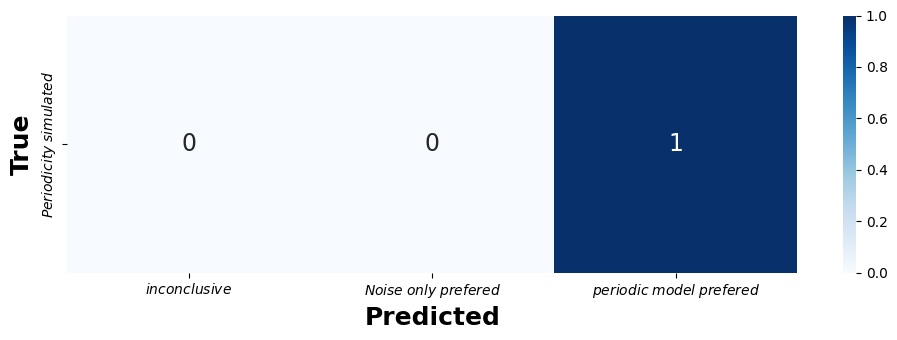

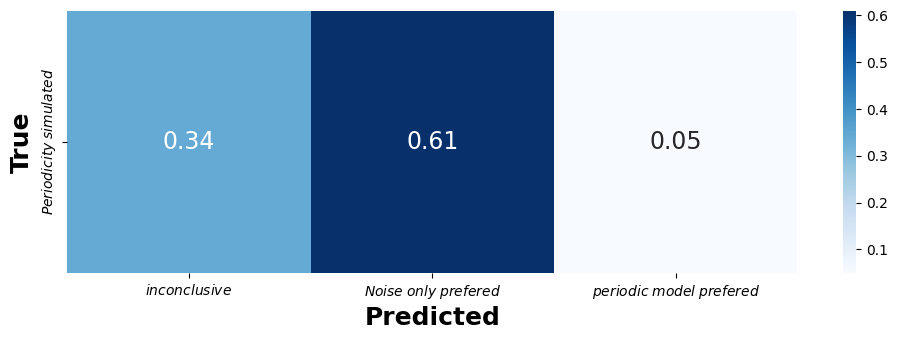

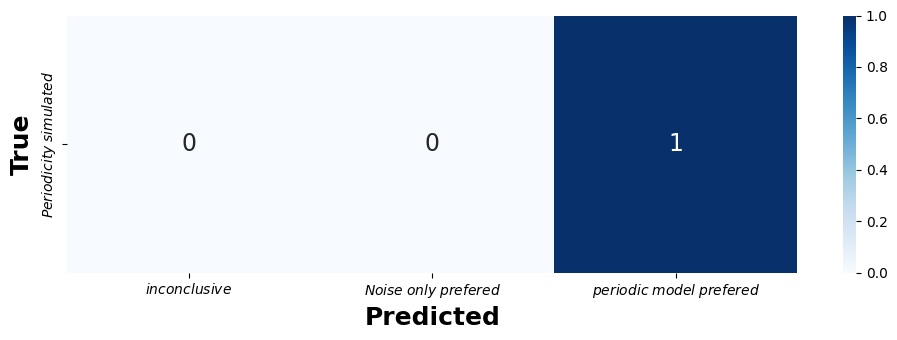

In [ ]:
DRW_matrix = confusion_matrix_half(no_period_dataset = novar_simdata.loc[(novar_simdata.A1==0) ], #& (novar_simdata.bendfreq != bf_array[bf_ar_ind])], 
                        period_dataset=novar_simdata.loc[(novar_simdata.A1==0.375) &  (novar_simdata.period==0.75)], model='DRW')#& (novar_simdata.bendfreq != bf_array[bf_ar_ind]) ], model='DRW')
CARMA_matrix = confusion_matrix_half(no_period_dataset = novar_simdata.loc[(novar_simdata.A1==0) ],#& (novar_simdata.bendfreq != bf_array[bf_ar_ind])], 
                        period_dataset=novar_simdata.loc[(novar_simdata.A1==0.375) &  (novar_simdata.period==0.75)], model='CARMA21')#& (novar_simdata.bendfreq != bf_array[bf_ar_ind]) ], model='CARMA21')
OBPL_matrix = confusion_matrix_half(no_period_dataset = novar_simdata.loc[(novar_simdata.A1==0)],# & (novar_simdata.bendfreq != bf_array[bf_ar_ind])], 
                        period_dataset=novar_simdata.loc[(novar_simdata.A1==0.375) &  (novar_simdata.period==0.75)], model='OBPL')#& (simdata1.bendfreq != bf_array[bf_ar_ind]) ], model='OBPL')

# Real data tests


In [ ]:
from plotter import datacollector_realtest


In [ ]:
def load_json(file_path):
        with open(file_path) as json_file:
            return json.load(json_file)
        
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    plt.show()
    
def sort_arrays_together(time, flux, err=[None]):
        """
        Sorts two arrays (time and flux) together based on the values of the time array.

        Parameters:
        - time: array-like, array to be sorted
        - flux: array-like, corresponding flux values

        Returns:
        - sorted_time: array-like, sorted time array
        - sorted_flux: array-like, corresponding flux values sorted based on time
        """
        indices = np.argsort(time)
        sorted_time = time[indices]
        sorted_flux = flux[indices]
        if err[0]!=None:
            sorted_flux_err = err[indices]
            return sorted_time, sorted_flux, sorted_flux_err
        else:
            return sorted_time, sorted_flux
        
        
def sine_curve_model(params, time):
    
    return params['A1']* jnp.cos(2*jnp.pi*time/params['t0']) + params['A2']* jnp.sin(2*jnp.pi*time/params['t0']) 


def sample_posterior_within_1sigma(param_samples_dict, num_samples, q = [0, 100]):
    param_names = list(param_samples_dict.keys())
    param_samples = np.array(list(param_samples_dict.values()))
    lower_quantiles, upper_quantiles = np.percentile(param_samples, q, axis=1)
    
    within_1sigma_mask = np.all((param_samples.T >= lower_quantiles) & (param_samples.T <= upper_quantiles), axis=1)
    filtered_samples = param_samples[:, within_1sigma_mask].T
    
    if len(filtered_samples) < num_samples:
        raise ValueError("Not enough samples within 1σ to draw the desired number of samples")
    
    sampled_indices = np.random.choice(filtered_samples.shape[0], size=num_samples, replace=False)
    sampled_params = filtered_samples[sampled_indices]
    
    if num_samples==1:
        sampled_values_dict = {param_names[i]: sampled_params[:, i][0] for i in range(len(param_names))}
    else:
        sampled_values_dict = {param_names[i]: sampled_params[:, i] for i in range(len(param_names))}
    
    return sampled_values_dict

def build_gp_DRW(theta, X, diag, mean_val = 0):

    amp = theta["amp"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    kernel = amp * kernels.Exp(scale = scale)
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)


def build_gp_OBPL(theta, X, y, diag, mean_val = 0):

    amp = theta["amp"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    scale= theta["scales"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([amp, alpha_l, 1/scale, alpha_h], free_parameters=[True]*4)
    
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=10,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF

    return GaussianProcess(kernel, X, diag=(diag*err_scale)**2, mean=mean_val)

def build_gp_CARMA21(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def GPmaker(model, dicti, X, Y,  Yerr, mean=0):
    if 'DRW' in model:
        return build_gp_DRW(dicti, X, Yerr, mean_val=mean)
    elif 'CARMA' in model:
        return build_gp_CARMA21(dicti, X, Yerr, mean_val=mean)
    elif 'OBPL' in model:
        return build_gp_OBPL(dicti, X, Y, Yerr, mean_val=mean)
    
def meanval(model, dicti):
    if 'sine' in model:
        return partial(sine_curve_model, dicti)
    else:
         return 0

def LC_GP_plotter(model_dictiii, time, flux, flux_err, plot_samples=True, plot_what='all', fig_size = [10,6]):
    
    model_dict = model_dictiii.copy()
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    print(params)
    
    
    x = np.linspace(min(time)-1, max(time)+1, 1000)
    
    if plot_samples:
        for i in tqdm(range(10), desc='Plotting samples from posteriors... '):
            sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
            # params_sample = {}
            # for (key, val) in sample_dict.items():
            #     params_sample[key] = np.percentile(val, [50])
                
            gp = GPmaker(plot_what, sample_dict, time, flux, flux_err, mean=meanval(plot_what, sample_dict))
            cond_gp = gp.condition(flux, x).gp
            mu, var = cond_gp.loc, cond_gp.variance
            if i ==0:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
            else:
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
    
    if 'sine' in plot_what:
        for i in range(50):
            if i ==0:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, sine_curve_model(sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84]), x), 'r-', alpha = 0.2)
  
    gp = GPmaker(plot_what, params, time, flux, flux_err, mean=meanval(plot_what, params))
    cond_gp = gp.condition(flux, x).gp
    mu, var = cond_gp.loc, cond_gp.variance
    ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
    ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*2, max(flux) + np.std(flux)*2)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.tight_layout()

    plt.show()

def LC_GPdict_plotter(model_dict, time, flux, flux_err, plot_samples=True, plot_what='all'):
    
    model_dict.pop('log_Z_mean')
    model_dict.pop('log_Z_uncert')
    
    params = {}
    params_1sigma_lower = {}
    params_1sigma_upper = {}
    for (key, val) in model_dict.items():
        params[key], params_1sigma_lower[key], params_1sigma_upper[key] = np.percentile(val, [50, 16, 84])
         
    fig, ax = plt.subplots(1,1,figsize=[10,6])
    print(params)
    
    if plot_what == 'DRW':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_DRW(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'DRWsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_DRW(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=1, label = 'Data')
        gp = build_gp_DRW(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        
    elif plot_what == 'CARMA':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_CARMA21(params, time, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'CARMAsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in range(20):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_CARMA21(sample_dict, time, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_CARMA21(params, time, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[16, 84])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPL':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1, q = [5, 95])
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=0)
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                if i ==0:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2, label = 'samples from posterior')
                else:
                    ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2,)
        
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        ax.errorbar(time, flux,yerr=flux_err,fmt='.', color='k' , alpha=1, label = 'Data')
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
        
    elif plot_what == 'OBPLsine':
        x = np.linspace(min(time)-1, max(time)+1, 1000)
        
        if plot_samples:
            for i in tqdm(range(10)):
                sample_dict = sample_posterior_within_1sigma(model_dict, num_samples=1)
                # params_sample = {}
                # for (key, val) in sample_dict.items():
                #     params_sample[key] = np.percentile(val, [50])
                    
                gp = build_gp_OBPL(sample_dict, time, flux, flux_err, mean_val=partial(sine_curve_model, params))
                cond_gp = gp.condition(flux, x).gp
                mu, var = cond_gp.loc, cond_gp.variance
                
                ax.plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "b-", lw=1, alpha=0.2)
    
        ax.errorbar(time, flux,yerr=flux_err, fmt='.', color='k' , alpha=0.2, label = 'Data')
        gp = build_gp_OBPL(params, time, flux, flux_err, mean_val= partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance
        for i in range(50):
            if i ==0:
                
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2, label = 'Sine : 1 sigma samples')
            else:
                ax.plot(x, jax.vmap(partial(sine_curve_model, sample_posterior_within_1sigma(model_dict, num_samples=1, q =[5, 95])))(x), 'r-', alpha = 0.2)
        ax.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5, label = r'$1\sigma\;err$')
    
    plt.tight_layout()
    plt.xlim(min(x), max(x))
    plt.ylim(min(flux) - np.std(flux)*3, max(flux) + np.std(flux)*3)
    plt.legend()
    plt.grid()
    plt.ylabel(r'$Flux\;[arbitary\;units]$', fontsize = 14)
    plt.xlabel(r'$Time\;[years]$', fontsize = 14)
    plt.tick_params(labelsize = 11)
    plt.show()
    del time, flux, flux_err, #DRW_results, DRW_sine_results, gp, cond_gp, params

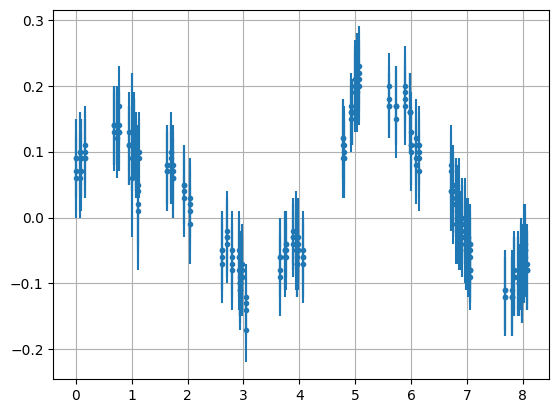

In [ ]:
LCdata = pd.read_csv('AGNobsdata/graham2015data.csv')
LCdata['years'] = (LCdata.MJD.to_numpy())/365
lcTIME = LCdata.years.to_numpy()
lcFLUX = LCdata.Mag.to_numpy() - np.median(LCdata.Mag.to_numpy())
lcFLUXerr = LCdata.Magerr.to_numpy()

lcTIME, lcFLUX, lcFLUXerr = sort_arrays_together(lcTIME, lcFLUX, lcFLUXerr)
lcTIME = lcTIME -lcTIME[0]

plt.errorbar(lcTIME, lcFLUX, yerr=lcFLUXerr, fmt = '.')
plt.grid()

In [ ]:

org_DRW_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4DRW.json')
org_DRWsine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4DRWsine.json')

org_CARMA21_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4CARMA21.json')
org_CARMA21sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4CARMA21sine.json')


org_OBPL10_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4OBPL10.json')
org_OBPL10sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_alpha_h_2_4OBPL10sine.json')


In [ ]:

org_DRW_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_DRW.json')
org_DRWsine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_DRWsine.json')

org_CARMA21_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_CARMA21.json')
org_CARMA21sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_CARMA21sine.json')


org_OBPL10_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_OBPL10.json')
org_OBPL10sine_dict = load_json('real_data_tests/Graham2015/original_data_broad_priors_OBPL10sine.json')

In [ ]:
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    log_params = ['amp', 'scales']
    for val in filtered_data.keys():
        if val in log_params:
            filtered_data[val] = np.log10(filtered_data[val])
        
    
    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    return fig, filtered_data

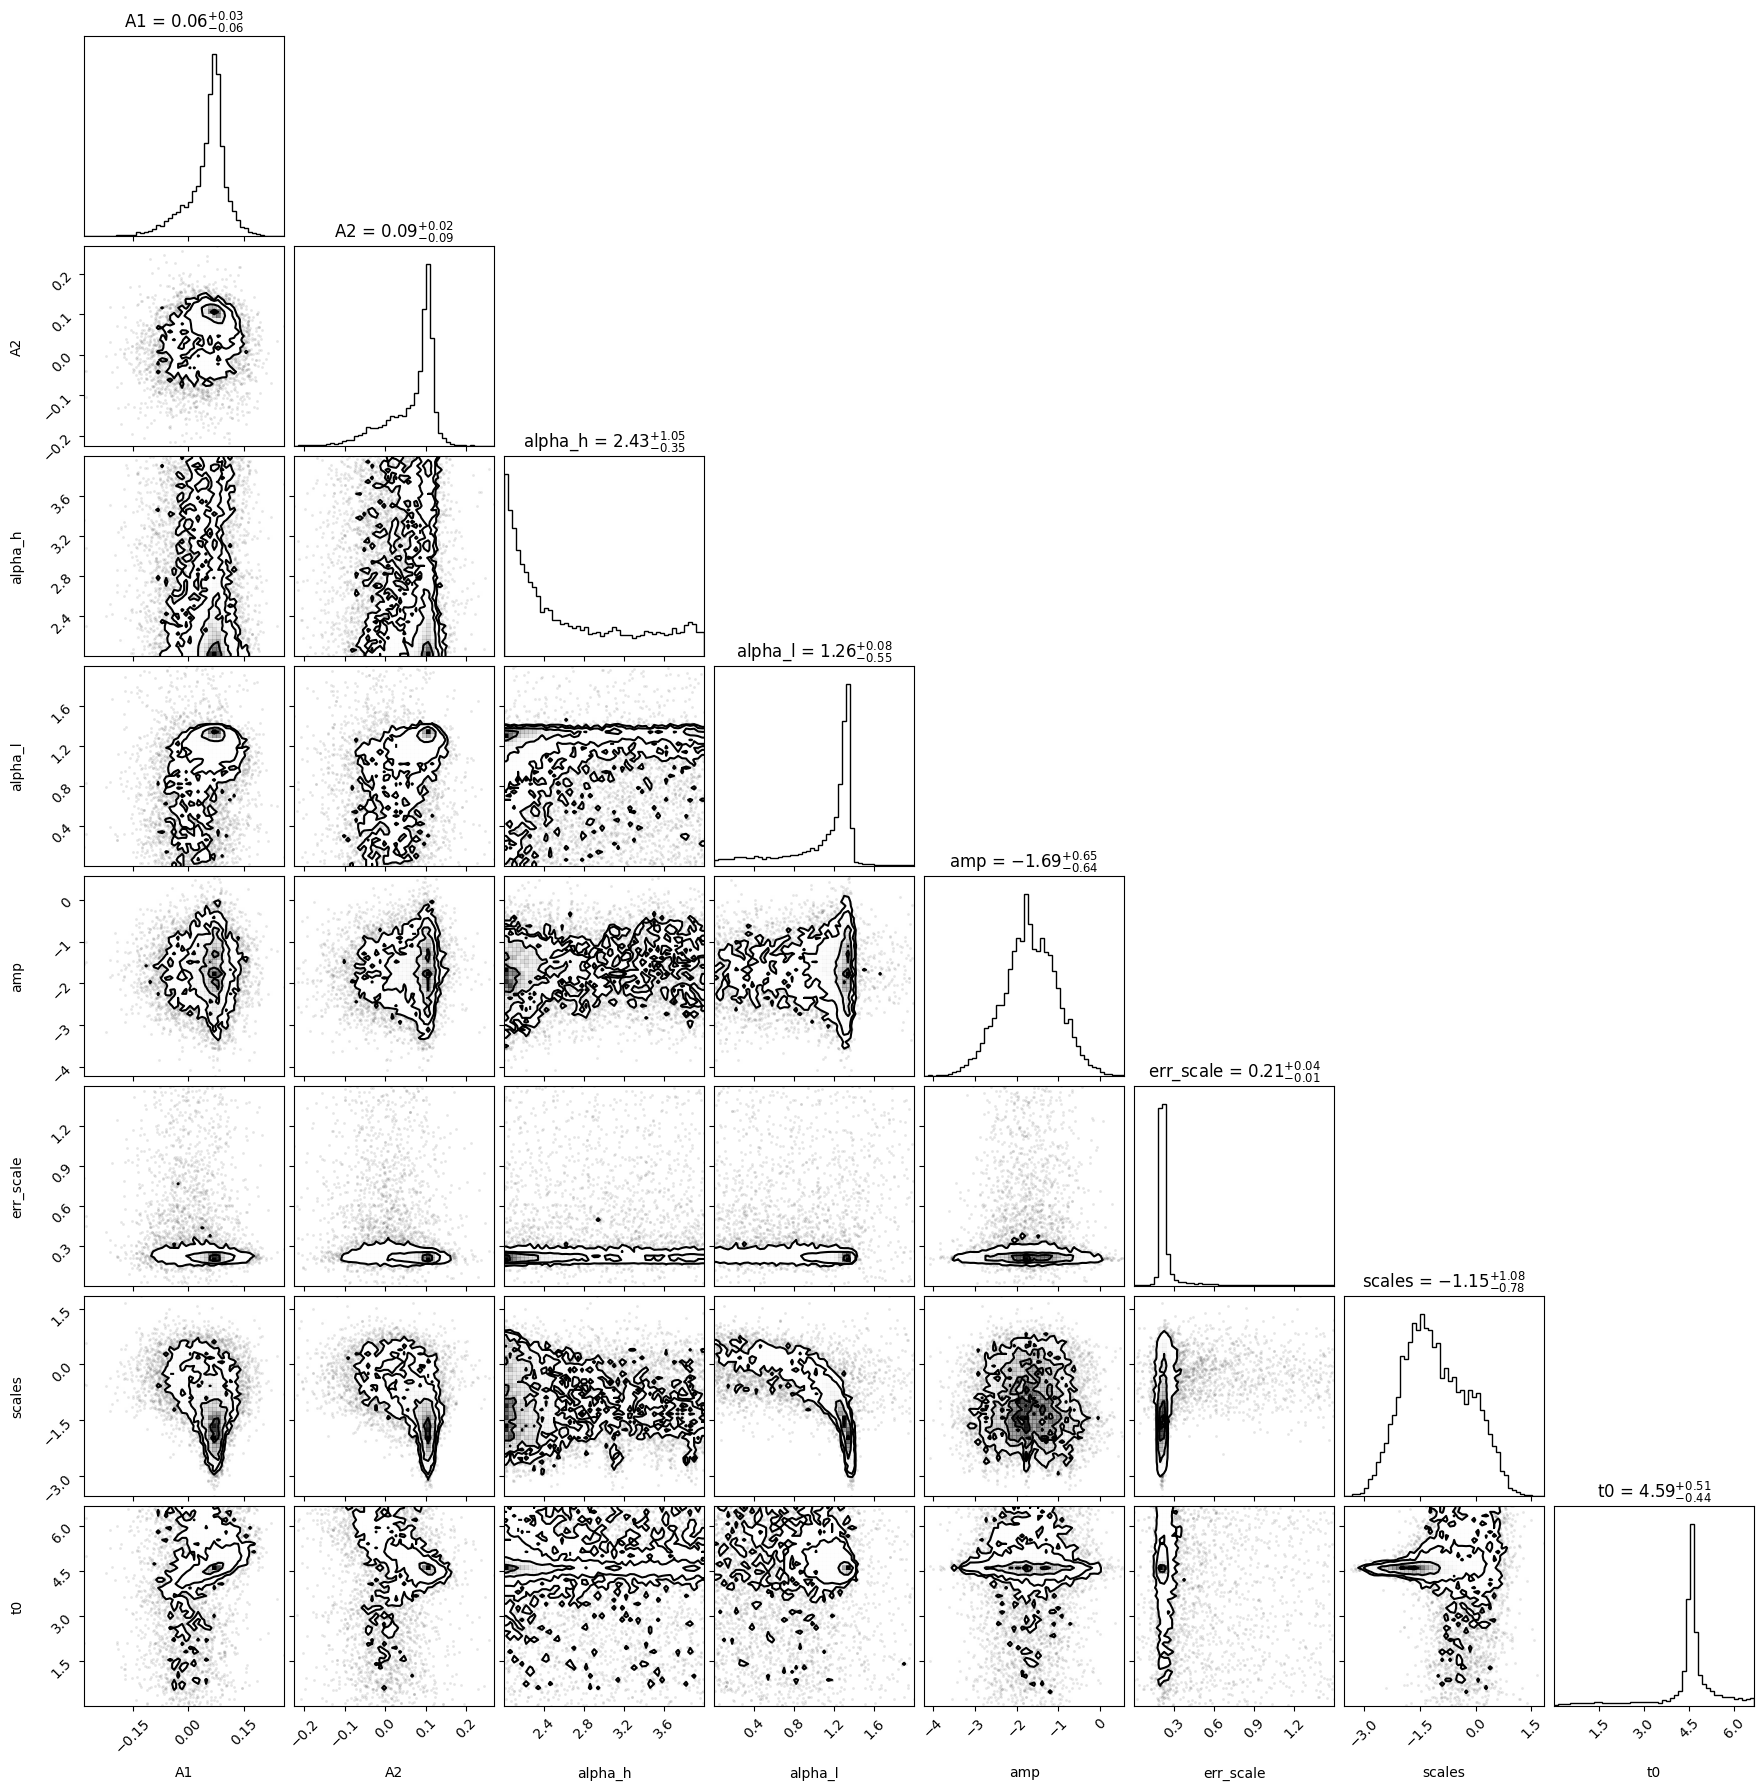

In [ ]:
fig, filtered = plot_corner(org_OBPL10sine_dict)
#axes = np.array(fig.axes).reshape((8, 8))

# for i in range(8):
#     ax = axes[i, i]
#     # ax.axvline(value1[i], color="g")
#     # ax.axvline(value2[i], color="r")
#     if i == 4:
#         ax.axvline(2)
#         ax.set_xlim(0, 1)

dict_keys(['A1', 'A2', 'alpha_h', 'alpha_l', 'amp', 'err_scale', 'scales', 't0'])